In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import gc # Free up memory

import scipy.stats
import scipy.special

import copy
import pandas as pd
# Imports
import pandas as pd
import numpy as np
#from keras.models import Sequential
#from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
#from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# fetch data

In [48]:


#from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_1A_MONTHLY.csv')
zone_data_7 = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_7_MONTHLY.csv')
zone_data_6 = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_6_MONTHLY.csv')


# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A.copy()
#zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6.copy()
#zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7.copy()
#zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)






# Functions to run rolling optimisation and save as csv

In [49]:
def default_kwargs():
    return {'enforce_stationarity': False, 'order':(10, 2, 10)}

def build_arma_model(data, kwargs=None, model_func=ARIMA):
    # Function to create and fit model. By default it fits an ARIMA model.
    # Can take any other function of the form model_func(data, **kwargs) where data is the training predictive set
    # Exogenous variables and other arguments can be passed with kwargs (dictionary with keyword arguments)
    if kwargs is None:
        kwargs = default_kwargs()
    # ARMA model is a special case of ARIMA with no differencing (d=0)
    if model_func == sm.tsa.statespace.SARIMAX:
        kwargs.update({'seasonal_order': (1, 1, 1, 12)})
    model = model_func(data, **kwargs)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000, prediction_kwargs={}):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps, **prediction_kwargs)
    forecast_mean = forecast_result.predicted_mean

    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals

def run_arma(train_data, test_data,  predictive_col='mean_price', kwargs=None, model_func=ARIMA, prediction_kwargs={}):
    
    # Run ARIMA model and get output
    arma_model = build_arma_model(train_data.reset_index()[predictive_col], kwargs=kwargs, model_func=model_func)
    forecast_series, conf_df = forecast_and_simulate(arma_model, steps=len(test_data), prediction_kwargs=prediction_kwargs)
    
    # Store output in dataframe
    df = pd.concat([pd.DataFrame(np.zeros((train_data.shape[0], 2)), columns=conf_df.columns), conf_df])
    df = df.assign(value=pd.concat([train_data.reset_index()[predictive_col], forecast_series]), start=len(train_data))
    
    return df

def stochastic_forecast(model, steps=1000):

    forecast_result = model.get_forecast(steps=steps)

In [50]:
def make_dataset(zone_data, col, output_name, kwargs={}, model_func=ARIMA,  clean_up=True, start_base=20, stop_val=None, exog_cols=None, prediction_kwargs={}):
    dfs = []
    if stop_val is None:
        stop_val = len(zone_data)

    
    kwargs.update(default_kwargs())
    if kwargs is None:
        kwargs = default_kwargs()
    

    # Run arma for different starting times to use in optimisation (could call every time an evaluation is needed but this saves computation)
    for start in np.arange(int(start_base), np.minimum(stop_val, len(zone_data))):
        train_data = zone_data.iloc[:start, :]
        test_data = zone_data.iloc[start:, :]

        # Add exogenous data to the keyword arguments
        if exog_cols is not None:
            if kwargs is None:
                kwargs = default_kwargs()
            kwargs.update({'exog':train_data.reset_index()[exog_cols]})
            prediction_kwargs.update({'exog':test_data.reset_index()[exog_cols]})
            
        dfs.append(run_arma(train_data, test_data, predictive_col=col, kwargs=kwargs, model_func=model_func, prediction_kwargs=prediction_kwargs))
        
    pd.concat(dfs).to_csv(f'{output_name}.csv')

    if clean_up:
        # Delete the probably sizeable dataframe generated to free up memory
        del dfs
        gc.collect()

def get_predictions(df, t, start):
    # Previously returned as np array, changed to series for compatability with filtered datasets
    try:
        return df.loc[df.start==start, :].loc[t, 'value']#.clip(lower=0, upper=10**6)
    except:
        return df.loc[(df.start==start)&np.in1d(df.index, t), 'value']#.clip(lower=0, upper=10**6)
        
def ranking(df, ax=None, kwargs={}):

    t = df.index.unique()
    df["Rank"] = np.nan
    for start in df.start.unique():
        pred = get_predictions(df, t, start)

        ranks = scipy.stats.rankdata(pred)

        #ranks = scipy.stats.rankdata(pred)
        
        df.loc[df.start==start, 'Rank'] = ranks

    if ax is not None:
        rank_df = copy.deepcopy(df)
        rank_df = rank_df.assign(value=rank_df.Rank)
        plot_residuals(rank_df, ax, **kwargs)
# Set global font size
plt.rcParams.update({'font.size': 14})

def plot_dataset(df, ax):
    # Set up for consistent colour mapping
    norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
    map = cm.ScalarMappable(norm=norm, cmap='viridis')

    t = df.index.unique()
    
    # Plotting the data for different starts
    for start in df.start.unique():
        pred = get_predictions(df, t, start)
       # ax.plot(t, get_predictions(df, t, start), c=map.get_cmap()(norm(start)))
        ax.plot(pred.index, pred, c=map.get_cmap()(norm(start)))
    # Formatting plot
    plt.colorbar(map, ax=ax, label="Testing Period Start")
    ax.set_ylim(0, max(get_predictions(df, t, max(df.start))))
    
    ax.set_ylim(0, max(get_predictions(df, t, max(df.start))))

def MAEs(df):
    df["Observed"] = df.index
    df["Observed"] = df["Observed"].map(df.loc[df.start==df.start.max(), 'value'])

    ranking(df)
    df["Observed Rank"] = df.index.map(df.loc[df.start==df.start.max(), 'Rank'])
    
    # was absolute before, value clipped
    df = df.assign(error=(df.value-df.Observed), rank_error = (df.Rank-df["Observed Rank"]))

    return df

def read_rmse(datasetname):
    df = pd.read_csv(datasetname, index_col=0)
    df = MAEs(df)

    return (df.error[df.start>df.index].mean(), df.error[df.start<=df.index].mean()), (df.rank_error[df.start>df.index].mean(), df.rank_error[df.start<=df.index].mean())

def plot_residuals(df, ax, group_size=None, comparison_ax=None, label=None, rank=False):
    if rank:
        ranking(df, ax, kwargs=dict(group_size=group_size, comparison_ax=comparison_ax, label=label))
        return
    # Set up for consistent colour mapping
    norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
    map = cm.ScalarMappable(norm=norm, cmap='viridis')

    t = df.start.unique()

    if group_size is None: # used to be 15
        group_size = int(len(t)/12)

    df["Observed"] = df.index
    df["Observed"] = df["Observed"].map(df.loc[df.start==df.start.max(), 'value'])

    df = df.assign(offset=df.index-df.start, offset_group=(np.floor((df.index-df.start)/group_size)*group_size).astype(int),error=abs(df.value.clip(lower=0, upper=10**6)-df.Observed))

    df.loc[df.index<df.start, 'error'] = np.nan
    df.loc[df.index<df.start, 'offset_group'] = np.nan

    

    for start in df.start.unique():
        t_in  = t[t>=start]
       # ax.plot(t_in-start, get_predictions(df, t_in, start) - get_predictions(df, t_in, df.start.max()), c=map.get_cmap()(norm(start)), alpha=0.1)

    pos = df.groupby('offset_group').offset.min() + group_size/2
    df.boxplot(column='error', by='offset_group', ax=ax, showfliers=False, grid=False, positions=pos, widths=0.8*group_size)

    mse = np.sqrt((df.error**2).mean())
    ax.axhline(mse, ls='--', c='k')

    ax.title.set_text(f"{label}, MAE = {mse:,.1f}")

    ax.set_xticks(ticks = pos, 
                  labels=[f"{min_:.0f}-{max_:.0f}" for min_, max_ in zip(df.groupby('offset_group').offset.min(), df.groupby('offset_group').offset.max())],
                  rotation=20,
                  ha='right')

    ax.set_xlabel("Steps from start")
    ax.set_ylabel("Error")

    ax.set_yscale('log')

    a = [ax]
    if comparison_ax:
        comparison_ax.plot(df.groupby('offset').offset.median(), df.groupby('offset').error.median(), label=label)
        comparison_ax.fill_between(df.groupby('offset').offset.median(), 
                                   df.groupby('offset').error.quantile(0.25), df.groupby('offset').error.quantile(0.75),
                                   alpha = 0.1)
        a.append(comparison_ax)

    for ax_ in a:
        ax_.set_xlabel("Steps from start")
        ax_.set_ylabel("Error")

        ax_.set_yscale('log')
    


In [51]:
# Create a monthly aggregate
zone_data = zone_data_1A_top_sorted
zone_data.Create_date = pd.to_datetime(zone_data['date'])
#grouped = zone_data.groupby(pd.Grouper(key="Create_date", freq='M'))
# Take the median of the monthly price
#zone_data = grouped[["Price Per ML ($)", "Volume Traded (ML)"]].median().fillna(0)
# Take the sum of the monthly volume traded
#zone_data["Volume Traded (ML)"] =grouped["Volume Traded (ML)"].sum().fillna(0)

/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_82384/2878124579.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  zone_data.Create_date = pd.to_datetime(zone_data['date'])


In [52]:
def read_and_plot(dataset_name, ax=None, resid_ax=None, comparison_ax=None, label=None, rank=False):
    df = pd.read_csv(dataset_name, index_col=0)
    print(df.shape)

    if ax is not None:
        plot_dataset(df, ax)
    if resid_ax is not None:
        plot_residuals(df, resid_ax, comparison_ax=comparison_ax, label=label, rank=rank)


# Create ARMA Rolling Price Prediction
Uses rolling price starting from 10 to continue predicting prices

In [53]:
# Create a new results file named ARMA price
# Default settings, ARIMA with order (10, 2, 10)
arma_price = "ARMA Price"
make_dataset(zone_data, "mean_price", arma_price, kwargs={'order':(10, 2, 10)})

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

In [54]:
# Load in dataset with exogenous variables

exo_data = pd.read_csv('../[3.2] - EXOG_PCA/EXOG_MONTHLY_MEDIAN_CONSOLIDATED.csv')

new_data = pd.merge(exo_data, zone_data, left_index=True, right_index=True, suffixes=['2', None])
new_data.head(10)

Time  Monthly Mean Temperature  Monthly Mean Dry Air  \
0  2010-01-31 00:00:00+10:00                 22.564080                21.600   
1  2010-02-28 00:00:00+10:00                 22.649412                19.450   
2  2010-03-31 00:00:00+10:00                 20.027626                16.650   
3  2010-04-30 00:00:00+10:00                 17.088161                13.175   
4  2010-05-31 00:00:00+10:00                 12.434865                 8.525   
5  2010-06-30 00:00:00+10:00                  9.909270                 5.900   
6  2010-07-31 00:00:00+10:00                  8.586891                 5.275   
7  2010-08-31 00:00:00+10:00                  9.768465                 6.740   
8  2010-09-30 00:00:00+10:00                 12.730612                 9.780   
9  2010-10-31 00:00:00+10:00                 16.206540                13.280   

   Monthly Mean Storage Volume  Monthly Mean Electrical Conductivity  \
0                   806.170485                            300.885792   
1                   801.501412                            294.598913   
2                   810.382257                            316.057635   
3                   810.750574                            329.128641   
4                   802.881373                            332.211765   
5                   803.049311                            347.033649   
6                   811.126175                            359.451376   
7                   842.707388                            320.768919   
8                   853.974883                            314.629911   
9                   855.212337                            366.657746   

   Monthly Mean Rainfall  Monthly Mean Water Course Discharge  Unnamed: 0  \
0              33.129559                             3.466405           0   
1              86.405153                             3.758896           1   
2              86.315962                             3.352010           2   
3              52.254820                             2.387946           3   
4              64.370699                             2.307751           4   
5              68.515048                             2.731615           5   
6              57.116573                             3.837355           6   
7             122.481749                             9.357279           7   
8              82.345627                            15.816635           8   
9             137.274242                            11.527253           9   

         date   mean_price  IQR_price  mean_volume  IQR_volume  
0  2009-04-30  2150.000000      250.0    58.825000      65.825  
1  2009-05-31  2073.684211      350.0    25.163158      24.650  
2  2009-06-30  2106.350000      325.0    41.767500      64.800  
3  2009-07-31  2306.540897       50.0   136.673793     160.000  
4  2009-08-31  2140.525750      400.0    50.027500      71.125  
5  2009-09-30  2260.359605      200.0   108.886842     118.375  
6  2009-10-31  2232.448553      400.0    71.668421      91.000  
7  2009-11-30  1967.510198      200.0   125.102970     145.000  
8  2009-12-31  2146.595682      400.0    91.953409     119.150  
9  2010-01-31  2183.626610      400.0    55.867797      73.500

In [55]:
# Create a new file called SARIMAX Price
sarimax_price = "SARIMAX Price zone A1"
# Make it a SARIMAX model by passing the SARIMAX function and columns to be used as exogenous data
make_dataset(new_data, "mean_price", sarimax_price, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[1:8])

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52093D-01    |proj g|=  5.22290D-03

At iterate    5    f=  1.51985D-01    |proj g|=  4.25983D-04

At iterate   10    f=  1.51771D-01    |proj g|=  7.45505D-03

At iterate   15    f=  1.77498D-02    |proj g|=  8.64860D+00
  ys=-1.531E-01  -gs= 2.545E-02 BFGS update SKIPPED



 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -6.09530D-02    |proj g|=  7.24118D+00
  ys=-7.955E-12  -gs= 2.001E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     23    123      3     2     0   5.162D+00  -6.095D-02
  F =  -6.0953458656506657E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95872D-01    |proj g|=  1.02436D-02

At iterate    5    f=  2.95465D-01    |proj g|=  4.04425D-04

At iterate   10    f=  2.95118D-01    |proj g|=  7.20265D-03

At iterate   15    f=  2.17163D-01    |proj g|=  5.73024D-01

At iterate   20    f=  1.15495D-01    |proj g|=  7.44530D+00

At iterate   25    f=  5.12955D-02    |proj g|=  2.80459D+01

At iterate   30    f= -3.07478D-03    |proj g|=  8.27497D+01
  ys=-5.629E-05  -gs= 3.836E-04 BFGS update SKIPPED

At iterate   35    f= -6.30104D-02    |proj g|=  4.62733D+01

At iterate   40    f= -1.21022D-01    |proj g|=  9.59967D+02
  ys=-7.623E-03  -gs= 2.469E-03 BFGS update SKIPPED

At iterate   45    f= -1.33448D-01    |proj g|=  2.66707D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-6.800E-17  -gs= 6.407E-15 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting pa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     49    228      4     3     0   2.683D+02  -1.335D-01
  F = -0.13345355175215032     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37082D-01    |proj g|=  3.53477D-02

At iterate    5    f=  4.31691D-01    |proj g|=  5.94842D-04

At iterate   10    f=  4.31600D-01    |proj g|=  5.79154D-03

At iterate   15    f=  4.30465D-01    |proj g|=  4.28273D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92942D-01    |proj g|=  7.69646D-02

At iterate    5    f=  5.63692D-01    |proj g|=  7.56939D-04

At iterate   10    f=  5.63564D-01    |proj g|=  2.22748D-03

At iterate   15    f=  5.63333D-01    |proj g|=  4.80995D-03

At iterate   20    f=  5.62928D-01    |proj g|=  3.11651D-03

At iterate   25    f=  5.62668D-01    |proj g|=  4.12335D-03

At iterate   30    f=  5.62107D-01    |proj g|=  1.15180D-02

At iterate   35    f=  5.60885D-01    |proj g|=  4.34681D-03

At iterate   40    f=  5.60405D-01    |proj g|=  7.91291D-03

At iterate   45    f=  5.59685D-01    |proj g|=  4.05411D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  5.58706D-01    |proj g|=  3.06988D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     69      1     0     0   3.070D-02   5.587D-01
  F =  0.55870556622262091     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67488D-01    |proj g|=  9.67088D-02

At iterate    5    f=  6.94215D-01    |proj g|=  6.49201D-03

At iterate   10    f=  6.93292D-01    |proj g|=  5.92394D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  6.71280D-01    |proj g|=  5.09897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     65      1     0     0   5.099D-02   6.713D-01
  F =  0.67128012936898129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87854D-01    |proj g|=  1.25112D-01

At iterate    5    f=  8.12136D-01    |proj g|=  8.76962D-03

At iterate   10    f=  8.11584D-01    |proj g|=  2.02528D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  8.04594D-01    |proj g|=  6.60668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   6.607D-02   8.046D-01
  F =  0.80459375362345553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00123D+00    |proj g|=  1.22817D-01

At iterate    5    f=  9.25284D-01    |proj g|=  1.72770D-02

At iterate   10    f=  9.23582D-01    |proj g|=  3.86488D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  9.19609D-01    |proj g|=  1.98053D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     65      1     0     0   1.981D-02   9.196D-01
  F =  0.91960868462325962     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16663D+00    |proj g|=  1.31594D-01

At iterate    5    f=  1.06811D+00    |proj g|=  8.13015D-03

At iterate   10    f=  1.06458D+00    |proj g|=  3.63100D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24703D+00    |proj g|=  1.25778D-01

At iterate    5    f=  1.18456D+00    |proj g|=  9.72338D-03

At iterate   10    f=  1.18216D+00    |proj g|=  4.21372D-03

At iterate   15    f=  1.18071D+00    |proj g|=  4.15618D-03

At iterate   20    f=  1.18011D+00    |proj g|=  4.79151D-03

At iterate   25    f=  1.17989D+00    |proj g|=  5.38639D-03

At iterate   30    f=  1.17964D+00    |proj g|=  6.02260D-03

At iterate   35    f=  1.17934D+00    |proj g|=  3.58586D-03

At iterate   40    f=  1.17919D+00    |proj g|=  1.70137D-03

At iterate   45    f=  1.17891D+00    |proj g|=  7.25903D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  1.17834D+00    |proj g|=  6.71326D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   6.713D-03   1.178D+00
  F =   1.1783411254235321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44411D+00    |proj g|=  3.07768D-01

At iterate    5    f=  1.30963D+00    |proj g|=  4.08994D-02

At iterate   10    f=  1.28988D+00    |proj g|=  1.14328D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53922D+00    |proj g|=  3.02242D-01

At iterate    5    f=  1.42283D+00    |proj g|=  3.35262D-02

At iterate   10    f=  1.40187D+00    |proj g|=  2.73975D-02

At iterate   15    f=  1.39337D+00    |proj g|=  2.60013D-02

At iterate   20    f=  1.39155D+00    |proj g|=  8.04031D-03

At iterate   25    f=  1.39093D+00    |proj g|=  1.87179D-03

At iterate   30    f=  1.39083D+00    |proj g|=  3.42207D-03

At iterate   35    f=  1.39061D+00    |proj g|=  6.84137D-03

At iterate   40    f=  1.39029D+00    |proj g|=  3.91372D-03

At iterate   45    f=  1.39008D+00    |proj g|=  2.36603D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  1.39002D+00    |proj g|=  2.70879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   2.709D-03   1.390D+00
  F =   1.3900150373931905     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63254D+00    |proj g|=  3.10642D-01

At iterate    5    f=  1.50954D+00    |proj g|=  3.07738D-02

At iterate   10    f=  1.48959D+00    |proj g|=  1.59465D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  1.48278D+00    |proj g|=  7.73345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     58      1     0     0   7.733D-03   1.483D+00
  F =   1.4827844901149063     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69846D+00    |proj g|=  2.39581D-01

At iterate    5    f=  1.61310D+00    |proj g|=  4.90301D-02

At iterate   10    f=  1.58652D+00    |proj g|=  2.67865D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79978D+00    |proj g|=  2.42313D-01

At iterate    5    f=  1.67870D+00    |proj g|=  1.89588D-02


 This problem is unconstrained.



At iterate   10    f=  1.67072D+00    |proj g|=  1.01257D-02

At iterate   15    f=  1.66687D+00    |proj g|=  1.21569D-02

At iterate   20    f=  1.66547D+00    |proj g|=  4.74428D-03

At iterate   25    f=  1.66509D+00    |proj g|=  4.44810D-03

At iterate   30    f=  1.66452D+00    |proj g|=  6.29336D-03

At iterate   35    f=  1.66402D+00    |proj g|=  3.06960D-03

At iterate   40    f=  1.66390D+00    |proj g|=  2.46298D-03

At iterate   45    f=  1.66369D+00    |proj g|=  3.61552D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.66327D+00    |proj g|=  4.53129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   4.531D-03   1.663D+00
  F =   1.6632734536163281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28228D+00    |proj g|=  8.72013D-01

At iterate    5    f=  1.77032D+00    |proj g|=  1.35105D-02

At iterate   10    f=  1.75621D+00    |proj g|=  4.78510D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17500D+00    |proj g|=  2.34468D+00

At iterate    5    f=  1.86881D+00    |proj g|=  1.85349D-02

At iterate   10    f=  1.85424D+00    |proj g|=  2.01067D-02

At iterate   15    f=  1.84555D+00    |proj g|=  1.66749D-02

At iterate   20    f=  1.84215D+00    |proj g|=  1.15993D-02

At iterate   25    f=  1.84134D+00    |proj g|=  3.69175D-03

At iterate   30    f=  1.84073D+00    |proj g|=  3.43944D-03

At iterate   35    f=  1.84043D+00    |proj g|=  3.04642D-03

At iterate   40    f=  1.84025D+00    |proj g|=  5.27910D-03

At iterate   45    f=  1.83961D+00    |proj g|=  7.06299D-03

At iterate   50    f=  1.83897D+00    |proj g|=  3.49960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.89646D+01    |proj g|=  6.96690D+01

At iterate    5    f=  5.17023D+00    |proj g|=  2.10010D+00

At iterate   10    f=  3.96263D+00    |proj g|=  1.80030D+00

At iterate   15    f=  2.62089D+00    |proj g|=  2.92560D+00

At iterate   20    f=  2.45456D+00    |proj g|=  3.10356D-01

At iterate   25    f=  2.28482D+00    |proj g|=  6.55608D-01

At iterate   30    f=  2.27602D+00    |proj g|=  9.08822D-02

At iterate   35    f=  2.24245D+00    |proj g|=  9.04580D-02

At iterate   40    f=  2.23485D+00    |proj g|=  1.34430D-01

At iterate   45    f=  2.20831D+00    |proj g|=  2.55930D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  2.17033D+00    |proj g|=  1.08678D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   1.087D-01   2.170D+00
  F =   2.1703341089879751     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47443D+13    |proj g|=  1.63863D+20


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      3     54      2     0     0   1.610D+19   3.810D+12
  F =   3809622413921.8442     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28809D+14    |proj g|=  1.22669D+21



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      4     29      1     0     0   2.003D+20   9.511D+12
  F =   9510762255648.8535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28335D+13    |proj g|=  7.02053D+19

At iterate    5    f=  6.69614D+11    |proj g|=  1.77201D+16

At iterate   10    f=  7.96924D+10    |proj g|=  8.68691D+14

At iterate   15    f=  1.04659D+10    |proj g|=  4.39655D+13

At iterate   20    f=  1.40662D+09    |proj g|=  2.20604D+12

At iterate   25    f=  1.88921D+08    |proj g|=  1.08956D+11

At iterate   30    f=  2.56924D+07    |proj g|=  5.47254D+09

At iterate   35    f=  3.49427D+06    |proj g|=  2.74798D+08

At iterate   40    f=  4.72527D+05    |proj g|=  1.37304D+07

At iterate   45    f=  6.08292D+04    |proj g|=  6.60901D+05

At iterate   50    f=  6.90738D+03    |proj g|=  2.98212D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99882D+13    |proj g|=  1.15276D+21


 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      1     21      1     0     0   1.153D+21   1.999D+13
  F =   19988221551809.379     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66738D+14    |proj g|=  3.71482D+20
  ys=-1.692E+05  -gs= 4.992E+04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      4     66      2     1     0   2.629D+17   2.138D+12
  F =   2137934683106.1877     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45734D+14    |proj g|=  7.49816D+22



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      3     56      2     0     0   1.041D+20   3.231D+12
  F =   3231337807222.2080     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49662D+13    |proj g|=  3.47713D+21



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      2     53      2     0     0   5.744D+19   5.735D+12
  F =   5734851453284.5596     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78204D+13    |proj g|=  8.76453D+20



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      2     52      2     0     0   9.737D+19   2.733D+13
  F =   27331576202923.230     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14303D+11    |proj g|=  2.26123D+19


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      1     21      1     0     0   2.261D+19   5.143D+11
  F =   514303411125.30219     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  7.73141D+17


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      1     21      1     0     0   7.731D+17  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75929D+03    |proj g|=  1.32134D+04

At iterate    5    f=  4.88114D+02    |proj g|=  3.08649D+02

At iterate   10    f=  1.44240D+02    |proj g|=  2.22803D+02

At iterate   15    f=  6.82269D+01    |proj g|=  1.21478D+02

At iterate   20    f=  3.07754D+01    |proj g|=  3.28257D+01

At iterate   25    f=  2.53017D+01    |proj g|=  3.36728D+02

At iterate   30    f=  1.61770D+01    |proj g|=  1.09513D+02

At iterate   35    f=  1.42263D+01    |proj g|=  2.01339D+01

At iterate   40    f=  1.38962D+01    |proj g|=  1.25566D+01

At iterate   45    f=  1.37405D+01    |proj g|=  6.94854D+01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  1.33116D+01    |proj g|=  1.78703D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   1.787D+01   1.331D+01
  F =   13.311578507745045     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27415D+04    |proj g|=  1.43980D+04

At iterate    5    f=  3.00771D+02    |proj g|=  2.18113D+02


 This problem is unconstrained.



At iterate   10    f=  4.74616D+01    |proj g|=  1.19484D+02

At iterate   15    f=  2.23790D+01    |proj g|=  8.65376D+01

At iterate   20    f=  1.87831D+01    |proj g|=  2.66584D+01

At iterate   25    f=  1.24865D+01    |proj g|=  1.87782D+01

At iterate   30    f=  9.66527D+00    |proj g|=  2.54918D+01

At iterate   35    f=  7.11478D+00    |proj g|=  1.56489D+01

At iterate   40    f=  5.79238D+00    |proj g|=  3.62551D+01

At iterate   45    f=  5.20819D+00    |proj g|=  2.14576D+01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.23751D+00    |proj g|=  3.06205D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   3.062D+01   4.238D+00
  F =   4.2375146912872772     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86474D+01    |proj g|=  5.33078D+01

At iterate    5    f=  4.65687D+00    |proj g|=  3.03260D+00

At iterate   10    f=  3.34863D+00    |proj g|=  1.45869D+00

At iterate   15    f=  3.05236D+00    |proj g|=  3.61092D-01

At iterate   20    f=  2.98245D+00    |proj g|=  6.41689D-01

At iterate   25    f=  2.83899D+00    |proj g|=  7.59147D-01

At iterate   30    f=  2.63792D+00    |proj g|=  6.65387D-01

At iterate   35    f=  2.58692D+00    |proj g|=  2.70594D-01

At iterate   40    f=  2.53780D+00    |proj g|=  2.58571D-01

At iterate   45    f=  2.52908D+00    |proj g|=  1.04717D-01

At iterate   50    f=  2.50193D+00    |proj g|=  1.57977D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49356D+01    |proj g|=  1.38140D+01

At iterate    5    f=  3.19947D+00    |proj g|=  6.67604D-01

At iterate   10    f=  2.71070D+00    |proj g|=  1.28858D+00

At iterate   15    f=  2.61935D+00    |proj g|=  1.19860D+00

At iterate   20    f=  2.56253D+00    |proj g|=  5.12570D-01

At iterate   25    f=  2.49021D+00    |proj g|=  3.94350D-01

At iterate   30    f=  2.46329D+00    |proj g|=  4.46405D-01

At iterate   35    f=  2.44471D+00    |proj g|=  5.36388D-01

At iterate   40    f=  2.43021D+00    |proj g|=  2.57404D-01

At iterate   45    f=  2.41890D+00    |proj g|=  1.65679D-01

At iterate   50    f=  2.40539D+00    |proj g|=  1.55581D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00523D+00    |proj g|=  3.38677D+00

At iterate    5    f=  2.92320D+00    |proj g|=  8.33586D-01

At iterate   10    f=  2.72149D+00    |proj g|=  2.82114D-01

At iterate   15    f=  2.57289D+00    |proj g|=  5.65660D-01

At iterate   20    f=  2.51655D+00    |proj g|=  2.45506D-01

At iterate   25    f=  2.50079D+00    |proj g|=  1.27253D-01

At iterate   30    f=  2.48465D+00    |proj g|=  5.79056D-02

At iterate   35    f=  2.47776D+00    |proj g|=  1.21052D-01

At iterate   40    f=  2.47350D+00    |proj g|=  2.20276D-01

At iterate   45    f=  2.46820D+00    |proj g|=  1.30889D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.46664D+00    |proj g|=  7.01876D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   7.019D-02   2.467D+00
  F =   2.4666394277694765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02896D+00    |proj g|=  3.77767D+00

At iterate    5    f=  3.00827D+00    |proj g|=  3.38761D-01

At iterate   10    f=  2.78560D+00    |proj g|=  1.91110D-01

At iterate   15    f=  2.68244D+00    |proj g|=  2.04527D-01

At iterate   20    f=  2.62144D+00    |proj g|=  1.17014D-01

At iterate   25    f=  2.59357D+00    |proj g|=  4.26165D-01

At iterate   30    f=  2.57072D+00    |proj g|=  1.27039D-01

At iterate   35    f=  2.55392D+00    |proj g|=  1.07324D-01

At iterate   40    f=  2.54344D+00    |proj g|=  2.02394D-01

At iterate   45    f=  2.53921D+00    |proj g|=  4.74693D-02

At iterate   50    f=  2.53774D+00    |proj g|=  7.05384D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65608D+00    |proj g|=  4.30129D+00

At iterate    5    f=  2.90077D+00    |proj g|=  4.13349D-01

At iterate   10    f=  2.78574D+00    |proj g|=  1.97107D-01

At iterate   15    f=  2.72817D+00    |proj g|=  1.94051D-01

At iterate   20    f=  2.70787D+00    |proj g|=  1.02314D-01

At iterate   25    f=  2.69675D+00    |proj g|=  2.58497D-01

At iterate   30    f=  2.68067D+00    |proj g|=  1.27740D-01

At iterate   35    f=  2.67597D+00    |proj g|=  3.75550D-02

At iterate   40    f=  2.67414D+00    |proj g|=  1.64428D-02

At iterate   45    f=  2.67162D+00    |proj g|=  6.10694D-02

At iterate   50    f=  2.66940D+00    |proj g|=  2.63048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65579D+00    |proj g|=  3.08388D+00

At iterate    5    f=  2.91314D+00    |proj g|=  1.38280D-01

At iterate   10    f=  2.83063D+00    |proj g|=  2.10380D-01

At iterate   15    f=  2.75888D+00    |proj g|=  1.10541D-01

At iterate   20    f=  2.70333D+00    |proj g|=  3.92607D-02

At iterate   25    f=  2.68879D+00    |proj g|=  3.75600D-02

At iterate   30    f=  2.68382D+00    |proj g|=  1.90650D-02

At iterate   35    f=  2.68209D+00    |proj g|=  1.38233D-02

At iterate   40    f=  2.67930D+00    |proj g|=  2.42852D-02

At iterate   45    f=  2.67828D+00    |proj g|=  3.06658D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.67491D+00    |proj g|=  1.47981D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   1.480D-02   2.675D+00
  F =   2.6749065932805660     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41365D+00    |proj g|=  2.63800D+00

At iterate    5    f=  2.98254D+00    |proj g|=  1.37809D-01

At iterate   10    f=  2.87981D+00    |proj g|=  7.90070D-02

At iterate   15    f=  2.76252D+00    |proj g|=  2.47115D-01

At iterate   20    f=  2.73926D+00    |proj g|=  6.83722D-02

At iterate   25    f=  2.73153D+00    |proj g|=  5.67149D-02

At iterate   30    f=  2.72855D+00    |proj g|=  9.17348D-02

At iterate   35    f=  2.72715D+00    |proj g|=  2.47118D-02

At iterate   40    f=  2.72441D+00    |proj g|=  5.66079D-02

At iterate   45    f=  2.71957D+00    |proj g|=  1.97096D-02

At iterate   50    f=  2.71585D+00    |proj g|=  2.19138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44701D+00    |proj g|=  2.51934D+00

At iterate    5    f=  2.94900D+00    |proj g|=  2.28255D-01

At iterate   10    f=  2.86483D+00    |proj g|=  8.81844D-02

At iterate   15    f=  2.79694D+00    |proj g|=  9.67826D-02

At iterate   20    f=  2.77571D+00    |proj g|=  6.78451D-02

At iterate   25    f=  2.76562D+00    |proj g|=  2.17877D-02

At iterate   30    f=  2.76273D+00    |proj g|=  1.39697D-02

At iterate   35    f=  2.76045D+00    |proj g|=  2.43495D-02

At iterate   40    f=  2.75980D+00    |proj g|=  2.00119D-02

At iterate   45    f=  2.75876D+00    |proj g|=  1.12842D-02

At iterate   50    f=  2.75752D+00    |proj g|=  1.16914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09785D+00    |proj g|=  1.69816D+00

At iterate    5    f=  2.99692D+00    |proj g|=  5.54161D-01

At iterate   10    f=  2.92418D+00    |proj g|=  8.06294D-02

At iterate   15    f=  2.89925D+00    |proj g|=  1.47881D-01

At iterate   20    f=  2.88103D+00    |proj g|=  5.44423D-02

At iterate   25    f=  2.87141D+00    |proj g|=  8.56554D-02

At iterate   30    f=  2.86839D+00    |proj g|=  1.02834D-01

At iterate   35    f=  2.85972D+00    |proj g|=  6.09528D-02

At iterate   40    f=  2.85720D+00    |proj g|=  3.98054D-02

At iterate   45    f=  2.85607D+00    |proj g|=  2.40891D-02

At iterate   50    f=  2.85536D+00    |proj g|=  2.40979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22705D+00    |proj g|=  5.59566D-01

At iterate    5    f=  3.01230D+00    |proj g|=  1.14044D-01

At iterate   10    f=  2.99634D+00    |proj g|=  5.43364D-02

At iterate   15    f=  2.97413D+00    |proj g|=  1.28111D-01

At iterate   20    f=  2.96066D+00    |proj g|=  6.97093D-02

At iterate   25    f=  2.95505D+00    |proj g|=  5.35368D-02

At iterate   30    f=  2.95129D+00    |proj g|=  4.41260D-02

At iterate   35    f=  2.94756D+00    |proj g|=  7.85680D-02

At iterate   40    f=  2.94592D+00    |proj g|=  5.20218D-02

At iterate   45    f=  2.94350D+00    |proj g|=  4.03030D-02

At iterate   50    f=  2.94130D+00    |proj g|=  3.68942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26354D+00    |proj g|=  2.08616D+00

At iterate    5    f=  3.07535D+00    |proj g|=  3.24651D-01


 This problem is unconstrained.



At iterate   10    f=  3.05490D+00    |proj g|=  6.95347D-02

At iterate   15    f=  3.04007D+00    |proj g|=  1.07044D-01

At iterate   20    f=  3.01759D+00    |proj g|=  1.98370D-01

At iterate   25    f=  3.00430D+00    |proj g|=  3.52378D-01

At iterate   30    f=  2.99952D+00    |proj g|=  2.25720D-02

At iterate   35    f=  2.99541D+00    |proj g|=  4.21705D-02

At iterate   40    f=  2.99164D+00    |proj g|=  1.08998D-01

At iterate   45    f=  2.98785D+00    |proj g|=  1.22974D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.98487D+00    |proj g|=  7.73719D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   7.737D-02   2.985D+00
  F =   2.9848683262537388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33798D+00    |proj g|=  2.44837D+00


 This problem is unconstrained.



At iterate    5    f=  3.10697D+00    |proj g|=  3.16066D-01

At iterate   10    f=  3.08898D+00    |proj g|=  1.00179D-01

At iterate   15    f=  3.07359D+00    |proj g|=  1.55135D-01

At iterate   20    f=  3.05051D+00    |proj g|=  1.95355D-01

At iterate   25    f=  3.03661D+00    |proj g|=  1.74528D-01

At iterate   30    f=  3.02298D+00    |proj g|=  4.19079D-02

At iterate   35    f=  3.02142D+00    |proj g|=  1.99692D-01

At iterate   40    f=  3.01797D+00    |proj g|=  1.20889D-01

At iterate   45    f=  3.01603D+00    |proj g|=  4.15643D-02

At iterate   50    f=  3.01477D+00    |proj g|=  6.58704D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58234D+00    |proj g|=  7.64209D-01

At iterate    5    f=  3.11356D+00    |proj g|=  6.18210D-02

At iterate   10    f=  3.09770D+00    |proj g|=  5.24796D-02

At iterate   15    f=  3.08107D+00    |proj g|=  9.52697D-02

At iterate   20    f=  3.07307D+00    |proj g|=  3.32985D-02

At iterate   25    f=  3.06876D+00    |proj g|=  3.60526D-02

At iterate   30    f=  3.06273D+00    |proj g|=  4.42940D-02

At iterate   35    f=  3.05198D+00    |proj g|=  8.96291D-02

At iterate   40    f=  3.04426D+00    |proj g|=  6.74362D-02

At iterate   45    f=  3.02856D+00    |proj g|=  1.79377D-01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.00869D+00    |proj g|=  9.54728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   9.547D-02   3.009D+00
  F =   3.0086903105219189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64825D+00    |proj g|=  8.02541D-01

At iterate    5    f=  3.15782D+00    |proj g|=  6.21644D-02

At iterate   10    f=  3.13953D+00    |proj g|=  3.98191D-02

At iterate   15    f=  3.11119D+00    |proj g|=  9.33525D-02

At iterate   20    f=  3.10100D+00    |proj g|=  4.49565D-02

At iterate   25    f=  3.09532D+00    |proj g|=  6.29283D-02

At iterate   30    f=  3.08574D+00    |proj g|=  5.57352D-02

At iterate   35    f=  3.08385D+00    |proj g|=  2.32485D-02

At iterate   40    f=  3.08175D+00    |proj g|=  4.38418D-02

At iterate   45    f=  3.07443D+00    |proj g|=  9.96704D-02

At iterate   50    f=  3.06971D+00    |proj g|=  9.43149D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67565D+00    |proj g|=  7.79945D-01

At iterate    5    f=  3.19631D+00    |proj g|=  5.75602D-02

At iterate   10    f=  3.16765D+00    |proj g|=  5.29336D-02

At iterate   15    f=  3.13592D+00    |proj g|=  1.02843D-01

At iterate   20    f=  3.12679D+00    |proj g|=  4.76171D-02

At iterate   25    f=  3.12319D+00    |proj g|=  5.82550D-02

At iterate   30    f=  3.12084D+00    |proj g|=  2.91606D-02

At iterate   35    f=  3.11540D+00    |proj g|=  5.65143D-02

At iterate   40    f=  3.11275D+00    |proj g|=  4.75323D-02

At iterate   45    f=  3.10849D+00    |proj g|=  2.96785D-02

At iterate   50    f=  3.10422D+00    |proj g|=  4.56184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60467D+00    |proj g|=  6.60678D-01

At iterate    5    f=  3.22484D+00    |proj g|=  5.15918D-02

At iterate   10    f=  3.18759D+00    |proj g|=  9.56282D-02

At iterate   15    f=  3.16025D+00    |proj g|=  4.56749D-02

At iterate   20    f=  3.14503D+00    |proj g|=  1.23375D-01

At iterate   25    f=  3.13553D+00    |proj g|=  2.56925D-02

At iterate   30    f=  3.12889D+00    |proj g|=  5.45345D-02

At iterate   35    f=  3.12710D+00    |proj g|=  2.08164D-02

At iterate   40    f=  3.12472D+00    |proj g|=  3.19081D-02

At iterate   45    f=  3.12030D+00    |proj g|=  2.86006D-02

At iterate   50    f=  3.11902D+00    |proj g|=  1.41572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50994D+00    |proj g|=  5.63208D-01

At iterate    5    f=  3.26003D+00    |proj g|=  3.26614D-02

At iterate   10    f=  3.23076D+00    |proj g|=  1.44104D-01

At iterate   15    f=  3.17049D+00    |proj g|=  9.93550D-02

At iterate   20    f=  3.16016D+00    |proj g|=  2.23362D-02

At iterate   25    f=  3.15508D+00    |proj g|=  2.88030D-02

At iterate   30    f=  3.15081D+00    |proj g|=  2.41823D-02

At iterate   35    f=  3.14730D+00    |proj g|=  2.29373D-02

At iterate   40    f=  3.14411D+00    |proj g|=  3.19321D-02

At iterate   45    f=  3.13814D+00    |proj g|=  6.78173D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.13392D+00    |proj g|=  1.47223D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.472D-02   3.134D+00
  F =   3.1339219896600219     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57632D+00    |proj g|=  4.41404D-01

At iterate    5    f=  3.29442D+00    |proj g|=  6.48487D-02

At iterate   10    f=  3.26753D+00    |proj g|=  1.22465D-01

At iterate   15    f=  3.25498D+00    |proj g|=  5.60566D-02

At iterate   20    f=  3.24760D+00    |proj g|=  2.90597D-02

At iterate   25    f=  3.23682D+00    |proj g|=  1.86959D-01

At iterate   30    f=  3.22812D+00    |proj g|=  6.65622D-02

At iterate   35    f=  3.22286D+00    |proj g|=  7.72484D-02

At iterate   40    f=  3.22038D+00    |proj g|=  3.91884D-02

At iterate   45    f=  3.21934D+00    |proj g|=  9.72432D-02

At iterate   50    f=  3.21820D+00    |proj g|=  8.09726D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53129D+00    |proj g|=  3.64022D-01

At iterate    5    f=  3.38477D+00    |proj g|=  4.86152D-02

At iterate   10    f=  3.32750D+00    |proj g|=  7.58270D-02

At iterate   15    f=  3.30122D+00    |proj g|=  5.41339D-02

At iterate   20    f=  3.28686D+00    |proj g|=  3.90424D-02

At iterate   25    f=  3.27872D+00    |proj g|=  4.37355D-02

At iterate   30    f=  3.27616D+00    |proj g|=  1.24241D-02

At iterate   35    f=  3.27474D+00    |proj g|=  2.02717D-02

At iterate   40    f=  3.27388D+00    |proj g|=  1.52545D-02

At iterate   45    f=  3.27294D+00    |proj g|=  1.83692D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.27151D+00    |proj g|=  3.61161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   3.612D-02   3.272D+00
  F =   3.2715140208961229     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63954D+00    |proj g|=  5.99209D-01

At iterate    5    f=  3.37623D+00    |proj g|=  8.82716D-02

At iterate   10    f=  3.33406D+00    |proj g|=  8.56385D-02

At iterate   15    f=  3.31713D+00    |proj g|=  4.39468D-02

At iterate   20    f=  3.31115D+00    |proj g|=  3.09890D-02

At iterate   25    f=  3.30769D+00    |proj g|=  3.06041D-02

At iterate   30    f=  3.30469D+00    |proj g|=  3.65890D-02

At iterate   35    f=  3.29899D+00    |proj g|=  6.61770D-02

At iterate   40    f=  3.29464D+00    |proj g|=  3.06961D-02

At iterate   45    f=  3.29273D+00    |proj g|=  1.81807D-02

At iterate   50    f=  3.28991D+00    |proj g|=  1.56528D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47021D+00    |proj g|=  5.05082D-01


 This problem is unconstrained.



At iterate    5    f=  3.40712D+00    |proj g|=  1.67276D-01

At iterate   10    f=  3.38660D+00    |proj g|=  1.29869D-01

At iterate   15    f=  3.37213D+00    |proj g|=  4.26063D-02

At iterate   20    f=  3.36408D+00    |proj g|=  3.92360D-02

At iterate   25    f=  3.35878D+00    |proj g|=  2.81130D-02

At iterate   30    f=  3.35519D+00    |proj g|=  1.68708D-01

At iterate   35    f=  3.34724D+00    |proj g|=  5.82472D-02

At iterate   40    f=  3.34521D+00    |proj g|=  2.35128D-02

At iterate   45    f=  3.34459D+00    |proj g|=  2.19538D-02

At iterate   50    f=  3.34403D+00    |proj g|=  1.46696D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55511D+00    |proj g|=  5.41448D-01


 This problem is unconstrained.



At iterate    5    f=  3.46896D+00    |proj g|=  1.47672D-01

At iterate   10    f=  3.45203D+00    |proj g|=  5.44483D-02

At iterate   15    f=  3.43336D+00    |proj g|=  2.98635D-02

At iterate   20    f=  3.42668D+00    |proj g|=  5.87945D-02

At iterate   25    f=  3.41982D+00    |proj g|=  9.77212D-02

At iterate   30    f=  3.41619D+00    |proj g|=  5.55677D-02

At iterate   35    f=  3.41455D+00    |proj g|=  4.61429D-02

At iterate   40    f=  3.41295D+00    |proj g|=  2.10920D-02

At iterate   45    f=  3.41236D+00    |proj g|=  1.16458D-02

At iterate   50    f=  3.41178D+00    |proj g|=  1.04272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72913D+00    |proj g|=  4.54689D-01

At iterate    5    f=  3.49610D+00    |proj g|=  1.60011D-01

At iterate   10    f=  3.44699D+00    |proj g|=  1.06102D-01

At iterate   15    f=  3.40006D+00    |proj g|=  1.16817D-01

At iterate   20    f=  3.38972D+00    |proj g|=  1.85698D-02

At iterate   25    f=  3.38762D+00    |proj g|=  3.39457D-02

At iterate   30    f=  3.38653D+00    |proj g|=  1.22029D-02

At iterate   35    f=  3.38497D+00    |proj g|=  3.37541D-02

At iterate   40    f=  3.38171D+00    |proj g|=  2.97576D-02

At iterate   45    f=  3.38026D+00    |proj g|=  1.78780D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.37881D+00    |proj g|=  2.01990D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   2.020D-02   3.379D+00
  F =   3.3788116058726274     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75492D+00    |proj g|=  4.64509D-01

At iterate    5    f=  3.53085D+00    |proj g|=  2.65158D-01

At iterate   10    f=  3.47972D+00    |proj g|=  8.35171D-02

At iterate   15    f=  3.45291D+00    |proj g|=  4.98960D-02

At iterate   20    f=  3.44856D+00    |proj g|=  1.48832D-02

At iterate   25    f=  3.44354D+00    |proj g|=  5.70819D-02

At iterate   30    f=  3.42971D+00    |proj g|=  1.01201D-01

At iterate   35    f=  3.42240D+00    |proj g|=  4.42681D-02

At iterate   40    f=  3.41781D+00    |proj g|=  2.08433D-02

At iterate   45    f=  3.41474D+00    |proj g|=  3.22264D-02

At iterate   50    f=  3.41029D+00    |proj g|=  4.60885D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76112D+00    |proj g|=  4.60323D-01

At iterate    5    f=  3.55050D+00    |proj g|=  1.41044D-01

At iterate   10    f=  3.52277D+00    |proj g|=  6.55083D-02

At iterate   15    f=  3.50710D+00    |proj g|=  2.80119D-02

At iterate   20    f=  3.50301D+00    |proj g|=  1.60422D-02

At iterate   25    f=  3.50102D+00    |proj g|=  1.56717D-02

At iterate   30    f=  3.49809D+00    |proj g|=  3.36945D-02

At iterate   35    f=  3.48813D+00    |proj g|=  9.36221D-02

At iterate   40    f=  3.47578D+00    |proj g|=  7.12570D-02

At iterate   45    f=  3.46213D+00    |proj g|=  5.33297D-02

At iterate   50    f=  3.45699D+00    |proj g|=  2.32700D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81091D+00    |proj g|=  5.22917D-01

At iterate    5    f=  3.58128D+00    |proj g|=  1.52012D-01

At iterate   10    f=  3.54717D+00    |proj g|=  4.67256D-02

At iterate   15    f=  3.53139D+00    |proj g|=  2.88091D-02

At iterate   20    f=  3.52407D+00    |proj g|=  2.28486D-02

At iterate   25    f=  3.51912D+00    |proj g|=  4.17375D-02

At iterate   30    f=  3.51027D+00    |proj g|=  5.54347D-02

At iterate   35    f=  3.50209D+00    |proj g|=  1.29773D-01

At iterate   40    f=  3.49694D+00    |proj g|=  5.46649D-02

At iterate   45    f=  3.49413D+00    |proj g|=  3.00276D-02

At iterate   50    f=  3.49204D+00    |proj g|=  1.34762D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82632D+00    |proj g|=  5.45603D-01

At iterate    5    f=  3.59263D+00    |proj g|=  1.36794D-01

At iterate   10    f=  3.56142D+00    |proj g|=  4.97499D-02

At iterate   15    f=  3.54552D+00    |proj g|=  5.55316D-02

At iterate   20    f=  3.53745D+00    |proj g|=  4.01691D-02

At iterate   25    f=  3.52937D+00    |proj g|=  4.42380D-02

At iterate   30    f=  3.52258D+00    |proj g|=  4.57495D-02

At iterate   35    f=  3.51759D+00    |proj g|=  3.66124D-02

At iterate   40    f=  3.51508D+00    |proj g|=  4.92567D-02

At iterate   45    f=  3.51368D+00    |proj g|=  2.27992D-02

At iterate   50    f=  3.51165D+00    |proj g|=  2.71838D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85559D+00    |proj g|=  5.18639D-01

At iterate    5    f=  3.63536D+00    |proj g|=  1.17666D-01

At iterate   10    f=  3.59654D+00    |proj g|=  4.44387D-02

At iterate   15    f=  3.58873D+00    |proj g|=  4.60558D-02

At iterate   20    f=  3.58283D+00    |proj g|=  6.74641D-02

At iterate   25    f=  3.54579D+00    |proj g|=  7.80247D-02

At iterate   30    f=  3.51966D+00    |proj g|=  8.51313D-02

At iterate   35    f=  3.50978D+00    |proj g|=  2.76752D-02

At iterate   40    f=  3.50174D+00    |proj g|=  3.69192D-02

At iterate   45    f=  3.50006D+00    |proj g|=  1.28892D-02

At iterate   50    f=  3.49850D+00    |proj g|=  2.30291D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88028D+00    |proj g|=  5.16032D-01

At iterate    5    f=  3.65041D+00    |proj g|=  8.51145D-02

At iterate   10    f=  3.62623D+00    |proj g|=  6.46369D-02

At iterate   15    f=  3.57968D+00    |proj g|=  1.12948D-01

At iterate   20    f=  3.54675D+00    |proj g|=  1.01559D-01

At iterate   25    f=  3.53980D+00    |proj g|=  1.86297D-02

At iterate   30    f=  3.53721D+00    |proj g|=  1.31983D-02

At iterate   35    f=  3.53589D+00    |proj g|=  1.22160D-02

At iterate   40    f=  3.53461D+00    |proj g|=  8.50822D-03

At iterate   45    f=  3.53299D+00    |proj g|=  1.61651D-02

At iterate   50    f=  3.53113D+00    |proj g|=  1.02606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89960D+00    |proj g|=  4.89102D-01

At iterate    5    f=  3.66219D+00    |proj g|=  1.33116D-01

At iterate   10    f=  3.64535D+00    |proj g|=  4.34999D-02

At iterate   15    f=  3.57629D+00    |proj g|=  5.91204D-02

At iterate   20    f=  3.56251D+00    |proj g|=  1.85032D-02

At iterate   25    f=  3.55804D+00    |proj g|=  3.04969D-02

At iterate   30    f=  3.55664D+00    |proj g|=  2.11668D-02

At iterate   35    f=  3.55487D+00    |proj g|=  2.52664D-02

At iterate   40    f=  3.55215D+00    |proj g|=  6.62339D-02

At iterate   45    f=  3.53655D+00    |proj g|=  6.54100D-02

At iterate   50    f=  3.53372D+00    |proj g|=  2.95650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95285D+00    |proj g|=  5.38839D-01

At iterate    5    f=  3.68845D+00    |proj g|=  1.11116D-01

At iterate   10    f=  3.66525D+00    |proj g|=  5.20613D-02

At iterate   15    f=  3.59883D+00    |proj g|=  5.33234D-02

At iterate   20    f=  3.58174D+00    |proj g|=  2.14208D-02

At iterate   25    f=  3.57618D+00    |proj g|=  1.77667D-02

At iterate   30    f=  3.57471D+00    |proj g|=  1.85433D-02

At iterate   35    f=  3.57045D+00    |proj g|=  2.13113D-02

At iterate   40    f=  3.56967D+00    |proj g|=  1.77065D-02

At iterate   45    f=  3.56682D+00    |proj g|=  4.69347D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.56353D+00    |proj g|=  7.71523D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   7.715D-02   3.564D+00
  F =   3.5635343594801223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96463D+00    |proj g|=  5.62448D-01

At iterate    5    f=  3.71934D+00    |proj g|=  2.32735D-01

At iterate   10    f=  3.68507D+00    |proj g|=  5.03333D-02

At iterate   15    f=  3.64120D+00    |proj g|=  1.50328D-01

At iterate   20    f=  3.61504D+00    |proj g|=  8.41358D-02

At iterate   25    f=  3.59806D+00    |proj g|=  4.66910D-02

At iterate   30    f=  3.58852D+00    |proj g|=  3.29160D-02

At iterate   35    f=  3.58640D+00    |proj g|=  2.49671D-02

At iterate   40    f=  3.58412D+00    |proj g|=  3.75694D-02

At iterate   45    f=  3.58164D+00    |proj g|=  8.31405D-03

At iterate   50    f=  3.58105D+00    |proj g|=  4.67193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95583D+00    |proj g|=  5.50895D-01

At iterate    5    f=  3.74376D+00    |proj g|=  9.38363D-02

At iterate   10    f=  3.71279D+00    |proj g|=  5.96827D-02

At iterate   15    f=  3.68644D+00    |proj g|=  9.26320D-02

At iterate   20    f=  3.65952D+00    |proj g|=  7.53425D-02

At iterate   25    f=  3.64322D+00    |proj g|=  6.18483D-02

At iterate   30    f=  3.62147D+00    |proj g|=  4.92122D-02

At iterate   35    f=  3.61057D+00    |proj g|=  6.12591D-02

At iterate   40    f=  3.60680D+00    |proj g|=  2.39459D-02

At iterate   45    f=  3.60237D+00    |proj g|=  2.87029D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.60151D+00    |proj g|=  1.15379D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     58      1     0     0   1.154D-02   3.602D+00
  F =   3.6015085965713292     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95838D+00    |proj g|=  5.32937D-01

At iterate    5    f=  3.75473D+00    |proj g|=  1.13544D-01

At iterate   10    f=  3.72677D+00    |proj g|=  1.04879D-01

At iterate   15    f=  3.68940D+00    |proj g|=  1.12743D-01

At iterate   20    f=  3.65251D+00    |proj g|=  7.84786D-02

At iterate   25    f=  3.63226D+00    |proj g|=  2.85688D-02

At iterate   30    f=  3.62695D+00    |proj g|=  5.75453D-02

At iterate   35    f=  3.62359D+00    |proj g|=  2.42653D-02

At iterate   40    f=  3.62159D+00    |proj g|=  1.88669D-02

At iterate   45    f=  3.61969D+00    |proj g|=  1.35667D-02

At iterate   50    f=  3.61817D+00    |proj g|=  1.37056D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95839D+00    |proj g|=  5.21090D-01

At iterate    5    f=  3.77128D+00    |proj g|=  9.25155D-02

At iterate   10    f=  3.73804D+00    |proj g|=  1.36967D-01

At iterate   15    f=  3.69937D+00    |proj g|=  1.05791D-01

At iterate   20    f=  3.66443D+00    |proj g|=  8.19487D-02

At iterate   25    f=  3.65194D+00    |proj g|=  2.36235D-02

At iterate   30    f=  3.64466D+00    |proj g|=  1.34441D-02

At iterate   35    f=  3.64291D+00    |proj g|=  1.55468D-02

At iterate   40    f=  3.64126D+00    |proj g|=  2.01360D-02

At iterate   45    f=  3.63787D+00    |proj g|=  2.08594D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.63535D+00    |proj g|=  1.79345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   1.793D-02   3.635D+00
  F =   3.6353478705780016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96225D+00    |proj g|=  4.32371D-01

At iterate    5    f=  3.79300D+00    |proj g|=  1.38490D-01

At iterate   10    f=  3.74682D+00    |proj g|=  9.20332D-02

At iterate   15    f=  3.73061D+00    |proj g|=  9.36565D-02

At iterate   20    f=  3.71478D+00    |proj g|=  7.00378D-02

At iterate   25    f=  3.71240D+00    |proj g|=  5.31926D-02

At iterate   30    f=  3.71031D+00    |proj g|=  6.44510D-02

At iterate   35    f=  3.70594D+00    |proj g|=  5.21344D-02

At iterate   40    f=  3.70300D+00    |proj g|=  5.82582D-02

At iterate   45    f=  3.70046D+00    |proj g|=  4.10565D-02

At iterate   50    f=  3.69939D+00    |proj g|=  5.00847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98433D+00    |proj g|=  3.88815D-01

At iterate    5    f=  3.80958D+00    |proj g|=  2.01329D-01

At iterate   10    f=  3.77317D+00    |proj g|=  9.33561D-02

At iterate   15    f=  3.75002D+00    |proj g|=  5.61740D-02

At iterate   20    f=  3.73729D+00    |proj g|=  5.41894D-02

At iterate   25    f=  3.72866D+00    |proj g|=  2.29060D-02

At iterate   30    f=  3.71969D+00    |proj g|=  1.34419D-01

At iterate   35    f=  3.71305D+00    |proj g|=  1.15213D-01

At iterate   40    f=  3.71171D+00    |proj g|=  3.21645D-02

At iterate   45    f=  3.71052D+00    |proj g|=  2.81049D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.70896D+00    |proj g|=  2.70041D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   2.700D-02   3.709D+00
  F =   3.7089622664184541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00857D+00    |proj g|=  4.08059D-01

At iterate    5    f=  3.81474D+00    |proj g|=  1.47553D-01

At iterate   10    f=  3.79119D+00    |proj g|=  1.59070D-01

At iterate   15    f=  3.77154D+00    |proj g|=  3.63955D-02

At iterate   20    f=  3.75303D+00    |proj g|=  1.24520D-01

At iterate   25    f=  3.73615D+00    |proj g|=  3.72537D-02

At iterate   30    f=  3.72712D+00    |proj g|=  3.42910D-02

At iterate   35    f=  3.72325D+00    |proj g|=  1.30435D-02

At iterate   40    f=  3.72127D+00    |proj g|=  3.83788D-02

At iterate   45    f=  3.71983D+00    |proj g|=  1.37623D-02

At iterate   50    f=  3.71892D+00    |proj g|=  1.24625D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03430D+00    |proj g|=  4.29689D-01

At iterate    5    f=  3.83150D+00    |proj g|=  8.05178D-02

At iterate   10    f=  3.80763D+00    |proj g|=  2.79948D-02

At iterate   15    f=  3.78576D+00    |proj g|=  6.10682D-02

At iterate   20    f=  3.76879D+00    |proj g|=  6.35143D-02

At iterate   25    f=  3.75816D+00    |proj g|=  6.36857D-02

At iterate   30    f=  3.75048D+00    |proj g|=  3.54355D-02

At iterate   35    f=  3.74346D+00    |proj g|=  3.84250D-02

At iterate   40    f=  3.74220D+00    |proj g|=  1.69383D-02

At iterate   45    f=  3.73929D+00    |proj g|=  5.42890D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.73742D+00    |proj g|=  2.79100D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   2.791D-02   3.737D+00
  F =   3.7374212361749461     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04838D+00    |proj g|=  4.44772D-01

At iterate    5    f=  3.85379D+00    |proj g|=  1.53674D-01

At iterate   10    f=  3.82502D+00    |proj g|=  1.42720D-01

At iterate   15    f=  3.79969D+00    |proj g|=  4.75461D-02

At iterate   20    f=  3.78502D+00    |proj g|=  4.77588D-02

At iterate   25    f=  3.77857D+00    |proj g|=  2.80894D-02

At iterate   30    f=  3.77392D+00    |proj g|=  3.16371D-02

At iterate   35    f=  3.77131D+00    |proj g|=  2.29715D-02

At iterate   40    f=  3.76940D+00    |proj g|=  2.43673D-02

At iterate   45    f=  3.76772D+00    |proj g|=  5.10037D-02

At iterate   50    f=  3.76600D+00    |proj g|=  2.18902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05527D+00    |proj g|=  3.59611D-01

At iterate    5    f=  3.86714D+00    |proj g|=  6.03398D-02

At iterate   10    f=  3.83652D+00    |proj g|=  8.25106D-02

At iterate   15    f=  3.81996D+00    |proj g|=  3.68022D-02

At iterate   20    f=  3.81295D+00    |proj g|=  2.50140D-02

At iterate   25    f=  3.80969D+00    |proj g|=  2.11064D-02

At iterate   30    f=  3.80535D+00    |proj g|=  1.60663D-02

At iterate   35    f=  3.80440D+00    |proj g|=  2.30249D-02

At iterate   40    f=  3.80357D+00    |proj g|=  2.73399D-02

At iterate   45    f=  3.80322D+00    |proj g|=  1.10671D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.80296D+00    |proj g|=  4.26310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   4.263D-03   3.803D+00
  F =   3.8029619079256314     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05183D+00    |proj g|=  2.63312D-01

At iterate    5    f=  3.89620D+00    |proj g|=  1.86973D-01

At iterate   10    f=  3.85277D+00    |proj g|=  5.11117D-02

At iterate   15    f=  3.82552D+00    |proj g|=  7.55180D-02

At iterate   20    f=  3.81622D+00    |proj g|=  3.22642D-02

At iterate   25    f=  3.80982D+00    |proj g|=  3.04363D-02

At iterate   30    f=  3.80581D+00    |proj g|=  1.62580D-02

At iterate   35    f=  3.80341D+00    |proj g|=  1.72248D-02

At iterate   40    f=  3.80207D+00    |proj g|=  1.25397D-02

At iterate   45    f=  3.80142D+00    |proj g|=  8.57992D-03

At iterate   50    f=  3.80098D+00    |proj g|=  6.35025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08046D+00    |proj g|=  3.50497D-01

At iterate    5    f=  3.90467D+00    |proj g|=  1.07820D-01

At iterate   10    f=  3.85862D+00    |proj g|=  5.63514D-02

At iterate   15    f=  3.83736D+00    |proj g|=  3.93513D-02

At iterate   20    f=  3.82911D+00    |proj g|=  3.19624D-02

At iterate   25    f=  3.82280D+00    |proj g|=  2.31198D-02

At iterate   30    f=  3.81933D+00    |proj g|=  2.19902D-02

At iterate   35    f=  3.81792D+00    |proj g|=  9.74161D-03

At iterate   40    f=  3.81717D+00    |proj g|=  9.28564D-03

At iterate   45    f=  3.81663D+00    |proj g|=  6.89875D-03

At iterate   50    f=  3.81620D+00    |proj g|=  2.59656D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00244D+00    |proj g|=  2.36253D-01


 This problem is unconstrained.



At iterate    5    f=  3.95642D+00    |proj g|=  5.88164D-02

At iterate   10    f=  3.92926D+00    |proj g|=  1.22259D-01

At iterate   15    f=  3.89478D+00    |proj g|=  3.50330D-02

At iterate   20    f=  3.88593D+00    |proj g|=  1.22441D-02

At iterate   25    f=  3.88280D+00    |proj g|=  3.87842D-02

At iterate   30    f=  3.87919D+00    |proj g|=  2.21392D-02

At iterate   35    f=  3.87293D+00    |proj g|=  4.72719D-02

At iterate   40    f=  3.86789D+00    |proj g|=  2.57610D-02

At iterate   45    f=  3.86594D+00    |proj g|=  1.55993D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.86508D+00    |proj g|=  1.00068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   1.001D-02   3.865D+00
  F =   3.8650777188364156     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00862D+00    |proj g|=  2.19146D-01

At iterate    5    f=  3.96985D+00    |proj g|=  8.48774D-02

At iterate   10    f=  3.94866D+00    |proj g|=  9.04083D-02

At iterate   15    f=  3.91082D+00    |proj g|=  1.30917D-01

At iterate   20    f=  3.89763D+00    |proj g|=  4.81606D-02

At iterate   25    f=  3.89347D+00    |proj g|=  2.27656D-02

At iterate   30    f=  3.89063D+00    |proj g|=  1.89254D-02

At iterate   35    f=  3.88795D+00    |proj g|=  8.88077D-03

At iterate   40    f=  3.88503D+00    |proj g|=  1.69465D-02

At iterate   45    f=  3.88448D+00    |proj g|=  1.64791D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.88378D+00    |proj g|=  9.81514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   9.815D-03   3.884D+00
  F =   3.8837764580536089     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02147D+00    |proj g|=  1.70070D-01


 This problem is unconstrained.



At iterate    5    f=  3.98135D+00    |proj g|=  8.95813D-02

At iterate   10    f=  3.94291D+00    |proj g|=  1.03480D-01

At iterate   15    f=  3.91979D+00    |proj g|=  5.22600D-02

At iterate   20    f=  3.90919D+00    |proj g|=  4.24526D-02

At iterate   25    f=  3.90412D+00    |proj g|=  1.49575D-02

At iterate   30    f=  3.90154D+00    |proj g|=  2.19252D-02

At iterate   35    f=  3.89977D+00    |proj g|=  1.69518D-02

At iterate   40    f=  3.89872D+00    |proj g|=  1.11805D-02

At iterate   45    f=  3.89798D+00    |proj g|=  1.02316D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.89655D+00    |proj g|=  1.30683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   1.307D-02   3.897D+00
  F =   3.8965471934319091     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03278D+00    |proj g|=  1.90599D-01

At iterate    5    f=  3.99439D+00    |proj g|=  8.06380D-02

At iterate   10    f=  3.97572D+00    |proj g|=  4.63215D-02

At iterate   15    f=  3.93325D+00    |proj g|=  4.60997D-02

At iterate   20    f=  3.92177D+00    |proj g|=  2.78283D-02

At iterate   25    f=  3.91452D+00    |proj g|=  2.95959D-02

At iterate   30    f=  3.91221D+00    |proj g|=  1.81689D-02

At iterate   35    f=  3.90948D+00    |proj g|=  1.67336D-02

At iterate   40    f=  3.90827D+00    |proj g|=  9.09948D-03

At iterate   45    f=  3.90714D+00    |proj g|=  1.14917D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.90563D+00    |proj g|=  1.20442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     59      1     0     0   1.204D-02   3.906D+00
  F =   3.9056273529059231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04371D+00    |proj g|=  1.93429D-01

At iterate    5    f=  4.00993D+00    |proj g|=  8.57781D-02

At iterate   10    f=  3.98596D+00    |proj g|=  8.70225D-02

At iterate   15    f=  3.95349D+00    |proj g|=  8.04824D-02

At iterate   20    f=  3.94247D+00    |proj g|=  3.82277D-02

At iterate   25    f=  3.93509D+00    |proj g|=  2.11804D-02

At iterate   30    f=  3.93345D+00    |proj g|=  1.37992D-02

At iterate   35    f=  3.93097D+00    |proj g|=  1.12780D-02

At iterate   40    f=  3.92851D+00    |proj g|=  1.68437D-02

At iterate   45    f=  3.92761D+00    |proj g|=  8.84450D-03

At iterate   50    f=  3.92669D+00    |proj g|=  1.07353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06028D+00    |proj g|=  1.90528D-01

At iterate    5    f=  4.03503D+00    |proj g|=  7.69597D-02

At iterate   10    f=  3.99218D+00    |proj g|=  2.47739D-01

At iterate   15    f=  3.96961D+00    |proj g|=  4.35964D-02

At iterate   20    f=  3.95793D+00    |proj g|=  3.13539D-02

At iterate   25    f=  3.95248D+00    |proj g|=  1.62203D-02

At iterate   30    f=  3.94831D+00    |proj g|=  2.14248D-02

At iterate   35    f=  3.94357D+00    |proj g|=  1.80465D-02

At iterate   40    f=  3.94163D+00    |proj g|=  1.48545D-02

At iterate   45    f=  3.93838D+00    |proj g|=  1.68106D-02

At iterate   50    f=  3.93555D+00    |proj g|=  2.21353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06952D+00    |proj g|=  1.91831D-01


 This problem is unconstrained.



At iterate    5    f=  4.04407D+00    |proj g|=  1.29406D-01

At iterate   10    f=  4.00241D+00    |proj g|=  1.71761D-01

At iterate   15    f=  3.97325D+00    |proj g|=  3.32557D-02

At iterate   20    f=  3.96420D+00    |proj g|=  4.41241D-02

At iterate   25    f=  3.95804D+00    |proj g|=  4.09617D-02

At iterate   30    f=  3.95284D+00    |proj g|=  2.30291D-02

At iterate   35    f=  3.94820D+00    |proj g|=  1.26382D-02

At iterate   40    f=  3.94674D+00    |proj g|=  1.11998D-02

At iterate   45    f=  3.94392D+00    |proj g|=  1.87387D-02

At iterate   50    f=  3.94243D+00    |proj g|=  2.44813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08209D+00    |proj g|=  1.75382D-01


 This problem is unconstrained.



At iterate    5    f=  4.05660D+00    |proj g|=  8.07095D-02

At iterate   10    f=  4.00730D+00    |proj g|=  1.18627D-01

At iterate   15    f=  3.98546D+00    |proj g|=  2.62694D-02

At iterate   20    f=  3.97092D+00    |proj g|=  2.30640D-02

At iterate   25    f=  3.96701D+00    |proj g|=  2.50364D-02

At iterate   30    f=  3.96135D+00    |proj g|=  2.63348D-02

At iterate   35    f=  3.95886D+00    |proj g|=  3.77414D-02

At iterate   40    f=  3.95609D+00    |proj g|=  4.02772D-02

At iterate   45    f=  3.95268D+00    |proj g|=  1.62939D-02

At iterate   50    f=  3.95118D+00    |proj g|=  1.64372D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13546D+00    |proj g|=  1.99787D-01

At iterate    5    f=  4.10941D+00    |proj g|=  9.28513D-02

At iterate   10    f=  4.07872D+00    |proj g|=  8.98308D-02

At iterate   15    f=  4.05636D+00    |proj g|=  9.41373D-02

At iterate   20    f=  4.04950D+00    |proj g|=  1.41380D-02

At iterate   25    f=  4.04701D+00    |proj g|=  4.36837D-02

At iterate   30    f=  4.04553D+00    |proj g|=  2.21381D-02

At iterate   35    f=  4.04323D+00    |proj g|=  5.21428D-02

At iterate   40    f=  4.04129D+00    |proj g|=  1.42006D-02

At iterate   45    f=  4.04035D+00    |proj g|=  3.78232D-03

At iterate   50    f=  4.03990D+00    |proj g|=  8.80697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34708D+00    |proj g|=  3.49967D-01

At iterate    5    f=  4.19206D+00    |proj g|=  6.40076D-02

At iterate   10    f=  4.16115D+00    |proj g|=  2.95806D-02

At iterate   15    f=  4.15591D+00    |proj g|=  1.12603D-02

At iterate   20    f=  4.15173D+00    |proj g|=  1.35974D-02

At iterate   25    f=  4.14976D+00    |proj g|=  2.38733D-02

At iterate   30    f=  4.14732D+00    |proj g|=  1.49973D-02

At iterate   35    f=  4.14575D+00    |proj g|=  8.00440D-03

At iterate   40    f=  4.14383D+00    |proj g|=  9.33572D-03

At iterate   45    f=  4.14244D+00    |proj g|=  1.73586D-02

At iterate   50    f=  4.13980D+00    |proj g|=  1.26276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36931D+00    |proj g|=  3.26817D-01

At iterate    5    f=  4.23920D+00    |proj g|=  6.70169D-02

At iterate   10    f=  4.20772D+00    |proj g|=  5.83705D-02

At iterate   15    f=  4.19465D+00    |proj g|=  1.44487D-02

At iterate   20    f=  4.18372D+00    |proj g|=  1.64547D-02

At iterate   25    f=  4.18199D+00    |proj g|=  2.92900D-02

At iterate   30    f=  4.17942D+00    |proj g|=  3.09878D-02

At iterate   35    f=  4.17733D+00    |proj g|=  2.14273D-02

At iterate   40    f=  4.17663D+00    |proj g|=  9.23607D-03

At iterate   45    f=  4.17580D+00    |proj g|=  1.74481D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.17490D+00    |proj g|=  2.05545D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   2.055D-02   4.175D+00
  F =   4.1748955483031214     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29473D+00    |proj g|=  2.18701D-01

At iterate    5    f=  4.26589D+00    |proj g|=  9.42649D-02

At iterate   10    f=  4.24216D+00    |proj g|=  7.91331D-02

At iterate   15    f=  4.22577D+00    |proj g|=  2.49269D-02

At iterate   20    f=  4.22118D+00    |proj g|=  5.85970D-02

At iterate   25    f=  4.21636D+00    |proj g|=  5.41556D-02

At iterate   30    f=  4.20858D+00    |proj g|=  4.62758D-02

At iterate   35    f=  4.20462D+00    |proj g|=  1.14279D-02

At iterate   40    f=  4.20132D+00    |proj g|=  5.70722D-02

At iterate   45    f=  4.19756D+00    |proj g|=  2.96697D-02

At iterate   50    f=  4.19584D+00    |proj g|=  9.44877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34398D+00    |proj g|=  1.09895D-01


 This problem is unconstrained.



At iterate    5    f=  4.32579D+00    |proj g|=  6.38890D-02

At iterate   10    f=  4.29214D+00    |proj g|=  3.59219D-02

At iterate   15    f=  4.26592D+00    |proj g|=  2.18469D-02

At iterate   20    f=  4.25762D+00    |proj g|=  3.68633D-02

At iterate   25    f=  4.24768D+00    |proj g|=  3.02874D-02

At iterate   30    f=  4.24438D+00    |proj g|=  1.32382D-02

At iterate   35    f=  4.24300D+00    |proj g|=  1.00179D-02

At iterate   40    f=  4.24240D+00    |proj g|=  3.57455D-03

At iterate   45    f=  4.24155D+00    |proj g|=  1.07945D-02

At iterate   50    f=  4.24034D+00    |proj g|=  1.38438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.35416D+00    |proj g|=  1.09621D-01


 This problem is unconstrained.



At iterate    5    f=  4.33211D+00    |proj g|=  5.70600D-02

At iterate   10    f=  4.28330D+00    |proj g|=  6.48425D-02

At iterate   15    f=  4.26723D+00    |proj g|=  2.28421D-02

At iterate   20    f=  4.25416D+00    |proj g|=  3.68617D-02

At iterate   25    f=  4.24566D+00    |proj g|=  3.88345D-02

At iterate   30    f=  4.24324D+00    |proj g|=  2.23183D-02

At iterate   35    f=  4.24088D+00    |proj g|=  1.52955D-02

At iterate   40    f=  4.23989D+00    |proj g|=  1.47132D-02

At iterate   45    f=  4.23918D+00    |proj g|=  2.52765D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.23845D+00    |proj g|=  9.15732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   9.157D-03   4.238D+00
  F =   4.2384548739984371     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36607D+00    |proj g|=  1.36031D-01

At iterate    5    f=  4.34616D+00    |proj g|=  1.03675D-01

At iterate   10    f=  4.30861D+00    |proj g|=  9.88840D-02

At iterate   15    f=  4.27017D+00    |proj g|=  6.13033D-02

At iterate   20    f=  4.26309D+00    |proj g|=  1.99008D-02

At iterate   25    f=  4.25880D+00    |proj g|=  2.69869D-02

At iterate   30    f=  4.25660D+00    |proj g|=  2.63522D-02

At iterate   35    f=  4.25564D+00    |proj g|=  7.76943D-03

At iterate   40    f=  4.25490D+00    |proj g|=  1.18231D-02

At iterate   45    f=  4.25413D+00    |proj g|=  5.97602D-03

At iterate   50    f=  4.25331D+00    |proj g|=  1.76216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38709D+00    |proj g|=  1.36057D-01

At iterate    5    f=  4.36541D+00    |proj g|=  7.25578D-02

At iterate   10    f=  4.33234D+00    |proj g|=  4.27327D-02

At iterate   15    f=  4.31666D+00    |proj g|=  4.10393D-02

At iterate   20    f=  4.28740D+00    |proj g|=  6.38756D-02

At iterate   25    f=  4.28126D+00    |proj g|=  3.40389D-02

At iterate   30    f=  4.27503D+00    |proj g|=  2.34789D-02

At iterate   35    f=  4.27056D+00    |proj g|=  3.71973D-02

At iterate   40    f=  4.26936D+00    |proj g|=  9.04213D-03

At iterate   45    f=  4.26865D+00    |proj g|=  1.57945D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.26750D+00    |proj g|=  1.16115D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   1.161D-02   4.268D+00
  F =   4.2675000924565909     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39934D+00    |proj g|=  1.29000D-01

At iterate    5    f=  4.37920D+00    |proj g|=  7.98028D-02

At iterate   10    f=  4.34897D+00    |proj g|=  4.82185D-02

At iterate   15    f=  4.33349D+00    |proj g|=  3.28704D-02

At iterate   20    f=  4.32044D+00    |proj g|=  7.83084D-02

At iterate   25    f=  4.30941D+00    |proj g|=  5.43901D-02

At iterate   30    f=  4.30385D+00    |proj g|=  4.34805D-02

At iterate   35    f=  4.29487D+00    |proj g|=  4.27850D-02

At iterate   40    f=  4.29263D+00    |proj g|=  1.34350D-02

At iterate   45    f=  4.29062D+00    |proj g|=  1.85128D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.28943D+00    |proj g|=  2.11915D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   2.119D-02   4.289D+00
  F =   4.2894316044842160     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50051D+00    |proj g|=  4.81104D-01

At iterate    5    f=  4.36131D+00    |proj g|=  6.30538D-02

At iterate   10    f=  4.32825D+00    |proj g|=  3.21068D-02

At iterate   15    f=  4.31002D+00    |proj g|=  2.53752D-02

At iterate   20    f=  4.30048D+00    |proj g|=  2.00594D-02

At iterate   25    f=  4.29309D+00    |proj g|=  2.05784D-02

At iterate   30    f=  4.28771D+00    |proj g|=  1.37545D-02

At iterate   35    f=  4.28320D+00    |proj g|=  1.33949D-02

At iterate   40    f=  4.28213D+00    |proj g|=  6.33248D-03

At iterate   45    f=  4.28088D+00    |proj g|=  4.22239D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.27957D+00    |proj g|=  6.53007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   6.530D-03   4.280D+00
  F =   4.2795737856656535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53728D+00    |proj g|=  5.61098D-01

At iterate    5    f=  4.37472D+00    |proj g|=  7.48002D-02

At iterate   10    f=  4.33485D+00    |proj g|=  5.80628D-02

At iterate   15    f=  4.31237D+00    |proj g|=  3.77075D-02

At iterate   20    f=  4.30276D+00    |proj g|=  2.09511D-02

At iterate   25    f=  4.29573D+00    |proj g|=  2.18788D-02

At iterate   30    f=  4.29192D+00    |proj g|=  7.43810D-03

At iterate   35    f=  4.29097D+00    |proj g|=  7.97705D-03

At iterate   40    f=  4.28961D+00    |proj g|=  7.98303D-03

At iterate   45    f=  4.28856D+00    |proj g|=  9.86072D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.28740D+00    |proj g|=  1.92747D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.927D-02   4.287D+00
  F =   4.2873960072867723     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58844D+00    |proj g|=  6.52460D-01

At iterate    5    f=  4.39151D+00    |proj g|=  4.87014D-02

At iterate   10    f=  4.35545D+00    |proj g|=  3.21967D-02

At iterate   15    f=  4.33558D+00    |proj g|=  7.24062D-02

At iterate   20    f=  4.31348D+00    |proj g|=  4.55482D-02

At iterate   25    f=  4.30979D+00    |proj g|=  1.04381D-02

At iterate   30    f=  4.30806D+00    |proj g|=  9.36696D-03

At iterate   35    f=  4.30527D+00    |proj g|=  1.47099D-02

At iterate   40    f=  4.30384D+00    |proj g|=  2.18508D-02

At iterate   45    f=  4.30308D+00    |proj g|=  2.12176D-02

At iterate   50    f=  4.30239D+00    |proj g|=  3.21920D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56845D+00    |proj g|=  5.73084D-01

At iterate    5    f=  4.38530D+00    |proj g|=  7.24358D-02

At iterate   10    f=  4.35271D+00    |proj g|=  5.62786D-02

At iterate   15    f=  4.33751D+00    |proj g|=  3.19733D-02

At iterate   20    f=  4.32394D+00    |proj g|=  3.05127D-02

At iterate   25    f=  4.32024D+00    |proj g|=  1.90834D-02

At iterate   30    f=  4.31801D+00    |proj g|=  9.84337D-03

At iterate   35    f=  4.31457D+00    |proj g|=  3.14024D-02

At iterate   40    f=  4.31087D+00    |proj g|=  3.22562D-02

At iterate   45    f=  4.30613D+00    |proj g|=  2.39609D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.30515D+00    |proj g|=  5.37138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   5.371D-03   4.305D+00
  F =   4.3051535290189680     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48979D+00    |proj g|=  2.58671D-01


 This problem is unconstrained.



At iterate    5    f=  4.44068D+00    |proj g|=  7.47746D-02

At iterate   10    f=  4.40606D+00    |proj g|=  6.16536D-02

At iterate   15    f=  4.40017D+00    |proj g|=  2.42270D-02

At iterate   20    f=  4.39274D+00    |proj g|=  3.05076D-02

At iterate   25    f=  4.38714D+00    |proj g|=  1.70111D-02

At iterate   30    f=  4.38213D+00    |proj g|=  3.35985D-02

At iterate   35    f=  4.37988D+00    |proj g|=  7.84318D-03

At iterate   40    f=  4.37811D+00    |proj g|=  6.09972D-03

At iterate   45    f=  4.37734D+00    |proj g|=  5.96440D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.37546D+00    |proj g|=  7.69127D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     53      1     0     0   7.691D-03   4.375D+00
  F =   4.3754568082406768     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52123D+00    |proj g|=  3.82437D-01


 This problem is unconstrained.



At iterate    5    f=  4.46212D+00    |proj g|=  7.88720D-02

At iterate   10    f=  4.42840D+00    |proj g|=  7.87919D-02

At iterate   15    f=  4.41027D+00    |proj g|=  2.92231D-02

At iterate   20    f=  4.40609D+00    |proj g|=  5.14633D-02

At iterate   25    f=  4.40066D+00    |proj g|=  1.81945D-02

At iterate   30    f=  4.39708D+00    |proj g|=  1.41881D-02

At iterate   35    f=  4.39499D+00    |proj g|=  3.93083D-02

At iterate   40    f=  4.39190D+00    |proj g|=  2.86873D-02

At iterate   45    f=  4.38970D+00    |proj g|=  8.77958D-03

At iterate   50    f=  4.38868D+00    |proj g|=  8.34295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54894D+00    |proj g|=  2.50209D-01


 This problem is unconstrained.



At iterate    5    f=  4.47113D+00    |proj g|=  6.68940D-02

At iterate   10    f=  4.43759D+00    |proj g|=  3.33506D-02

At iterate   15    f=  4.42976D+00    |proj g|=  2.06764D-02

At iterate   20    f=  4.42307D+00    |proj g|=  1.46623D-02

At iterate   25    f=  4.41764D+00    |proj g|=  1.02261D-02

At iterate   30    f=  4.41618D+00    |proj g|=  1.41699D-02

At iterate   35    f=  4.41360D+00    |proj g|=  1.66112D-02

At iterate   40    f=  4.41154D+00    |proj g|=  1.77864D-02

At iterate   45    f=  4.40622D+00    |proj g|=  2.35747D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.40452D+00    |proj g|=  6.80736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   6.807D-03   4.405D+00
  F =   4.4045188658893419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59975D+00    |proj g|=  1.18409D+00


 This problem is unconstrained.



At iterate    5    f=  4.51619D+00    |proj g|=  6.96764D-02

At iterate   10    f=  4.48285D+00    |proj g|=  4.30767D-02

At iterate   15    f=  4.46147D+00    |proj g|=  3.07282D-02

At iterate   20    f=  4.44760D+00    |proj g|=  6.53472D-02

At iterate   25    f=  4.43554D+00    |proj g|=  3.75604D-02

At iterate   30    f=  4.43143D+00    |proj g|=  2.23493D-02

At iterate   35    f=  4.42726D+00    |proj g|=  1.54093D-02

At iterate   40    f=  4.42514D+00    |proj g|=  1.64704D-02

At iterate   45    f=  4.42309D+00    |proj g|=  1.31811D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.42224D+00    |proj g|=  1.39906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.399D-02   4.422D+00
  F =   4.4222415834450324     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73109D+00    |proj g|=  3.78390D-01

At iterate    5    f=  4.51077D+00    |proj g|=  6.11426D-02

At iterate   10    f=  4.48045D+00    |proj g|=  4.70412D-02

At iterate   15    f=  4.47262D+00    |proj g|=  3.23619D-02

At iterate   20    f=  4.46548D+00    |proj g|=  4.93660D-02

At iterate   25    f=  4.45739D+00    |proj g|=  1.85120D-02

At iterate   30    f=  4.44318D+00    |proj g|=  4.62536D-02

At iterate   35    f=  4.43586D+00    |proj g|=  2.30789D-02

At iterate   40    f=  4.43333D+00    |proj g|=  7.95712D-03

At iterate   45    f=  4.42912D+00    |proj g|=  2.75630D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.42665D+00    |proj g|=  8.55572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   8.556D-03   4.427D+00
  F =   4.4266488531401738     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61356D+00    |proj g|=  1.53053D+00

At iterate    5    f=  4.53350D+00    |proj g|=  1.77639D-01

At iterate   10    f=  4.52185D+00    |proj g|=  1.18850D-01

At iterate   15    f=  4.49662D+00    |proj g|=  7.67642D-02

At iterate   20    f=  4.48416D+00    |proj g|=  2.77057D-02

At iterate   25    f=  4.47189D+00    |proj g|=  4.33153D-02

At iterate   30    f=  4.46022D+00    |proj g|=  4.34977D-02

At iterate   35    f=  4.45511D+00    |proj g|=  4.59778D-02

At iterate   40    f=  4.45206D+00    |proj g|=  1.60537D-02

At iterate   45    f=  4.44971D+00    |proj g|=  1.77262D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.44744D+00    |proj g|=  2.98343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   2.983D-02   4.447D+00
  F =   4.4474395051973872     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74003D+00    |proj g|=  3.77513D-01

At iterate    5    f=  4.53090D+00    |proj g|=  4.97270D-02

At iterate   10    f=  4.50228D+00    |proj g|=  2.60582D-02

At iterate   15    f=  4.49669D+00    |proj g|=  2.64713D-02

At iterate   20    f=  4.48939D+00    |proj g|=  1.74691D-02

At iterate   25    f=  4.48609D+00    |proj g|=  1.73078D-02

At iterate   30    f=  4.47986D+00    |proj g|=  3.25527D-02

At iterate   35    f=  4.47416D+00    |proj g|=  3.35200D-02

At iterate   40    f=  4.46955D+00    |proj g|=  2.27985D-02

At iterate   45    f=  4.46609D+00    |proj g|=  1.51540D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.46082D+00    |proj g|=  9.09136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   9.091D-03   4.461D+00
  F =   4.4608233407056685     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60818D+00    |proj g|=  3.51790D-01

At iterate    5    f=  4.54076D+00    |proj g|=  4.91578D-02

At iterate   10    f=  4.50768D+00    |proj g|=  2.26366D-02

At iterate   15    f=  4.50187D+00    |proj g|=  3.52822D-02

At iterate   20    f=  4.50000D+00    |proj g|=  7.66362D-03

At iterate   25    f=  4.49419D+00    |proj g|=  1.57601D-02

At iterate   30    f=  4.49107D+00    |proj g|=  1.39535D-02

At iterate   35    f=  4.48997D+00    |proj g|=  1.15259D-02

At iterate   40    f=  4.48796D+00    |proj g|=  1.77767D-02

At iterate   45    f=  4.48463D+00    |proj g|=  1.68132D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.48193D+00    |proj g|=  1.01232D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   1.012D-02   4.482D+00
  F =   4.4819303886108299     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61029D+00    |proj g|=  4.66718D-01

At iterate    5    f=  4.54939D+00    |proj g|=  4.61816D-02

At iterate   10    f=  4.52174D+00    |proj g|=  2.92737D-02

At iterate   15    f=  4.51435D+00    |proj g|=  1.57018D-02

At iterate   20    f=  4.50504D+00    |proj g|=  6.40460D-02

At iterate   25    f=  4.49855D+00    |proj g|=  2.45168D-02

At iterate   30    f=  4.49587D+00    |proj g|=  1.72216D-02

At iterate   35    f=  4.49327D+00    |proj g|=  1.16662D-02

At iterate   40    f=  4.49134D+00    |proj g|=  2.85182D-02

At iterate   45    f=  4.48919D+00    |proj g|=  1.59062D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.48833D+00    |proj g|=  9.20710D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     53      1     0     0   9.207D-03   4.488D+00
  F =   4.4883287926989652     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61146D+00    |proj g|=  5.50574D-01


 This problem is unconstrained.



At iterate    5    f=  4.55916D+00    |proj g|=  4.57911D-02

At iterate   10    f=  4.53246D+00    |proj g|=  5.27664D-02

At iterate   15    f=  4.52005D+00    |proj g|=  2.36419D-02

At iterate   20    f=  4.50946D+00    |proj g|=  5.19788D-02

At iterate   25    f=  4.50266D+00    |proj g|=  4.06802D-02

At iterate   30    f=  4.49986D+00    |proj g|=  2.56436D-02

At iterate   35    f=  4.49774D+00    |proj g|=  1.85106D-02

At iterate   40    f=  4.49540D+00    |proj g|=  1.47061D-02

At iterate   45    f=  4.49421D+00    |proj g|=  8.81701D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.49305D+00    |proj g|=  2.18568D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   2.186D-02   4.493D+00
  F =   4.4930538689978459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61214D+00    |proj g|=  2.02495D-01


 This problem is unconstrained.



At iterate    5    f=  4.55347D+00    |proj g|=  6.57137D-02

At iterate   10    f=  4.53381D+00    |proj g|=  1.70247D-02

At iterate   15    f=  4.52991D+00    |proj g|=  1.79262D-02

At iterate   20    f=  4.52524D+00    |proj g|=  2.29041D-02

At iterate   25    f=  4.52177D+00    |proj g|=  2.52981D-02

At iterate   30    f=  4.52043D+00    |proj g|=  1.20137D-02

At iterate   35    f=  4.51918D+00    |proj g|=  3.22124D-02

At iterate   40    f=  4.51725D+00    |proj g|=  1.33870D-02

At iterate   45    f=  4.51584D+00    |proj g|=  1.09836D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.51477D+00    |proj g|=  9.01215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   9.012D-03   4.515D+00
  F =   4.5147675158257172     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61897D+00    |proj g|=  1.53409D-01


 This problem is unconstrained.



At iterate    5    f=  4.56312D+00    |proj g|=  6.08702D-02

At iterate   10    f=  4.54940D+00    |proj g|=  1.48900D-02

At iterate   15    f=  4.54446D+00    |proj g|=  1.40096D-02

At iterate   20    f=  4.53872D+00    |proj g|=  1.30990D-02

At iterate   25    f=  4.53611D+00    |proj g|=  1.59031D-02

At iterate   30    f=  4.53503D+00    |proj g|=  8.18369D-03

At iterate   35    f=  4.53381D+00    |proj g|=  6.94142D-03

At iterate   40    f=  4.53215D+00    |proj g|=  1.20441D-02

At iterate   45    f=  4.53081D+00    |proj g|=  9.50425D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.52986D+00    |proj g|=  7.11278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   7.113D-03   4.530D+00
  F =   4.5298615789761598     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63252D+00    |proj g|=  1.54290D-01


 This problem is unconstrained.



At iterate    5    f=  4.58131D+00    |proj g|=  7.29597D-02

At iterate   10    f=  4.56711D+00    |proj g|=  1.36641D-02

At iterate   15    f=  4.55978D+00    |proj g|=  1.97532D-02

At iterate   20    f=  4.55012D+00    |proj g|=  1.79711D-02

At iterate   25    f=  4.54523D+00    |proj g|=  1.10454D-02

At iterate   30    f=  4.54242D+00    |proj g|=  2.67568D-02

At iterate   35    f=  4.54144D+00    |proj g|=  2.64484D-02

At iterate   40    f=  4.54076D+00    |proj g|=  1.14412D-02

At iterate   45    f=  4.53908D+00    |proj g|=  1.00098D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.53778D+00    |proj g|=  8.48913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     53      1     0     0   8.489D-03   4.538D+00
  F =   4.5377837670957151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64197D+00    |proj g|=  1.72383D-01

At iterate    5    f=  4.58980D+00    |proj g|=  5.51177D-02

At iterate   10    f=  4.57370D+00    |proj g|=  1.47886D-02

At iterate   15    f=  4.56565D+00    |proj g|=  3.51266D-02

At iterate   20    f=  4.55515D+00    |proj g|=  1.98371D-02

At iterate   25    f=  4.55067D+00    |proj g|=  2.18488D-02

At iterate   30    f=  4.54865D+00    |proj g|=  1.11671D-02

At iterate   35    f=  4.54805D+00    |proj g|=  1.08893D-02

At iterate   40    f=  4.54690D+00    |proj g|=  1.76133D-02

At iterate   45    f=  4.54587D+00    |proj g|=  1.20789D-02

At iterate   50    f=  4.54530D+00    |proj g|=  6.16925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64696D+00    |proj g|=  1.68648D-01


 This problem is unconstrained.



At iterate    5    f=  4.59726D+00    |proj g|=  6.50818D-02

At iterate   10    f=  4.58303D+00    |proj g|=  1.30940D-02

At iterate   15    f=  4.57538D+00    |proj g|=  2.40870D-02

At iterate   20    f=  4.56316D+00    |proj g|=  4.54025D-02

At iterate   25    f=  4.55939D+00    |proj g|=  1.44812D-02

At iterate   30    f=  4.55737D+00    |proj g|=  1.16731D-02

At iterate   35    f=  4.55692D+00    |proj g|=  5.42418D-03

At iterate   40    f=  4.55570D+00    |proj g|=  7.31493D-03

At iterate   45    f=  4.55470D+00    |proj g|=  1.49843D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.55386D+00    |proj g|=  6.03955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   6.040D-03   4.554D+00
  F =   4.5538598673486623     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67219D+00    |proj g|=  2.02275D-01


 This problem is unconstrained.



At iterate    5    f=  4.63223D+00    |proj g|=  5.27791D-02

At iterate   10    f=  4.60703D+00    |proj g|=  1.88416D-02

At iterate   15    f=  4.59664D+00    |proj g|=  1.76988D-02

At iterate   20    f=  4.59001D+00    |proj g|=  1.82406D-02

At iterate   25    f=  4.58622D+00    |proj g|=  2.28051D-02

At iterate   30    f=  4.58412D+00    |proj g|=  3.79839D-02

At iterate   35    f=  4.58145D+00    |proj g|=  9.78149D-03

At iterate   40    f=  4.57995D+00    |proj g|=  2.15497D-02

At iterate   45    f=  4.57877D+00    |proj g|=  8.53924D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.57744D+00    |proj g|=  1.78069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.781D-02   4.577D+00
  F =   4.5774437403239006     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68056D+00    |proj g|=  1.94317D-01


 This problem is unconstrained.



At iterate    5    f=  4.64109D+00    |proj g|=  5.54125D-02

At iterate   10    f=  4.61467D+00    |proj g|=  2.25553D-02

At iterate   15    f=  4.60547D+00    |proj g|=  1.83989D-02

At iterate   20    f=  4.59815D+00    |proj g|=  2.53047D-02

At iterate   25    f=  4.59294D+00    |proj g|=  2.34393D-02

At iterate   30    f=  4.58919D+00    |proj g|=  1.38937D-02

At iterate   35    f=  4.58575D+00    |proj g|=  1.28885D-02

At iterate   40    f=  4.58472D+00    |proj g|=  1.63519D-02

At iterate   45    f=  4.58383D+00    |proj g|=  1.03255D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.58312D+00    |proj g|=  1.96644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   1.966D-02   4.583D+00
  F =   4.5831187817005006     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68755D+00    |proj g|=  1.91820D-01

At iterate    5    f=  4.64876D+00    |proj g|=  5.20177D-02

At iterate   10    f=  4.61943D+00    |proj g|=  1.67046D-02

At iterate   15    f=  4.60979D+00    |proj g|=  2.90179D-02

At iterate   20    f=  4.60222D+00    |proj g|=  3.93900D-02

At iterate   25    f=  4.59895D+00    |proj g|=  2.12467D-02

At iterate   30    f=  4.59587D+00    |proj g|=  2.49650D-02

At iterate   35    f=  4.59438D+00    |proj g|=  1.32824D-02

At iterate   40    f=  4.59264D+00    |proj g|=  3.14813D-02

At iterate   45    f=  4.59095D+00    |proj g|=  8.51877D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.58984D+00    |proj g|=  7.74812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   7.748D-03   4.590D+00
  F =   4.5898376500946201     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69405D+00    |proj g|=  1.89309D-01

At iterate    5    f=  4.65814D+00    |proj g|=  5.01834D-02

At iterate   10    f=  4.62916D+00    |proj g|=  1.92344D-02

At iterate   15    f=  4.62140D+00    |proj g|=  3.45969D-02

At iterate   20    f=  4.61158D+00    |proj g|=  2.14492D-02

At iterate   25    f=  4.60686D+00    |proj g|=  1.36238D-02

At iterate   30    f=  4.60495D+00    |proj g|=  9.63272D-03

At iterate   35    f=  4.60236D+00    |proj g|=  3.41417D-02

At iterate   40    f=  4.60050D+00    |proj g|=  1.86022D-02

At iterate   45    f=  4.59758D+00    |proj g|=  1.66688D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.59654D+00    |proj g|=  5.49268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   5.493D-03   4.597D+00
  F =   4.5965444521061762     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70487D+00    |proj g|=  2.01603D-01


 This problem is unconstrained.



At iterate    5    f=  4.66694D+00    |proj g|=  5.13065D-02

At iterate   10    f=  4.63730D+00    |proj g|=  2.56298D-02

At iterate   15    f=  4.62916D+00    |proj g|=  3.97955D-02

At iterate   20    f=  4.62029D+00    |proj g|=  2.81421D-02

At iterate   25    f=  4.61416D+00    |proj g|=  1.97333D-02

At iterate   30    f=  4.61198D+00    |proj g|=  1.28417D-02

At iterate   35    f=  4.61026D+00    |proj g|=  8.52967D-03

At iterate   40    f=  4.60835D+00    |proj g|=  3.20070D-02

At iterate   45    f=  4.60686D+00    |proj g|=  1.85088D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.60563D+00    |proj g|=  1.59299D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     53      1     0     0   1.593D-02   4.606D+00
  F =   4.6056301648968097     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70996D+00    |proj g|=  1.85126D-01

At iterate    5    f=  4.67685D+00    |proj g|=  6.08714D-02

At iterate   10    f=  4.65200D+00    |proj g|=  3.13321D-02

At iterate   15    f=  4.64145D+00    |proj g|=  2.37469D-02

At iterate   20    f=  4.63452D+00    |proj g|=  2.80336D-02

At iterate   25    f=  4.62979D+00    |proj g|=  1.83447D-02

At iterate   30    f=  4.62611D+00    |proj g|=  1.64619D-02

At iterate   35    f=  4.62319D+00    |proj g|=  8.13851D-03

At iterate   40    f=  4.62245D+00    |proj g|=  6.82501D-03

At iterate   45    f=  4.62108D+00    |proj g|=  2.03957D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.62037D+00    |proj g|=  9.77502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   9.775D-03   4.620D+00
  F =   4.6203689057001363     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71835D+00    |proj g|=  1.87809D-01

At iterate    5    f=  4.68866D+00    |proj g|=  5.08615D-02

At iterate   10    f=  4.66167D+00    |proj g|=  3.59692D-02

At iterate   15    f=  4.64925D+00    |proj g|=  1.85834D-02

At iterate   20    f=  4.64462D+00    |proj g|=  1.11825D-02

At iterate   25    f=  4.63780D+00    |proj g|=  4.29373D-02

At iterate   30    f=  4.63370D+00    |proj g|=  4.92063D-02

At iterate   35    f=  4.63018D+00    |proj g|=  1.34384D-02

At iterate   40    f=  4.62915D+00    |proj g|=  2.48465D-02

At iterate   45    f=  4.62862D+00    |proj g|=  1.45850D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.62817D+00    |proj g|=  7.18827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     52      1     0     0   7.188D-03   4.628D+00
  F =   4.6281735631758636     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72719D+00    |proj g|=  1.74338D-01

At iterate    5    f=  4.69746D+00    |proj g|=  5.02285D-02

At iterate   10    f=  4.66998D+00    |proj g|=  3.75303D-02

At iterate   15    f=  4.65675D+00    |proj g|=  2.28095D-02

At iterate   20    f=  4.65118D+00    |proj g|=  4.49007D-02

At iterate   25    f=  4.64495D+00    |proj g|=  4.62910D-02

At iterate   30    f=  4.64105D+00    |proj g|=  2.93859D-02

At iterate   35    f=  4.63783D+00    |proj g|=  3.24561D-02

At iterate   40    f=  4.63486D+00    |proj g|=  3.32484D-02

At iterate   45    f=  4.63311D+00    |proj g|=  1.22613D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.63031D+00    |proj g|=  1.05100D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.051D-02   4.630D+00
  F =   4.6303086460594223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73259D+00    |proj g|=  1.73073D-01


 This problem is unconstrained.



At iterate    5    f=  4.70210D+00    |proj g|=  4.72144D-02

At iterate   10    f=  4.67751D+00    |proj g|=  3.41650D-02

At iterate   15    f=  4.66585D+00    |proj g|=  2.36373D-02

At iterate   20    f=  4.66003D+00    |proj g|=  1.95514D-02

At iterate   25    f=  4.65271D+00    |proj g|=  5.28079D-02

At iterate   30    f=  4.64908D+00    |proj g|=  1.75085D-02

At iterate   35    f=  4.64576D+00    |proj g|=  3.35677D-02

At iterate   40    f=  4.64093D+00    |proj g|=  3.03962D-02

At iterate   45    f=  4.63865D+00    |proj g|=  1.21729D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.63686D+00    |proj g|=  1.08105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     59      1     0     0   1.081D-02   4.637D+00
  F =   4.6368634159977029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75556D+00    |proj g|=  2.13392D-01


 This problem is unconstrained.



At iterate    5    f=  4.71769D+00    |proj g|=  5.25077D-02

At iterate   10    f=  4.68744D+00    |proj g|=  1.87621D-02

At iterate   15    f=  4.68114D+00    |proj g|=  2.41225D-02

At iterate   20    f=  4.67555D+00    |proj g|=  1.78176D-02

At iterate   25    f=  4.67047D+00    |proj g|=  8.78507D-03

At iterate   30    f=  4.66693D+00    |proj g|=  2.17385D-02

At iterate   35    f=  4.66497D+00    |proj g|=  1.69091D-02

At iterate   40    f=  4.66423D+00    |proj g|=  3.85149D-03

At iterate   45    f=  4.66374D+00    |proj g|=  9.70552D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.66272D+00    |proj g|=  2.54631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   2.546D-02   4.663D+00
  F =   4.6627218401900574     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76751D+00    |proj g|=  2.09895D-01

At iterate    5    f=  4.72561D+00    |proj g|=  7.32048D-02

At iterate   10    f=  4.69660D+00    |proj g|=  1.94602D-02

At iterate   15    f=  4.69050D+00    |proj g|=  1.96300D-02

At iterate   20    f=  4.68565D+00    |proj g|=  2.64297D-02

At iterate   25    f=  4.68042D+00    |proj g|=  2.30886D-02

At iterate   30    f=  4.67734D+00    |proj g|=  2.13923D-02

At iterate   35    f=  4.67618D+00    |proj g|=  6.92471D-03

At iterate   40    f=  4.67568D+00    |proj g|=  6.27367D-03

At iterate   45    f=  4.67465D+00    |proj g|=  9.53729D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.67351D+00    |proj g|=  4.71658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   4.717D-03   4.674D+00
  F =   4.6735143421089100     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77183D+00    |proj g|=  1.97728D-01

At iterate    5    f=  4.73013D+00    |proj g|=  7.18972D-02

At iterate   10    f=  4.70319D+00    |proj g|=  2.46283D-02

At iterate   15    f=  4.69823D+00    |proj g|=  2.69531D-02

At iterate   20    f=  4.69361D+00    |proj g|=  1.34519D-02

At iterate   25    f=  4.68675D+00    |proj g|=  1.80272D-02

At iterate   30    f=  4.68452D+00    |proj g|=  2.44112D-02

At iterate   35    f=  4.68369D+00    |proj g|=  2.02327D-02

At iterate   40    f=  4.68322D+00    |proj g|=  8.94738D-03

At iterate   45    f=  4.68203D+00    |proj g|=  7.04171D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.68131D+00    |proj g|=  6.82516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   6.825D-03   4.681D+00
  F =   4.6813114051835765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78191D+00    |proj g|=  2.04644D-01


 This problem is unconstrained.



At iterate    5    f=  4.73685D+00    |proj g|=  7.93901D-02

At iterate   10    f=  4.71103D+00    |proj g|=  2.52357D-02

At iterate   15    f=  4.70400D+00    |proj g|=  2.87137D-02

At iterate   20    f=  4.69962D+00    |proj g|=  1.80004D-02

At iterate   25    f=  4.69360D+00    |proj g|=  1.83797D-02

At iterate   30    f=  4.69087D+00    |proj g|=  2.12428D-02

At iterate   35    f=  4.69012D+00    |proj g|=  6.44881D-03

At iterate   40    f=  4.68957D+00    |proj g|=  1.10411D-02

At iterate   45    f=  4.68868D+00    |proj g|=  9.73737D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.68764D+00    |proj g|=  6.26122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   6.261D-03   4.688D+00
  F =   4.6876445242276041     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79395D+00    |proj g|=  2.09976D-01


 This problem is unconstrained.



At iterate    5    f=  4.74294D+00    |proj g|=  9.62259D-02

At iterate   10    f=  4.71790D+00    |proj g|=  2.51332D-02

At iterate   15    f=  4.71151D+00    |proj g|=  2.72700D-02

At iterate   20    f=  4.70656D+00    |proj g|=  3.41068D-02

At iterate   25    f=  4.70099D+00    |proj g|=  3.32629D-02

At iterate   30    f=  4.69859D+00    |proj g|=  1.71298D-02

At iterate   35    f=  4.69748D+00    |proj g|=  1.85026D-02

At iterate   40    f=  4.69702D+00    |proj g|=  1.53328D-02

At iterate   45    f=  4.69600D+00    |proj g|=  3.30492D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.69506D+00    |proj g|=  7.25456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   7.255D-03   4.695D+00
  F =   4.6950598746438752     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80015D+00    |proj g|=  2.11243D-01

At iterate    5    f=  4.75358D+00    |proj g|=  8.43889D-02

At iterate   10    f=  4.72456D+00    |proj g|=  2.43613D-02

At iterate   15    f=  4.71744D+00    |proj g|=  1.53578D-02

At iterate   20    f=  4.71288D+00    |proj g|=  2.06663D-02

At iterate   25    f=  4.70706D+00    |proj g|=  2.30509D-02

At iterate   30    f=  4.70417D+00    |proj g|=  2.25657D-02

At iterate   35    f=  4.70297D+00    |proj g|=  5.42800D-03

At iterate   40    f=  4.70214D+00    |proj g|=  9.18186D-03

At iterate   45    f=  4.70121D+00    |proj g|=  3.17143D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.70026D+00    |proj g|=  1.76330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   1.763D-02   4.700D+00
  F =   4.7002570862650828     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80610D+00    |proj g|=  2.14771D-01


 This problem is unconstrained.



At iterate    5    f=  4.76307D+00    |proj g|=  7.45282D-02

At iterate   10    f=  4.73147D+00    |proj g|=  3.17115D-02

At iterate   15    f=  4.72364D+00    |proj g|=  3.10654D-02

At iterate   20    f=  4.71906D+00    |proj g|=  1.73661D-02

At iterate   25    f=  4.71389D+00    |proj g|=  1.21844D-02

At iterate   30    f=  4.71014D+00    |proj g|=  1.73766D-02

At iterate   35    f=  4.70449D+00    |proj g|=  2.59814D-02

At iterate   40    f=  4.70237D+00    |proj g|=  1.20359D-02

At iterate   45    f=  4.70123D+00    |proj g|=  1.21696D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.70005D+00    |proj g|=  6.95103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     54      1     0     0   6.951D-03   4.700D+00
  F =   4.7000516022546268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81147D+00    |proj g|=  2.15299D-01

At iterate    5    f=  4.76550D+00    |proj g|=  7.45094D-02

At iterate   10    f=  4.73660D+00    |proj g|=  3.16700D-02

At iterate   15    f=  4.72983D+00    |proj g|=  2.12868D-02

At iterate   20    f=  4.72534D+00    |proj g|=  1.03957D-02

At iterate   25    f=  4.72279D+00    |proj g|=  2.20331D-02

At iterate   30    f=  4.71888D+00    |proj g|=  2.84121D-02

At iterate   35    f=  4.71308D+00    |proj g|=  7.39767D-02

At iterate   40    f=  4.70973D+00    |proj g|=  2.92273D-02

At iterate   45    f=  4.70812D+00    |proj g|=  1.69052D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.70717D+00    |proj g|=  3.54017D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     52      1     0     0   3.540D-02   4.707D+00
  F =   4.7071684609366651     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81566D+00    |proj g|=  1.92346D-01


 This problem is unconstrained.



At iterate    5    f=  4.77044D+00    |proj g|=  6.94206D-02

At iterate   10    f=  4.74268D+00    |proj g|=  3.06928D-02

At iterate   15    f=  4.73466D+00    |proj g|=  2.69507D-02

At iterate   20    f=  4.72934D+00    |proj g|=  1.59110D-02

At iterate   25    f=  4.72487D+00    |proj g|=  2.00078D-02

At iterate   30    f=  4.72013D+00    |proj g|=  3.76281D-02

At iterate   35    f=  4.71570D+00    |proj g|=  3.02175D-02

At iterate   40    f=  4.71391D+00    |proj g|=  1.65458D-02

At iterate   45    f=  4.71319D+00    |proj g|=  1.41448D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.71236D+00    |proj g|=  1.47835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.478D-02   4.712D+00
  F =   4.7123579291124109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82163D+00    |proj g|=  1.82444D-01

At iterate    5    f=  4.77888D+00    |proj g|=  7.32579D-02

At iterate   10    f=  4.74818D+00    |proj g|=  3.32047D-02

At iterate   15    f=  4.73988D+00    |proj g|=  2.68178D-02

At iterate   20    f=  4.73684D+00    |proj g|=  1.50897D-02

At iterate   25    f=  4.73293D+00    |proj g|=  3.03241D-02

At iterate   30    f=  4.72909D+00    |proj g|=  4.00777D-02

At iterate   35    f=  4.72354D+00    |proj g|=  2.42390D-02

At iterate   40    f=  4.71965D+00    |proj g|=  1.49077D-02

At iterate   45    f=  4.71907D+00    |proj g|=  1.12284D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.71828D+00    |proj g|=  1.66442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     58      1     0     0   1.664D-02   4.718D+00
  F =   4.7182752794273615     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82759D+00    |proj g|=  1.81852D-01


 This problem is unconstrained.



At iterate    5    f=  4.78505D+00    |proj g|=  7.34510D-02

At iterate   10    f=  4.75333D+00    |proj g|=  3.25321D-02

At iterate   15    f=  4.74540D+00    |proj g|=  1.67149D-02

At iterate   20    f=  4.74195D+00    |proj g|=  3.05860D-02

At iterate   25    f=  4.73781D+00    |proj g|=  4.78816D-02

At iterate   30    f=  4.73424D+00    |proj g|=  4.07511D-02

At iterate   35    f=  4.72972D+00    |proj g|=  2.41536D-02

At iterate   40    f=  4.72558D+00    |proj g|=  1.99185D-02

At iterate   45    f=  4.72470D+00    |proj g|=  7.97573D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.72365D+00    |proj g|=  1.84892D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   1.849D-02   4.724D+00
  F =   4.7236492413987907     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83538D+00    |proj g|=  1.77349D-01


 This problem is unconstrained.



At iterate    5    f=  4.79446D+00    |proj g|=  7.38324D-02

At iterate   10    f=  4.75823D+00    |proj g|=  4.20800D-02

At iterate   15    f=  4.75219D+00    |proj g|=  1.84388D-02

At iterate   20    f=  4.74839D+00    |proj g|=  1.00810D-02

At iterate   25    f=  4.74503D+00    |proj g|=  1.34079D-02

At iterate   30    f=  4.74224D+00    |proj g|=  1.37478D-02

At iterate   35    f=  4.73872D+00    |proj g|=  4.19006D-02

At iterate   40    f=  4.73641D+00    |proj g|=  1.01850D-02

At iterate   45    f=  4.73446D+00    |proj g|=  1.33143D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.73321D+00    |proj g|=  1.29634D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     58      1     0     0   1.296D-02   4.733D+00
  F =   4.7332146772732502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84561D+00    |proj g|=  1.84838D-01


 This problem is unconstrained.



At iterate    5    f=  4.80423D+00    |proj g|=  7.24131D-02

At iterate   10    f=  4.76432D+00    |proj g|=  2.34083D-02

At iterate   15    f=  4.75819D+00    |proj g|=  1.48621D-02

At iterate   20    f=  4.75316D+00    |proj g|=  1.12600D-02

At iterate   25    f=  4.74829D+00    |proj g|=  2.34213D-02

At iterate   30    f=  4.74601D+00    |proj g|=  9.91665D-03

At iterate   35    f=  4.74298D+00    |proj g|=  6.52403D-02

At iterate   40    f=  4.74055D+00    |proj g|=  1.05124D-02

At iterate   45    f=  4.73944D+00    |proj g|=  1.24622D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.73856D+00    |proj g|=  1.02728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   1.027D-02   4.739D+00
  F =   4.7385643943262625     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85253D+00    |proj g|=  1.90747D-01


 This problem is unconstrained.



At iterate    5    f=  4.81256D+00    |proj g|=  6.74430D-02

At iterate   10    f=  4.77212D+00    |proj g|=  2.14358D-02

At iterate   15    f=  4.76679D+00    |proj g|=  3.52869D-02

At iterate   20    f=  4.76261D+00    |proj g|=  1.87943D-02

At iterate   25    f=  4.75744D+00    |proj g|=  2.40822D-02

At iterate   30    f=  4.75545D+00    |proj g|=  9.46185D-03

At iterate   35    f=  4.75468D+00    |proj g|=  8.45466D-03

At iterate   40    f=  4.75376D+00    |proj g|=  2.49158D-02

At iterate   45    f=  4.75066D+00    |proj g|=  4.27358D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.74919D+00    |proj g|=  2.58625D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   2.586D-02   4.749D+00
  F =   4.7491927593631127     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


## Custom model example

In [56]:
class my_model():
    def __init__(self, data, exog=None, a=None, b=None, **kwargs):
    # Arbitrary, just showing how you would set it up
    # **kwargs here is absorbing any irrelevant terms that get passed automatically e.g. enforce_stationarity
        self.data = data
        self.a = a
        self.b = b
        self.exog = exog

    def fit(self):
        self.c = self.data.mean()
        self.d = self.exog.mean()
        

    def get_forecast(self, steps):
        return my_result(steps, self)

class my_result():
    def __init__(self, steps, my_model):
        idx = np.arange(len(my_model.data.index.max(), steps+my_model.data.index.max()))
        res = pd.DataFrame(index=idx)
        self.predicted_mean = (my_model.c + my_model.a**my_model.d)*idx

    def conf_int(self):
        return pd.DataFrame(index=self.predicted_mean, data=[self.predicted_mean, self.predicted_mean])

In [57]:
k=my_model(new_data["mean_price"], exog=new_data[new_data.columns[:9]], **{'a':10, 'b':0.5, 'order':(2, 10, 2)})


In [58]:
new_data["mean_price"].describe()

count     169.000000
mean     2660.827214
std      1055.808433
min      1322.500000
25%      1726.267606
50%      2449.482941
75%      4039.384545
max      4413.806818
Name: mean_price, dtype: float64

In [59]:
#k.get_forecast(100)

In [60]:
# Create a new file called SARIMAX Price
#custom = "Custom Price"
# Make it a SARIMAX model by passing the SARIMAX function and columns to be used as exogenous data
#make_dataset(new_data, "Price Per ML ($)", custom, model_func=my_model, exog_cols=new_data.columns[:10], kwargs={'a':10, 'b':0.5, 'order':(2, 10, 2)})

## Compare Results

(29141, 4)
(26871, 4)


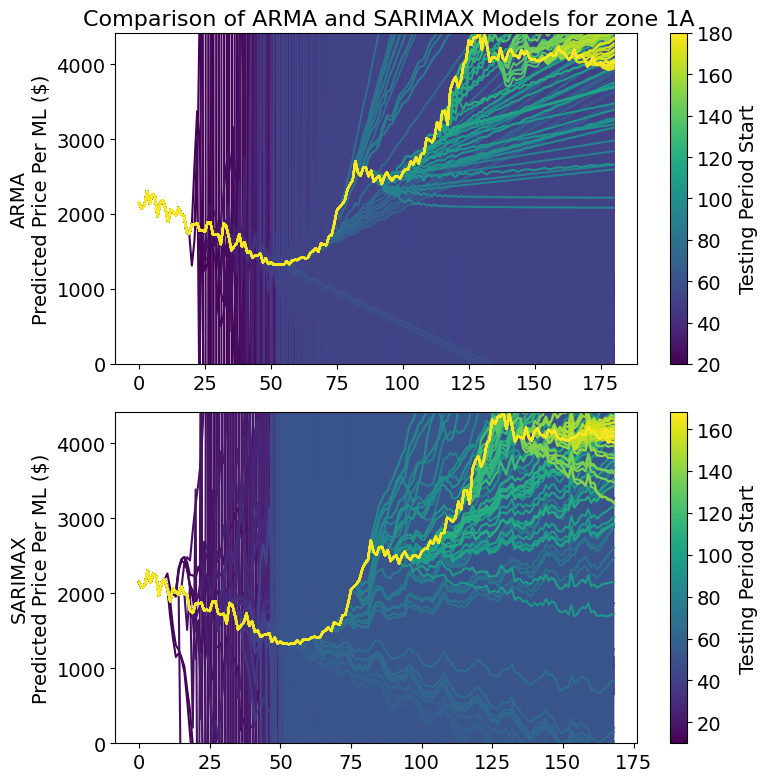

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'arma_price' and 'sarimax_price' are defined and the function 'read_and_plot' is properly implemented
arma_price = "ARMA Price"  # Ensure this variable is correctly assigned
sarimax_price = "SARIMAX Price"  # Ensure this variable is correctly assigned

def read_and_plot_every_fifth(dataset_name, ax, label=None, rank=False):
    df = pd.read_csv(dataset_name, index_col=0)
    # Select every 5th row from the DataFrame
    df = df.iloc[::1]  # Corrected to actually select every 5th row
    print(df.shape)

    if ax is not None:
        plot_dataset(df, ax)
        ax.set_ylabel(f"{label}\nPredicted Price Per ML ($)")


fig, axs = plt.subplots(2, 1, figsize=(8, 8))  # Create two subplots

# Read and plot only every 5th data point from the ARMA data on the first subplot
read_and_plot_every_fifth(f'{arma_price}.csv', ax=axs[0], label="ARMA", rank=True)

# Read and plot only every 5th data point from the SARIMAX data on the second subplot
read_and_plot_every_fifth(f'{sarimax_price}.csv', ax=axs[1], label="SARIMAX", rank=True)

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top of the subplots to make space for the title

fig.suptitle("Comparison of ARMA and SARIMAX Models for zone 1A", fontsize=16)  # Adding a subtitle


plt.show()  # Display the plot

(29141, 4)
(26871, 4)


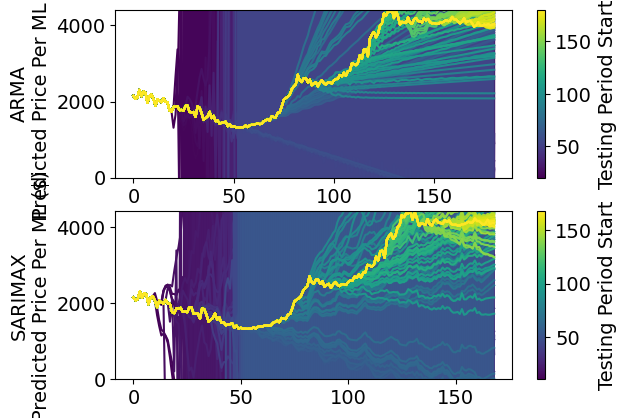

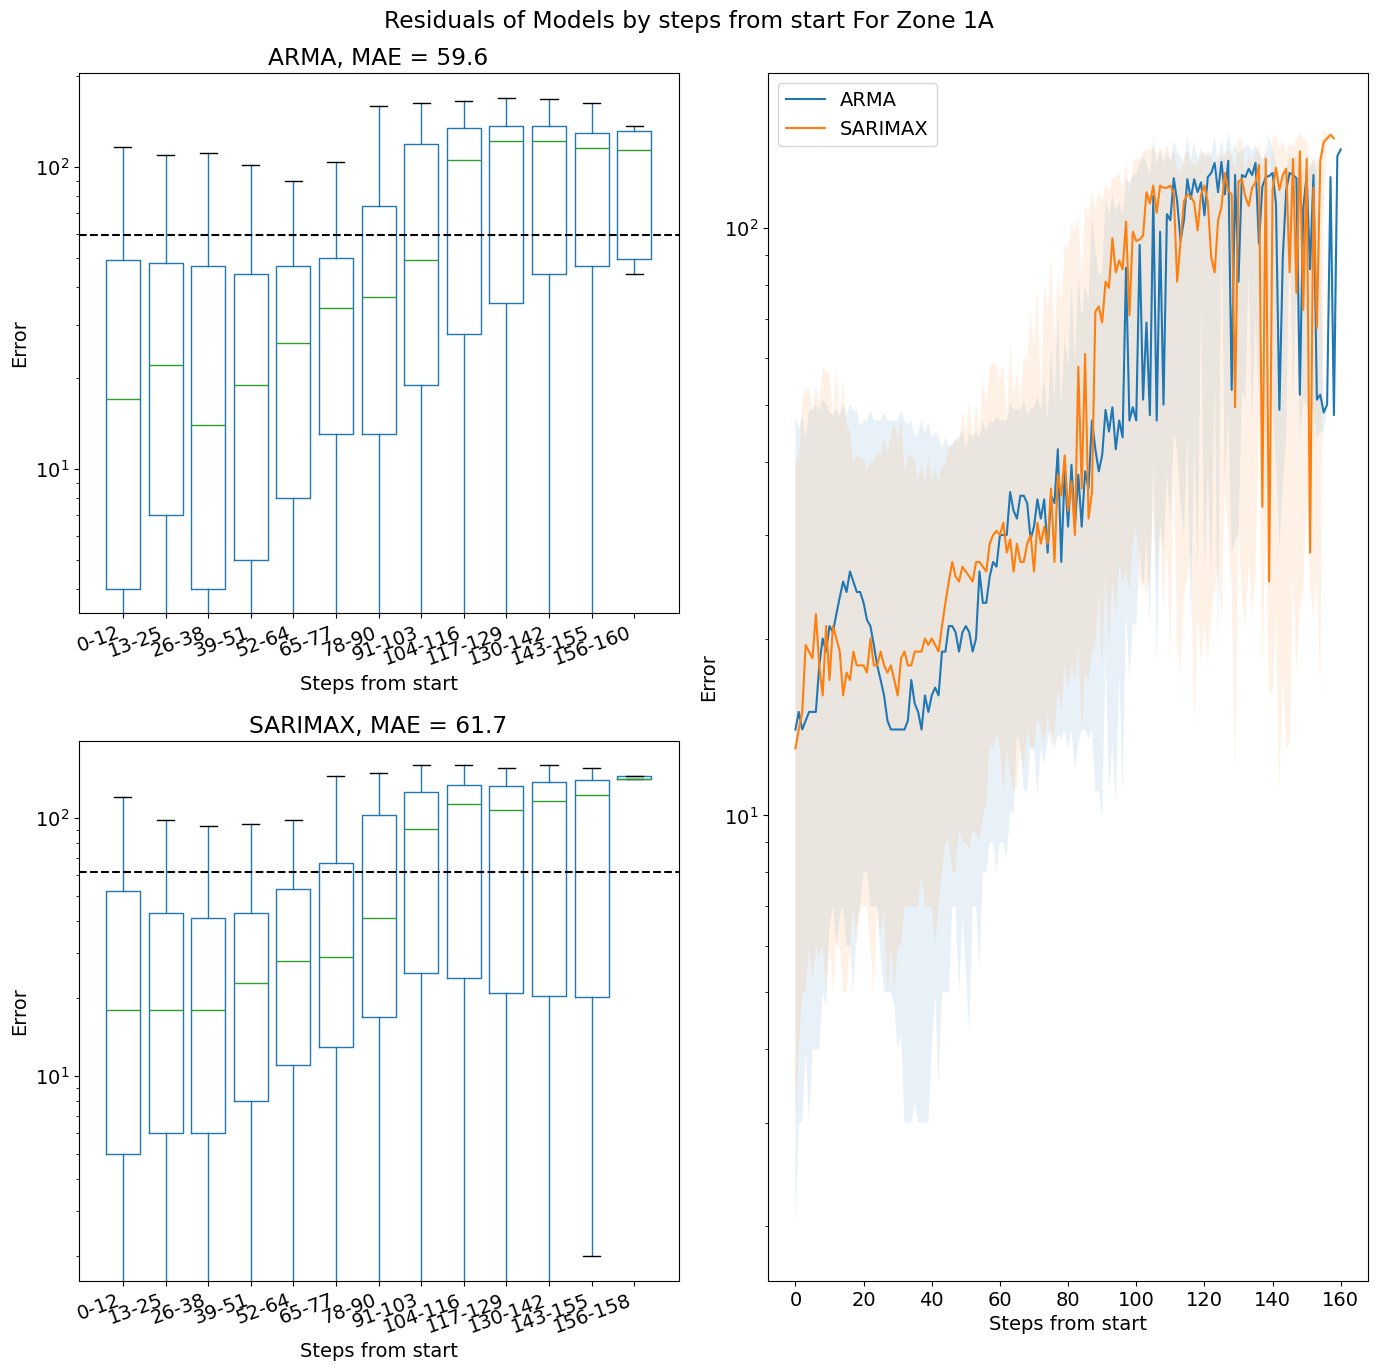

In [82]:
# Compare results in terms of ranking rather than value
fig, ax = plt.subplots(2)

#r_fig, resid_ax = plt.subplots(2, figsize=(10, 8))
r_fig, resid_ax = plt.subplot_mosaic([[0, 2], [1, 2]], figsize=(14, 14))

read_and_plot(f'{arma_price}.csv', ax[0], resid_ax[0], resid_ax[2], label="ARMA", rank=True)
ax[0].set_ylabel("ARMA\nPredicted Price Per ML ($)")

#USE RANK=TRUE to rank MAE rather than actual value
read_and_plot(f'{sarimax_price}.csv', ax[1], resid_ax[1], resid_ax[2], label="SARIMAX", rank=True)
ax[1].set_ylabel("SARIMAX\nPredicted Price Per ML ($)")

r_fig.tight_layout()
r_fig.suptitle("Residuals of Models by steps from start For Zone 1A")

resid_ax[2].legend()

## Positive Transformations

In [62]:
# Transform data before fitting model so that results are strictly positive

def transform_back(dataset_name, *args, func=scipy.special.inv_boxcox, **kwargs):
    df = pd.read_csv(f'{dataset_name}.csv', index_col=0)
    df[["lower", "upper", "value"]] = func(df[["lower", "upper", "value"]], *args, **kwargs)
    df.replace([-np.inf], 0, inplace=True)
    df.to_csv(f'{dataset_name}.csv')

def interval_constraint(data, a=10**4, b=0, inverse=False):
    if inverse:
        return a + np.exp(data)*(b-a)/(1+np.exp(data))
    
    return np.log((data-a)/(b-data))

def box_cox_model(data, kwargs):
    
    trans_data = scipy.stats.boxcox(data, lmbda=0)
    model = kwargs["model"]
    kargs = kwargs["kargs"]
    return model(data, **kwargs)

### Interval Constraint
Constrain the data to an interval by expanding the domain.

In [63]:
interval_arma = "ARMA interval"
trans_data = copy.deepcopy(new_data)
trans_data["Price Per ML ($)"] = interval_constraint(trans_data["Price Per ML ($)"])
make_dataset(trans_data, "Price Per ML ($)", interval_arma)


transform_back(interval_arma, inverse=True, func=interval_constraint)

KeyError: 'Price Per ML ($)'

In [ ]:
interval_sarimax = "SARIMAX interval"
trans_data = copy.deepcopy(new_data)
trans_data["Price Per ML ($)"] = interval_constraint(trans_data["Price Per ML ($)"])
make_dataset(trans_data, "Price Per ML ($)", interval_sarimax, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[:10])


transform_back(interval_sarimax, inverse=True, func=interval_constraint)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\

### Boxcox Transformation

In [ ]:
boxcox_sarimax = "SARIMAX boxcox"
make_dataset(np.log(new_data), "Price Per ML ($)", boxcox_sarimax, model_func=sm.tsa.statespace.SARIMAX, exog_cols=[*new_data.columns[:10], "Volume Traded (ML)"])
transform_back(boxcox_sarimax, 0)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend

In [ ]:
boxcox = "ARMA boxcox"
make_dataset(np.log(zone_data), "Price Per ML ($)", boxcox)
transform_back(boxcox, 0)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\

FileNotFoundError: [Errno 2] No such file or directory: 'ARMA boxcox'

## Comparison of results

In [ ]:
def compare_plots(fns, names, rank=True):
    fig, ax = plt.subplots(len(fns))
    r_fig, resid_ax = plt.subplot_mosaic([[n+1, 0] for n in range(len(fns))], figsize=(3*len(fns), 8))

    for i, (fn, name) in enumerate(zip(fns, names)):
        read_and_plot(fn, ax[i], resid_ax[i+1], resid_ax[0], label=name, rank=rank)
        ax[0].set_ylabel("Predicted Price Per ML ($)")
        ax[i].title.set_text(name)

    fig.tight_layout()
    r_fig.tight_layout()
    r_fig.suptitle("Residuals of Models by steps from start")

    resid_ax[0].legend()

(30600, 4)
(26544, 4)
(26544, 4)
(26544, 4)
(30600, 4)
(26544, 4)


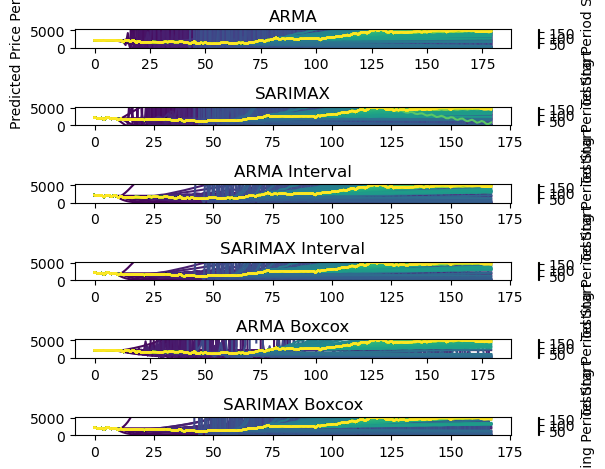

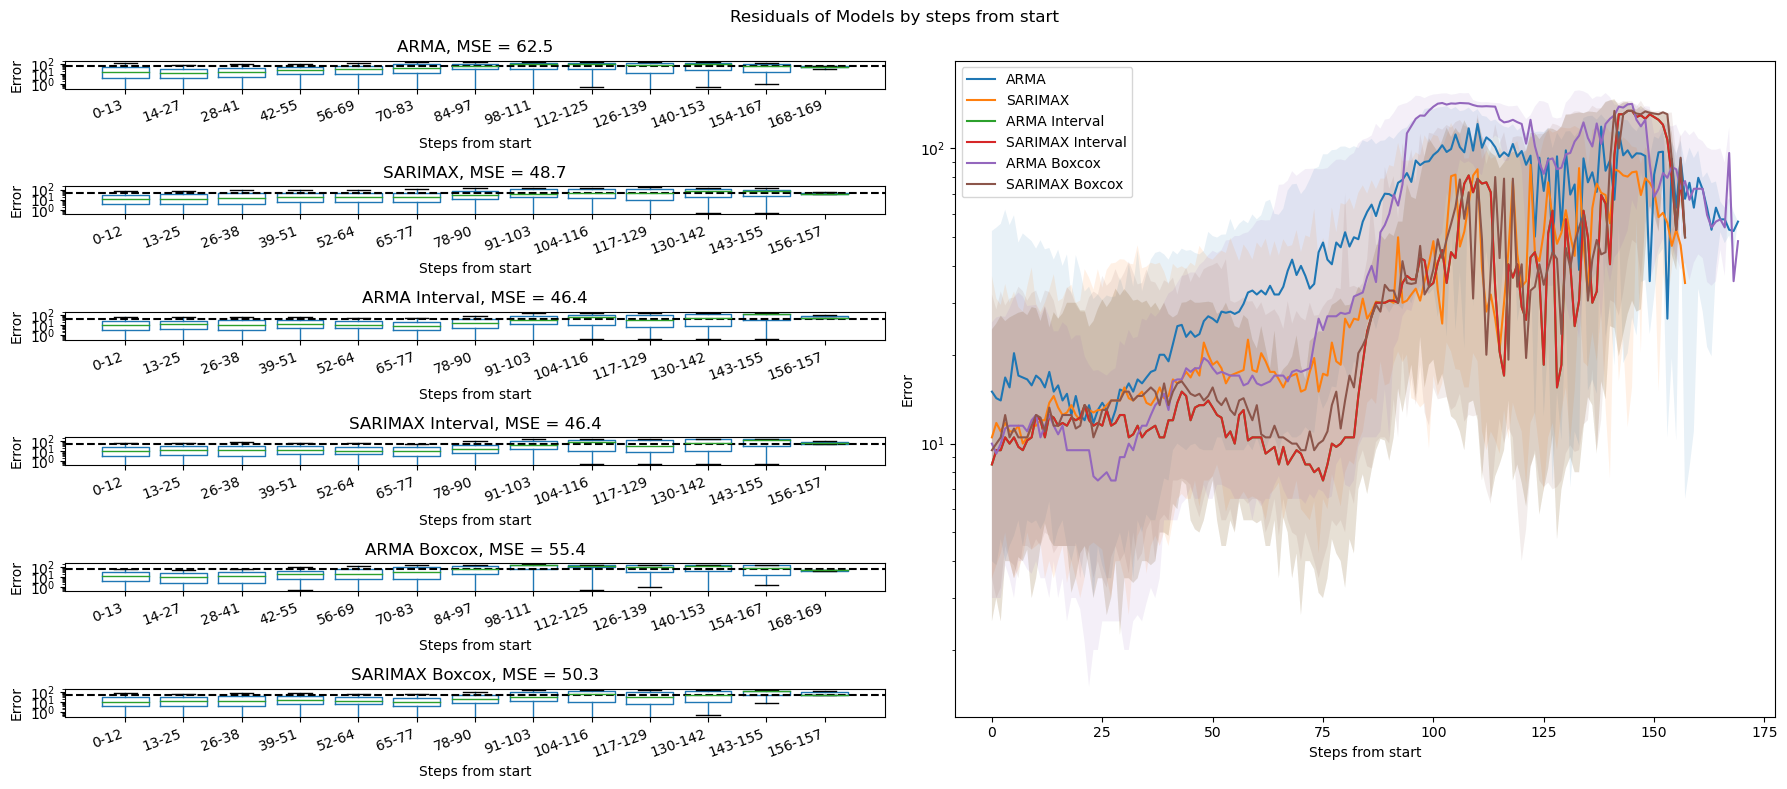

In [ ]:
compare_plots([f'{arma_price}.csv', f'{sarimax_price}.csv', f'{interval_arma}.csv', f'{interval_sarimax}.csv',  f'{boxcox}.csv', f'{boxcox_sarimax}.csv'], ["ARMA", "SARIMAX", "ARMA Interval", "SARIMAX Interval",  "ARMA Boxcox", "SARIMAX Boxcox"])

In [ ]:
annual_grouped = zone_data_6.groupby(pd.Grouper(key="Create_date", freq='6M'))
# Take the median of the monthly price
annual_zone_data =  annual_grouped[["Price Per ML ($)", "Volume Traded (ML)"]].median().fillna(0)
# Take the sum of the monthly volume traded
annual_zone_data["Volume Traded (ML)"] =annual_grouped["Volume Traded (ML)"].sum().fillna(0)



C:\Users\Meredith\AppData\Local\Temp\ipykernel_11324\1493650331.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  annual_grouped = zone_data_6.groupby(pd.Grouper(key="Create_date", freq='6M'))


In [ ]:
make_dataset(annual_zone_data, "Price Per ML ($)", "ARMA annual")

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\

In [ ]:
std_price = grouped[["Price Per ML ($)", "Volume Traded (ML)"]].std()

In [ ]:
make_dataset(std_price, "Price Per ML ($)", "ARMA std price")

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\

(30600, 4)
(651, 4)


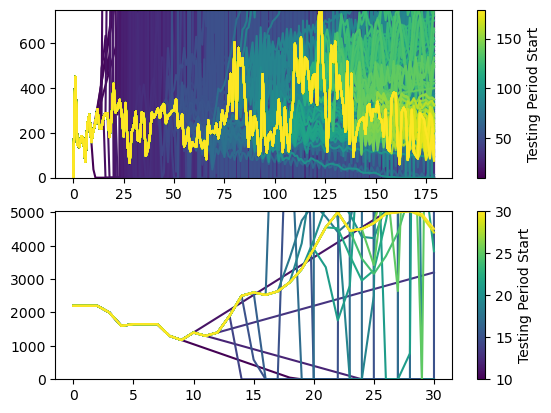

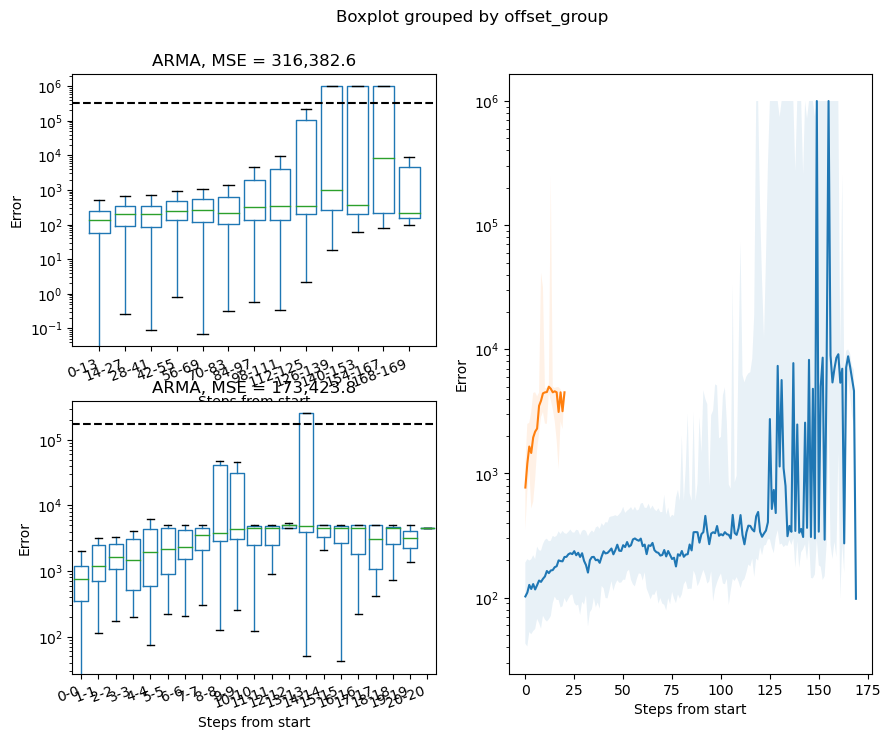

In [ ]:
fig, ax = plt.subplots(2)

#r_fig, resid_ax = plt.subplots(2, figsize=(10, 8))
r_fig, resid_ax = plt.subplot_mosaic([[0, 2], [1, 2]], figsize=(10, 8))

read_and_plot(f'ARMA std price.csv', ax[0], resid_ax[0], resid_ax[2], label="ARMA")

read_and_plot("ARMA annual.csv", ax[1], resid_ax[1], resid_ax[2], label="ARMA")

In [ ]:
ann_resampled = ann.assign(period = ann.index*6, start = ann.start*6)
ann_resampled_merge = pd.merge(ann_resampled, df, on=["start", "period"], how="outer", suffixes=(None, "y"))[ann_resampled.columns]
ann_resampled = ann_resampled_merge[np.in1d(ann_resampled_merge.start, ann_resampled.start)]

In [ ]:
std_arm = pd.read_csv("ARMA std price.csv")
std_arm

Unnamed: 0       lower       upper       value  start
0               0    0.000000    0.000000    0.000000     10
1               1    0.000000    0.000000  450.121196     10
2               2    0.000000    0.000000  147.501284     10
3               3    0.000000    0.000000  136.332593     10
4               4    0.000000    0.000000  185.040522     10
...           ...         ...         ...         ...    ...
30595         175    0.000000    0.000000  204.991289    179
30596         176    0.000000    0.000000  167.257287    179
30597         177    0.000000    0.000000   85.805012    179
30598         178    0.000000    0.000000  219.317122    179
30599         179 -133.568268  329.309717   97.870724    179

[30600 rows x 5 columns]

## Reading in predictions

In [ ]:
arma_price = "ARMA Price"
sarimax_price = "SARIMAX Price"

df = pd.read_csv(f"{sarimax_price}.csv", index_col=0)
df = MAEs(df)

In [ ]:
def initialise(df):
    df = df.assign(offset=df.index-df.start, period=df.index).reset_index()
    return df

In [ ]:
df = df.assign(offset=df.index-df.start, period=df.index).reset_index()

In [ ]:
import seaborn as sns

In [ ]:
#sns.displot(df.loc[(df.offset>0)&(df.offset<5)], x='error', hue='offset')

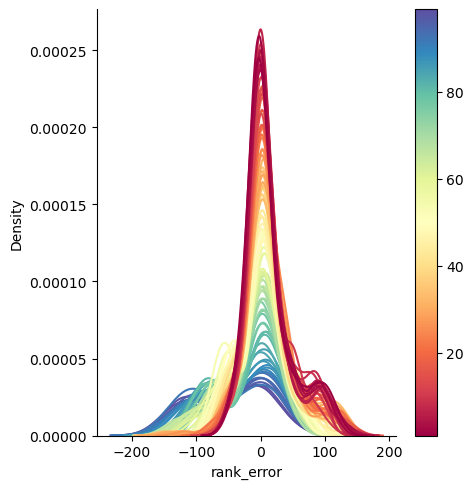

In [ ]:
offset_filter = (df.offset>0)&(df.offset<100)
hue = 'offset'
norm = plt.Normalize(df.loc[offset_filter, hue].min(), df.loc[offset_filter, hue].max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)


ax = sns.displot(df.loc[offset_filter], x='rank_error', hue=hue, kind='kde', palette='Spectral')
ax.legend.remove()

plt.colorbar(sm, ax=ax.axes[0][0])


In [ ]:
import matplotlib.animation

In [ ]:
frames[0]

1.0

In [ ]:
i = frames[10]
i = 5.4
(df.loc[df.offset==np.ceil(i)]*(i-np.floor(i))).reset_index() + ((np.ceil(i)-i)*df.loc[df.offset==np.floor(i), :][:-1]).reset_index()
#df.loc[df.offset==np.ceil(i)]*(i-np.floor(i)).add

level_0  index         lower         upper        value  start  \
0         31   15.4 -10656.393756  15056.393756  2200.000000   10.0   
1        393   16.4  -1731.037392   3911.037392  1090.000000   11.0   
2        755   17.4  -1115.997303   4475.997303  1680.000000   12.0   
3       1117   18.4    -67.520614   5547.520614  2740.000000   13.0   
4       1479   19.4   6211.299119   6221.851184  6216.575152   14.0   
..       ...    ...           ...           ...          ...    ...   
159    57589  174.4   4429.357255   5919.289538  5174.323397  169.0   
160    57951  175.4   4377.283792   5837.039989  5107.161891  170.0   
161    58313  176.4   4346.032728   5793.134589  5069.583658  171.0   
162    58675  177.4   4402.488764   5839.224600  5120.856682  172.0   
163    59037  178.4   4160.107414   5706.066195  4933.086805  173.0   

       Observed   Rank  Observed Rank        error  rank_error  offset  period  
0    2037.72300   91.5           63.4   162.277000        28.1     5.4    15.4  
1    1880.00000  163.6           58.2  -790.000000       105.4     5.4    16.4  
2    2000.00000  162.6           63.0  -320.000000        99.6     5.4    17.4  
3    1800.00000   19.4           49.6   940.000000       -30.2     5.4    18.4  
4    1660.00000   89.8           40.9  4556.575152        48.9     5.4    19.4  
..          ...    ...            ...          ...         ...     ...     ...  
159  4621.00000  171.0          147.8   553.323397        23.2     5.4   174.4  
160  4618.00000  171.8          147.2   489.161891        24.6     5.4   175.4  
161  4600.00000  168.6          144.5   469.583658        24.1     5.4   176.4  
162  4536.00000  176.2          137.5   584.856682        38.7     5.4   177.4  
163  4515.65145  155.8          135.4   417.435355        20.4     5.4   178.4  

[164 rows x 13 columns]

In [ ]:
i = 10.0
lower  = (np.ceil(i)-i)*df.loc[df.offset==np.floor(i), :]
upper = df.loc[df.offset==np.ceil(i)]*(i-np.floor(i))
data = (upper.set_index('period') + lower[:-1].set_index('period')).reset_index()

data

period  index  lower  upper  value  start  Observed  Rank  \
0         0.0    0.0   -0.0    0.0    0.0    0.0       0.0   0.0   
1         0.0    0.0   -0.0    0.0    0.0    0.0       0.0   0.0   
2         0.0    0.0   -0.0    0.0    0.0    0.0       0.0   0.0   
3         0.0    0.0   -0.0    0.0    0.0    0.0       0.0   0.0   
4         0.0    0.0    0.0    0.0    0.0    0.0       0.0   0.0   
...       ...    ...    ...    ...    ...    ...       ...   ...   
25435     0.0    0.0    0.0    0.0    0.0    0.0       0.0   0.0   
25436     0.0    0.0    0.0    0.0    0.0    0.0       0.0   0.0   
25437     0.0    0.0    0.0    0.0    0.0    0.0       0.0   0.0   
25438     0.0    0.0    0.0    0.0    0.0    0.0       0.0   0.0   
25439     0.0    0.0    0.0    0.0    0.0    0.0       0.0   0.0   

       Observed Rank  error  rank_error  offset  
0                0.0    0.0         0.0     0.0  
1                0.0    0.0         0.0     0.0  
2                0.0    0.0         0.0     0.0  
3                0.0    0.0         0.0     0.0  
4                0.0    0.0         0.0     0.0  
...              ...    ...         ...     ...  
25435            0.0    0.0         0.0     0.0  
25436            0.0    0.0         0.0     0.0  
25437            0.0    0.0         0.0     0.0  
25438            0.0    0.0         0.0     0.0  
25439            0.0    0.0         0.0     0.0  

[25440 rows x 12 columns]

True

MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\Meredith\AppData\Local\Temp\ipykernel_20544\1171238806.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(data, x='rank_error', hue=hue, fill=True, ax=ax)
C:\Users\Meredith\AppData\Local\Temp\ipykernel_20544\1171238806.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(data, x='rank_error', hue=hue, fill=True, ax=ax)


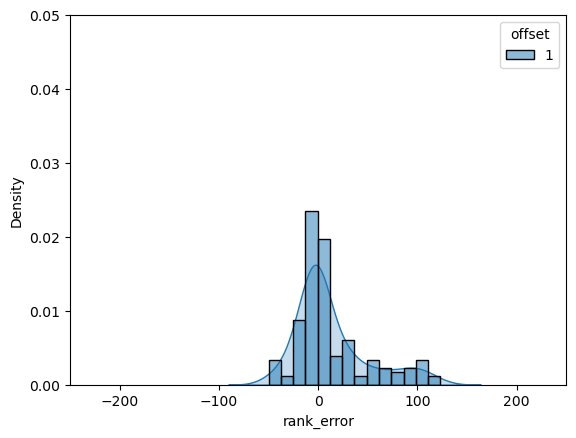

In [ ]:
fig, ax = plt.subplots()
g = sns.kdeplot(df.loc[df.offset==0, :], x='rank_error', hue=hue, fill=True, ax=ax)
b = sns.histplot(df.loc[df.offset==0, :], x='rank_error', hue=hue, fill=True, ax=ax, stat='density')
#g.data = df.loc[df.offset==30, :]
ax.set_xlim(-200, 200)
def animate(i):
    global g
    global b
    g.clear()
    b.clear()
    hue='offset'
    if not np.issubdtype(type(i), np.integer):
        if np.floor(i)==np.ceil(i):
            i = int(i)
        else:
            lower  = (np.ceil(i)-i)*df.loc[df.offset==np.floor(i), :]
            upper = df.loc[df.offset==np.ceil(i)]*(i-np.floor(i))
            data = (upper.reset_index() + lower[:-1].reset_index())
    if np.issubdtype(type(i), np.integer):
        data = df.loc[df.offset==i, :]

    g = sns.kdeplot(data, x='rank_error', hue=hue, fill=True, ax=ax)
    b = sns.histplot(data, x='rank_error', hue=hue, fill=True, ax=ax, stat='density')
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 0.05)

#g.facet_axis(0, 0).clear()


#g.legend.remove()


frames = np.arange(20)
frames = np.linspace(1, df.offset.max(), num=300)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, repeat=True)

ani.save('errorchange.gif')


In [ ]:
df.value.min()

-1.380891272598978e+117

In [ ]:
df.loc[offset_filter]

index         lower         upper        value  start     Observed  \
11        11  -2207.247631   6207.247631  2000.000000     10  1900.000000   
12        12  -4411.817367   8411.817367  2000.000000     10  1550.000000   
13        13  -6687.573032  10687.573032  2000.000000     10  1600.000000   
14        14  -9032.793902  13032.793902  2000.000000     10  1600.000000   
15        15 -11445.865133  15445.865133  2000.000000     10  1600.000000   
...      ...           ...           ...          ...    ...          ...   
26038    166   4396.558090   5351.703317  4874.130703    164  4630.000000   
26039    167   4226.194056   5306.905344  4766.549700    164  4499.970344   
26206    166   4241.088122   5090.833684  4665.960903    165  4630.000000   
26207    167   4075.376597   5046.605095  4560.990846    165  4499.970344   
26375    167   4149.303170   4995.698088  4572.500629    166  4499.970344   

        Rank  Observed Rank       error  rank_error  offset  period  
11      83.0           58.0  100.000000        25.0       1      11  
12      83.0           33.0  450.000000        50.0       2      12  
13      83.0           36.5  400.000000        46.5       3      13  
14      83.0           36.5  400.000000        46.5       4      14  
15      83.0           36.5  400.000000        46.5       5      15  
...      ...            ...         ...         ...     ...     ...  
26038  143.0          137.0  244.130703         6.0       2     166  
26039  138.0          118.0  266.579357        20.0       3     167  
26206  137.0          137.0   35.960903         0.0       1     166  
26207  133.0          118.0   61.020503        15.0       2     167  
26375  133.0          118.0   72.530285        15.0       1     167  

[10692 rows x 12 columns]

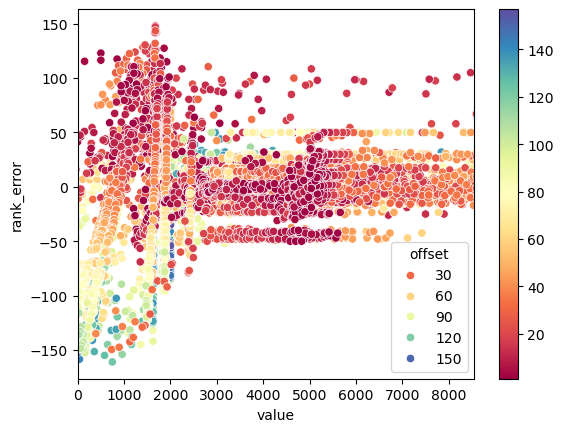

In [ ]:
offset_filter = (df.offset>0)#&(df.offset<100)
hue = 'offset'
norm = plt.Normalize(df.loc[offset_filter, hue].min(), df.loc[offset_filter, hue].max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)


ax = sns.scatterplot(df.loc[offset_filter, :], x='value', y='rank_error', hue=hue, palette='Spectral')
#ax.legend().remove()
plt.xlim(0, df.value.quantile(0.91))
plt.colorbar(sm, ax=ax.axes)


In [ ]:
scipy.stats.spearmanr(df.dropna().loc[offset_filter, 'value'], df.dropna().loc[offset_filter, 'rank_error'])
#scipy.stats.pearsonr(df.dropna().loc[offset_filter, 'value'], df.dropna().loc[offset_filter, 'rank_error'])

SignificanceResult(statistic=0.3955270624690879, pvalue=0.0)

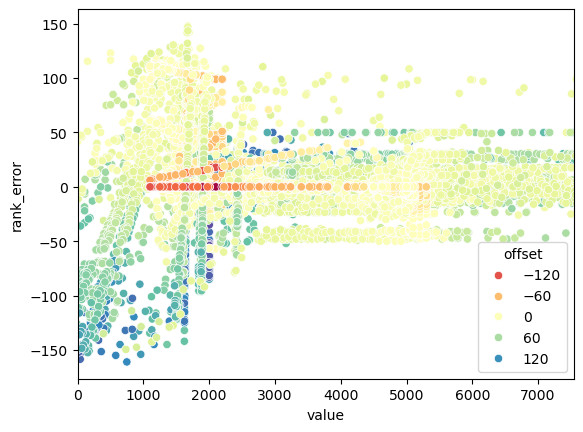

In [ ]:
#s = plt.scatter(df.value, df.rank_error, c=df.offset)
sns.scatterplot(df, x='value', y='rank_error', hue='offset', palette='Spectral')
plt.xlim(0, df.value.quantile(0.9))
#plt.xscale('symlog')
plt.colorbar(s)

In [ ]:
filtered_df = df[df.offset>0].dropna()

def correct_for_column(filtered_df, xcol='offset', ycol='rank_error', by='start', corrected_col = 'corrected_error'):
    start_fits = pd.DataFrame(index=filtered_df.start.unique(), columns=[by, 'slope', 'intercept', 'rvalue', 'pvalue', 'R2'])
    for start in filtered_df[by].unique():
        filter_ = filtered_df[by]==start
        res = scipy.stats.linregress(filtered_df.loc[filter_, xcol], filtered_df.loc[filter_, ycol])
        start_fits.loc[start, :] = [start, res.slope, res.intercept, res.rvalue, res.pvalue, res.rvalue**2]

    start_fits = start_fits.fillna(0)

    # Correct for influence of start
    filtered_df[corrected_col] = filtered_df[ycol] - (start_fits.loc[filtered_df[by], 'slope'].values*filtered_df[xcol] + start_fits.loc[filtered_df[by], 'intercept'].values)
    plot_error_fitting(start_fits)

    return filtered_df

def plot_error_fitting(start_fits):

    fig, ax = plt.subplots(len(start_fits.columns[1:]), sharex=True)

    for i, col in enumerate(start_fits.columns[1:]):
       # sns.boxplot(start_fits, y=col, showfliers=False, ax=ax[i])
       # yl = ax[i].get_ylim()
        sns.scatterplot(start_fits, x=start_fits.columns[0], y=col, ax=ax[i], hue='R2')
        alpha = 0.1
        #plt.ylim(start_fits.loc[:, col].quantile(alpha), start_fits.loc[:, col].quantile(1-alpha))
       # ax[i].set_ylim(yl)
        ax[i].get_legend().remove()

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\Meredith\AppData\Local\Temp\ipykernel_8216\1546334999.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  start_fits = start_fits.fillna(0)


index         lower         upper        value  start     Observed  \
11        11  -2207.247631   6207.247631  2000.000000     10  1900.000000   
12        12  -4411.817367   8411.817367  2000.000000     10  1550.000000   
13        13  -6687.573032  10687.573032  2000.000000     10  1600.000000   
14        14  -9032.793902  13032.793902  2000.000000     10  1600.000000   
15        15 -11445.865133  15445.865133  2000.000000     10  1600.000000   
...      ...           ...           ...          ...    ...          ...   
26038    166   4396.558090   5351.703317  4874.130703    164  4630.000000   
26039    167   4226.194056   5306.905344  4766.549700    164  4499.970344   
26206    166   4241.088122   5090.833684  4665.960903    165  4630.000000   
26207    167   4075.376597   5046.605095  4560.990846    165  4499.970344   
26375    167   4149.303170   4995.698088  4572.500629    166  4499.970344   

        Rank  Observed Rank       error  rank_error  offset  period  \
11      83.0           58.0  100.000000        25.0       1      11   
12      83.0           33.0  450.000000        50.0       2      12   
13      83.0           36.5  400.000000        46.5       3      13   
14      83.0           36.5  400.000000        46.5       4      14   
15      83.0           36.5  400.000000        46.5       5      15   
...      ...            ...         ...         ...     ...     ...   
26038  143.0          137.0  244.130703         6.0       2     166   
26039  138.0          118.0  266.579357        20.0       3     167   
26206  137.0          137.0   35.960903         0.0       1     166   
26207  133.0          118.0   61.020503        15.0       2     167   
26375  133.0          118.0   72.530285        15.0       1     167   

       corrected_error  
11          -48.944731  
12          -22.954749  
13          -25.464767  
14          -24.474784  
15          -23.484802  
...                ...  
26038        -4.000000  
26039         2.000000  
26206         0.000000  
26207         0.000000  
26375        15.000000  

[10421 rows x 13 columns]

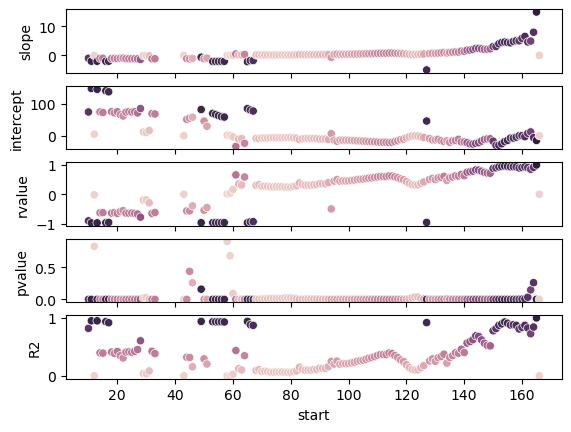

In [ ]:
correct_for_column(filtered_df)

In [ ]:
filtered_df

index         lower         upper        value  start     Observed  \
11        11  -2207.247631   6207.247631  2000.000000     10  1900.000000   
12        12  -4411.817367   8411.817367  2000.000000     10  1550.000000   
13        13  -6687.573032  10687.573032  2000.000000     10  1600.000000   
14        14  -9032.793902  13032.793902  2000.000000     10  1600.000000   
15        15 -11445.865133  15445.865133  2000.000000     10  1600.000000   
...      ...           ...           ...          ...    ...          ...   
26038    166   4396.558090   5351.703317  4874.130703    164  4630.000000   
26039    167   4226.194056   5306.905344  4766.549700    164  4499.970344   
26206    166   4241.088122   5090.833684  4665.960903    165  4630.000000   
26207    167   4075.376597   5046.605095  4560.990846    165  4499.970344   
26375    167   4149.303170   4995.698088  4572.500629    166  4499.970344   

        Rank  Observed Rank       error  rank_error  offset  period  \
11      83.0           58.0  100.000000        25.0       1      11   
12      83.0           33.0  450.000000        50.0       2      12   
13      83.0           36.5  400.000000        46.5       3      13   
14      83.0           36.5  400.000000        46.5       4      14   
15      83.0           36.5  400.000000        46.5       5      15   
...      ...            ...         ...         ...     ...     ...   
26038  143.0          137.0  244.130703         6.0       2     166   
26039  138.0          118.0  266.579357        20.0       3     167   
26206  137.0          137.0   35.960903         0.0       1     166   
26207  133.0          118.0   61.020503        15.0       2     167   
26375  133.0          118.0   72.530285        15.0       1     167   

       corrected_error  
11          -48.944731  
12          -22.954749  
13          -25.464767  
14          -24.474784  
15          -23.484802  
...                ...  
26038        -4.000000  
26039         2.000000  
26206         0.000000  
26207         0.000000  
26375        15.000000  

[10421 rows x 13 columns]

In [ ]:
start_fits.slope.quantile(0.01)

-1.252033397959066e+18

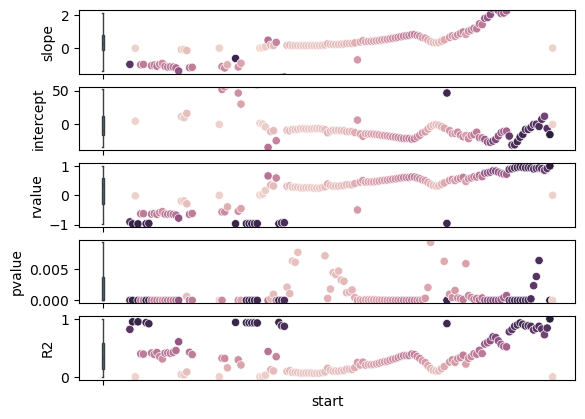

<AxesSubplot: xlabel='offset', ylabel='rank_error'>

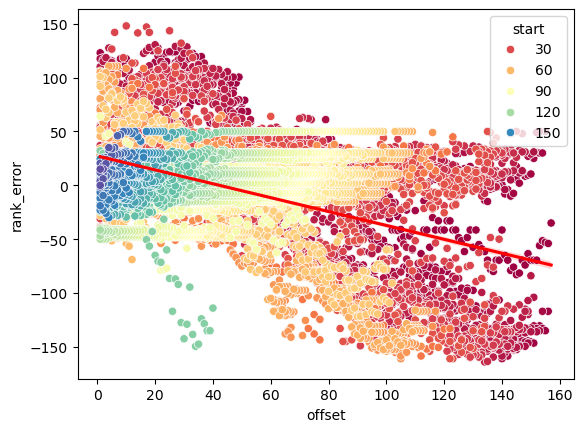

In [ ]:
sns.regplot((filtered_df), x='offset', y='rank_error', logx=False, line_kws=dict(color="r"),scatter=False)
sns.scatterplot((filtered_df), x='offset', y='rank_error', hue='start', palette='Spectral')


In [ ]:
filtered_df['scaled_rank_error'] = filtered_df['rank_error']/(filtered_df.start.max()-filtered_df.start)

In [ ]:
df[df.offset==-1].set_index('start')

index  lower  upper   value  Observed   Rank  Observed Rank  error  \
start                                                                       
10         9    0.0    0.0  2000.0    2000.0   83.0           62.5    0.0   
11        10    0.0    0.0  1500.0    1500.0  158.0           29.5    0.0   
12        11    0.0    0.0  1900.0    1900.0    4.0           58.0    0.0   
13        12    0.0    0.0  1550.0    1550.0  157.0           33.0    0.0   
14        13    0.0    0.0  1600.0    1600.0   80.0           36.5    0.0   
...      ...    ...    ...     ...       ...    ...            ...    ...   
163      162    0.0    0.0  5000.0    5000.0  148.5          152.5    0.0   
164      163    0.0    0.0  4700.0    4700.0  135.0          139.0    0.0   
165      164    0.0    0.0  4600.0    4600.0  135.5          134.5    0.0   
166      165    0.0    0.0  4615.0    4615.0  136.0          136.0    0.0   
167      166    0.0    0.0  4630.0    4630.0  137.0          137.0    0.0   

       rank_error  offset  period  scaled_rank_error   Start Rank  Higher  \
start                                                                       
10           20.5      -1       9           0.130573  2000.000000   False   
11          128.5      -1      10           0.823718  1000.000000    True   
12          -54.0      -1      11          -0.348387  2300.000000   False   
13          124.0      -1      12           0.805195  1200.000000    True   
14           43.5      -1      13           0.284314   471.537282    True   
...           ...     ...     ...                ...          ...     ...   
163          -4.0      -1     162          -1.000000  4991.579357    True   
164          -4.0      -1     163          -1.333333  4865.744762   False   
165           1.0      -1     164           0.500000  4591.869420    True   
166           0.0      -1     165           0.000000  4681.747182   False   
167           0.0      -1     166                NaN  4499.970344    True   

       Start Observed Rank  Observed Higher  
start                                        
10             1500.000000             True  
11             1900.000000            False  
12             1550.000000             True  
13             1600.000000            False  
14             1600.000000            False  
...                    ...              ...  
163            4700.000000             True  
164            4600.000000             True  
165            4615.000000            False  
166            4630.000000            False  
167            4499.970344             True  

[158 rows x 16 columns]

In [ ]:
def compare_start(df, col='Rank', colname="Start Rank", higher_col = "Higher", filter_=None):
    df[colname] = df.start
    df[colname] = df[colname].map(df[df.offset==-1].set_index('start')[col])

    if filter_ is None:
        filter_ = df.index
    df[higher_col] = df[col] > df[colname]

    return df

In [ ]:
_ = compare_start(df, "value")
_ = compare_start(df, "Observed", "Start Observed Rank", "Observed Higher")

In [ ]:
def plot_expected(df, upper, x='Observed Higher', y='Higher', hue='Start Observed Rank', ax=None):
    if ax is None:
        ax = plt.gca()
    filter_ = (df.offset >= 0) & (df.offset < upper) 
    sns.scatterplot(data = df[filter_].groupby('start').mean(), x=x, y=y, hue=hue, ax=ax)
    sns.regplot(data = df[filter_].groupby('start').mean(), x=x, y=y, scatter=False, ax=ax)

    ax.plot([0, 1], [0, 1])

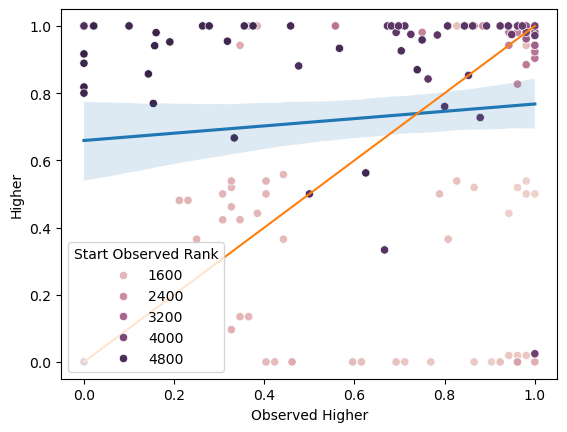

In [ ]:
plot_expected(df, lookahead)

In [ ]:
filter_ = (df.offset>=0)&(~df.Higher)
sar_vol[filter_].groupby('start').sum()['value'] #- sv.loc[df.offset==-1, 'value'].values

start
10      3.641433e+06
11      1.151247e+07
13      4.530095e+06
14    -4.271577e+158
15     -1.993865e+24
           ...      
159     2.305745e+02
163     4.203054e+02
165     5.238512e+02
166     4.755776e+02
167     4.859536e+02
Name: value, Length: 101, dtype: float64

In [ ]:
sar_vol

index        lower        upper        value  start  offset  period  \
0          0     0.000000     0.000000  1885.900000     10     -10       0   
1          1     0.000000     0.000000   613.800000     10      -9       1   
2          2     0.000000     0.000000   670.000000     10      -8       2   
3          3     0.000000     0.000000   980.900000     10      -7       3   
4          4     0.000000     0.000000   233.300000     10      -6       4   
...      ...          ...          ...          ...    ...     ...     ...   
26539    163     0.000000     0.000000   128.200000    167      -4     163   
26540    164     0.000000     0.000000    50.500000    167      -3     164   
26541    165     0.000000     0.000000   561.700000    167      -2     165   
26542    166     0.000000     0.000000   526.700000    167      -1     166   
26543    167 -1639.415864  1291.415956   485.953616    167       0     167   

         Observed  Rank  Observed Rank  
0             NaN  12.0            NaN  
1             NaN   4.0            NaN  
2             NaN   5.0            NaN  
3             NaN   7.0            NaN  
4             NaN   2.0            NaN  
...           ...   ...            ...  
26539  128.200000  12.0           12.0  
26540   50.500000   7.0            7.0  
26541  561.700000  62.0           62.0  
26542  526.700000  54.0           54.0  
26543  485.953616  49.0           49.0  

[26544 rows x 10 columns]

In [ ]:
filter_ = (df.offset>=0)&(~df["Observed Higher"])
sar_vol[filter_].groupby('start').sum()['Observed']

start
10       0.000000
11       0.000000
12       0.000000
13       0.000000
14       0.000000
          ...    
163      0.000000
164      0.000000
165      0.000000
166      0.000000
167    485.953616
Name: Observed, Length: 138, dtype: float64

In [ ]:
sar_vol = MAEs(sar_vol.set_index('index'))

KeyError: "None of ['index'] are in the columns"

In [ ]:
new_data["Volume Cheaper"] = 0
for start in range(len(new_data.index)):
    start_data = new_data.iloc[start:]
    new_data.loc[new_data.index[start], "Volume Cheaper"] = start_data.where(start_data["Price Per ML ($)"]<start_data.iloc[0]["Price Per ML ($)"])["Volume Traded (ML)"].sum()
    

C:\Users\Meredith\AppData\Local\Temp\ipykernel_8216\73080147.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '107708.29999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[new_data.index[start], "Volume Cheaper"] = start_data.where(start_data["Price Per ML ($)"]<start_data.iloc[0]["Price Per ML ($)"])["Volume Traded (ML)"].sum()


<AxesSubplot: ylabel='Volume Cheaper'>

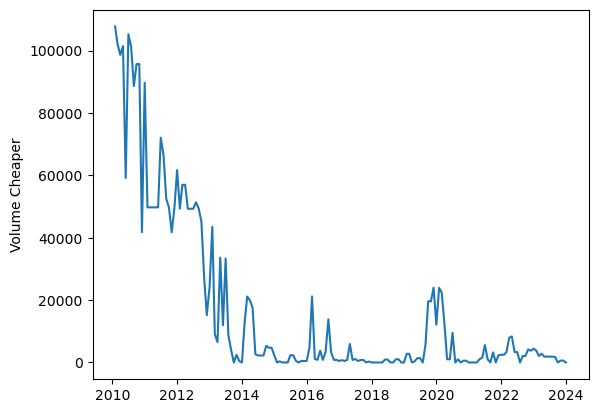

In [ ]:
sns.lineplot(new_data["Volume Cheaper"])

In [ ]:
sv[filter_].groupby('start').sum()

Unnamed: 0  index          lower          upper          value  offset  \
start                                                                           
10          13983  13983  -1.963831e+08   2.033177e+08   3.641433e+06   12403   
11          40349  13973  -1.790423e+08   2.017220e+08   1.151247e+07   12246   
12          66378  13962  -1.943574e+08   1.832133e+08  -5.400855e+06   12090   
13          92070  13950  -1.781378e+08   1.868587e+08   4.530095e+06   11935   
14         117425  13937 -3.456327e+154 -3.020564e+154  4.036909e+159   11781   
...           ...    ...            ...            ...            ...     ...   
163        129345    825  -8.659561e+03   6.483866e+03   2.170929e+03      10   
164        104150    662  -7.032335e+03   5.036978e+03   1.629414e+03       6   
165         78618    498  -5.630223e+03   3.374927e+03   8.394908e+02       3   
166         52749    333  -3.397244e+03   2.561741e+03   8.936742e+02       1   
167         26543    167  -1.639416e+03   1.291416e+03   4.859536e+02       0   

       period  
start          
10      13983  
11      13973  
12      13962  
13      13950  
14      13937  
...       ...  
163       825  
164       662  
165       498  
166       333  
167       167  

[158 rows x 7 columns]

In [ ]:
sv[~df.Higher]

Unnamed: 0  index        lower        upper        value  start  \
2               2      2     0.000000     0.000000   670.000000     10   
4               4      4     0.000000     0.000000   233.300000     10   
7               7      7     0.000000     0.000000  2690.700000     10   
8               8      8     0.000000     0.000000   212.300000     10   
9               9      9     0.000000     0.000000   499.600000     10   
...           ...    ...          ...          ...          ...    ...   
26526       26526    150     0.000000     0.000000   602.000000    167   
26540       26540    164     0.000000     0.000000    50.500000    167   
26541       26541    165     0.000000     0.000000   561.700000    167   
26542       26542    166     0.000000     0.000000   526.700000    167   
26543       26543    167 -1639.415864  1291.415956   485.953616    167   

       offset  period  
2          -8       2  
4          -6       4  
7          -3       7  
8          -2       8  
9          -1       9  
...       ...     ...  
26526     -17     150  
26540      -3     164  
26541      -2     165  
26542      -1     166  
26543       0     167  

[16539 rows x 8 columns]

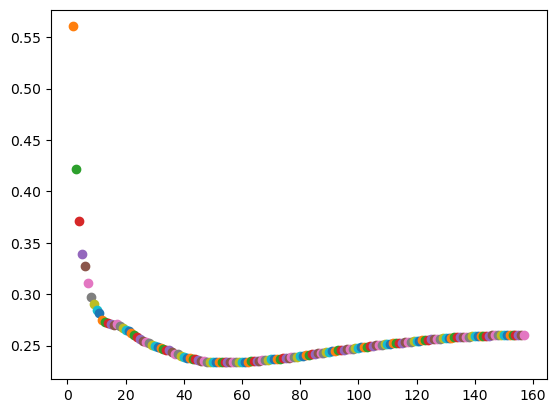

In [ ]:
uppers = df[df.offset>0].offset.unique()
MSE = np.zeros_like(uppers, dtype=np.float32)
for i, upper in enumerate(uppers):
    filter_ = (df.offset > 0) & (df.offset < upper) 

    data = df[filter_].groupby('start').mean()
    x='Observed Higher'
    y = 'Higher'

    #plt.scatter(upper, np.mean((data[y]-data[x])**2))
    MSE[i] = np.mean((data[y]-data[x])**2)

lookahead = uppers[np.nanargmin(MSE)]
sns.scatterplot(x=uppers, y=MSE)

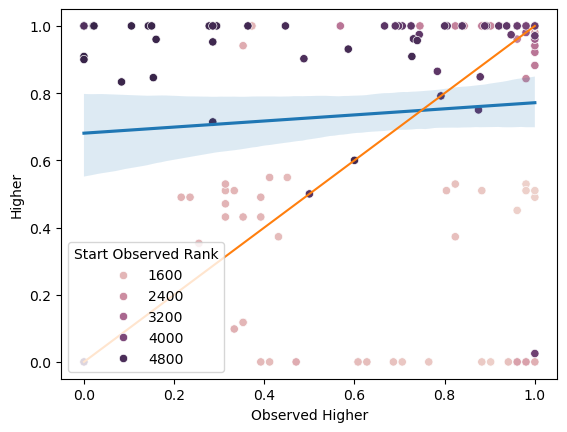

In [ ]:
plot_expected(df, lookahead)

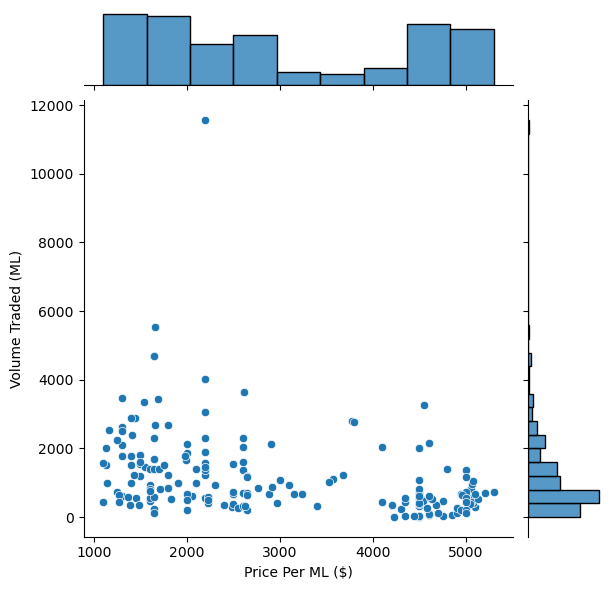

In [ ]:
sns.jointplot(data=zone_data, x='Price Per ML ($)', y='Volume Traded (ML)')

<AxesSubplot: xlabel='Create_date', ylabel='Volume Traded (ML)'>

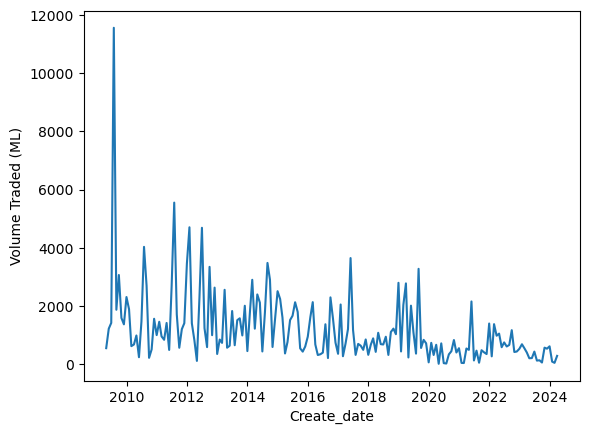

In [ ]:
sns.lineplot(zone_data, x=zone_data.index, y="Volume Traded (ML)")

In [ ]:
scipy.stats.spearmanr(zone_data["Volume Traded (ML)"], zone_data.reset_index().index)

SignificanceResult(statistic=-0.4997101246490392, pvalue=9.24301794523153e-13)

In [ ]:
scipy.stats.pearsonr(new_data["Volume Traded (ML)"], new_data["Price Per ML ($)"])

PearsonRResult(statistic=-0.3996911704042021, pvalue=7.991092622036928e-08)

In [ ]:

res = scipy.stats.linregress(new_data["Price Per ML ($)"], new_data["Volume Traded (ML)"])

# SARIMAX Volume

In [ ]:
# Create a new file called SARIMAX Volume
sarimax_volume = "SARIMAX Volume"
# Make it a SARIMAX model by passing the SARIMAX function and columns to be used as exogenous data
make_dataset(new_data, "Volume Traded (ML)", sarimax_volume, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[:10])

Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':    Principal Component 1  Principal Component 2  Principal Component 3  \
0             -19.209868               9.529664               7.242644   
1             -17.120963              10.422646               6.059921   
2             -17.528443               6.115125               3.454696   
3             -11.297777               3.410159              -3.450176   
4              -7.291097              -8.415412             -10.209559   
5              -1.178409             -17.113855             -13.098566   
6              -1.374557             -20.663087             -11.933711   
7              26.074695             -20.775953              -6.100031   
8               3.226955             -14.164411               5.381938   
9               7.431749              -2.956970               3.375807   

   Principal Component 4  Principal Component 5  Principal Component 6  \
0              15.392027         

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\

Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
5               -1.178409             -17.113855             -13.098566   
6               -1.374557             -20.663087             -11.933711   
7               26.074695             -20.775953              -6.100031   
8                3.226955             -14.164411               5.381938   
9                7.431749              -2.956970               3.375807   
10               1.184236               4.638448              14.340095   
11               8.472

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
56              -3.577739              -8.460588              -4.723288   
57             -11.115282              -1.052615               2.211734   
58             -15.118780               5.600212               5.180267   
59             -14.530280              11.020692               6.199321   
60             -16.102333              12.810549               4.881818   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
57             -11.115282              -1.052615               2.211734   
58             -15.118780               5.600212               5.180267   
59             -14.530280              11.020692               6.199321   
60             -16.102333              12.810549               4.881818   
61             -19.031050              11.866388               6.909822   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
58             -15.118780               5.600212               5.180267   
59             -14.530280              11.020692               6.199321   
60             -16.102333              12.810549               4.881818   
61             -19.031050              11.866388               6.909822   
62             -16.857795               5.470305               1.729834   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
59             -14.530280              11.020692               6.199321   
60             -16.102333              12.810549               4.881818   
61             -19.031050              11.866388               6.909822   
62             -16.857795               5.470305               1.729834   
63             -11.600026              -3.453457              -5.305551   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
60             -16.102333              12.810549               4.881818   
61             -19.031050              11.866388               6.909822   
62             -16.857795               5.470305               1.729834   
63             -11.600026              -3.453457              -5.305551   
64              -0.988744              -5.305748             -12.050051   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
61             -19.031050              11.866388               6.909822   
62             -16.857795               5.470305               1.729834   
63             -11.600026              -3.453457              -5.305551   
64              -0.988744              -5.305748             -12.050051   
65              -4.883044             -16.258248             -11.861981   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
62             -16.857795               5.470305               1.729834   
63             -11.600026              -3.453457              -5.305551   
64              -0.988744              -5.305748             -12.050051   
65              -4.883044             -16.258248             -11.861981   
66               0.833956             -16.019503             -14.601023   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
63             -11.600026              -3.453457              -5.305551   
64              -0.988744              -5.305748             -12.050051   
65              -4.883044             -16.258248             -11.861981   
66               0.833956             -16.019503             -14.601023   
67               1.618539             -16.394590              -8.387143   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
64              -0.988744              -5.305748             -12.050051   
65              -4.883044             -16.258248             -11.861981   
66               0.833956             -16.019503             -14.601023   
67               1.618539             -16.394590              -8.387143   
68              -7.313820             -10.309166              -4.306115   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
65              -4.883044             -16.258248             -11.861981   
66               0.833956             -16.019503             -14.601023   
67               1.618539             -16.394590              -8.387143   
68              -7.313820             -10.309166              -4.306115   
69             -13.674650               1.022131               2.526457   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
66               0.833956             -16.019503             -14.601023   
67               1.618539             -16.394590              -8.387143   
68              -7.313820             -10.309166              -4.306115   
69             -13.674650               1.022131               2.526457   
70             -14.059961               7.623784               2.772783   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
67               1.618539             -16.394590              -8.387143   
68              -7.313820             -10.309166              -4.306115   
69             -13.674650               1.022131               2.526457   
70             -14.059961               7.623784               2.772783   
71             -19.068738               9.964433               6.123438   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
68              -7.313820             -10.309166              -4.306115   
69             -13.674650               1.022131               2.526457   
70             -14.059961               7.623784               2.772783   
71             -19.068738               9.964433               6.123438   
72             -18.795841              12.793523               5.608820   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
69             -13.674650               1.022131               2.526457   
70             -14.059961               7.623784               2.772783   
71             -19.068738               9.964433               6.123438   
72             -18.795841              12.793523               5.608820   
73             -20.560057              10.509711               6.004803   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
70             -14.059961               7.623784               2.772783   
71             -19.068738               9.964433               6.123438   
72             -18.795841              12.793523               5.608820   
73             -20.560057              10.509711               6.004803   
74             -18.120374               9.723128               1.895403   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
71             -19.068738               9.964433               6.123438   
72             -18.795841              12.793523               5.608820   
73             -20.560057              10.509711               6.004803   
74             -18.120374               9.723128               1.895403   
75             -15.365013               1.355920              -3.546076   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
72             -18.795841              12.793523               5.608820   
73             -20.560057              10.509711               6.004803   
74             -18.120374               9.723128               1.895403   
75             -15.365013               1.355920              -3.546076   
76              -9.312376              -5.151013              -8.854791   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
73             -20.560057              10.509711               6.004803   
74             -18.120374               9.723128               1.895403   
75             -15.365013               1.355920              -3.546076   
76              -9.312376              -5.151013              -8.854791   
77               7.313672              -9.725572              -9.860292   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
74             -18.120374               9.723128               1.895403   
75             -15.365013               1.355920              -3.546076   
76              -9.312376              -5.151013              -8.854791   
77               7.313672              -9.725572              -9.860292   
78              17.857166             -23.560874              -0.725380   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
75             -15.365013               1.355920              -3.546076   
76              -9.312376              -5.151013              -8.854791   
77               7.313672              -9.725572              -9.860292   
78              17.857166             -23.560874              -0.725380   
79               9.984401             -18.260197              -0.051719   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
76              -9.312376              -5.151013              -8.854791   
77               7.313672              -9.725572              -9.860292   
78              17.857166             -23.560874              -0.725380   
79               9.984401             -18.260197              -0.051719   
80              32.186607              -4.608391              13.826036   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
77               7.313672              -9.725572              -9.860292   
78              17.857166             -23.560874              -0.725380   
79               9.984401             -18.260197              -0.051719   
80              32.186607              -4.608391              13.826036   
81              24.120778             -11.252842              22.282122   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
78              17.857166             -23.560874              -0.725380   
79               9.984401             -18.260197              -0.051719   
80              32.186607              -4.608391              13.826036   
81              24.120778             -11.252842              22.282122   
82              -5.313246               2.150110              11.713348   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
79               9.984401             -18.260197              -0.051719   
80              32.186607              -4.608391              13.826036   
81              24.120778             -11.252842              22.282122   
82              -5.313246               2.150110              11.713348   
83             -12.859097               8.711018               8.845262   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
80              32.186607              -4.608391              13.826036   
81              24.120778             -11.252842              22.282122   
82              -5.313246               2.150110              11.713348   
83             -12.859097               8.711018               8.845262   
84             -18.450412              12.134706               9.685988   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
81              24.120778             -11.252842              22.282122   
82              -5.313246               2.150110              11.713348   
83             -12.859097               8.711018               8.845262   
84             -18.450412              12.134706               9.685988   
85             -19.102677               8.710437               6.918633   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
82              -5.313246               2.150110              11.713348   
83             -12.859097               8.711018               8.845262   
84             -18.450412              12.134706               9.685988   
85             -19.102677               8.710437               6.918633   
86             -17.220101              11.114113               5.065442   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
83             -12.859097               8.711018               8.845262   
84             -18.450412              12.134706               9.685988   
85             -19.102677               8.710437               6.918633   
86             -17.220101              11.114113               5.065442   
87             -15.341341               0.919037              -1.127182   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
84             -18.450412              12.134706               9.685988   
85             -19.102677               8.710437               6.918633   
86             -17.220101              11.114113               5.065442   
87             -15.341341               0.919037              -1.127182   
88             -10.050313              -8.417329              -7.489799   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
85             -19.102677               8.710437               6.918633   
86             -17.220101              11.114113               5.065442   
87             -15.341341               0.919037              -1.127182   
88             -10.050313              -8.417329              -7.489799   
89              -7.994826             -15.439442             -12.517510   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
86             -17.220101              11.114113               5.065442   
87             -15.341341               0.919037              -1.127182   
88             -10.050313              -8.417329              -7.489799   
89              -7.994826             -15.439442             -12.517510   
90              -3.000940             -13.997518             -13.675390   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
87             -15.341341               0.919037              -1.127182   
88             -10.050313              -8.417329              -7.489799   
89              -7.994826             -15.439442             -12.517510   
90              -3.000940             -13.997518             -13.675390   
91               6.681169             -13.269742              -9.379889   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
88             -10.050313              -8.417329              -7.489799   
89              -7.994826             -15.439442             -12.517510   
90              -3.000940             -13.997518             -13.675390   
91               6.681169             -13.269742              -9.379889   
92               3.424383             -12.155449              -5.452365   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
89              -7.994826             -15.439442             -12.517510   
90              -3.000940             -13.997518             -13.675390   
91               6.681169             -13.269742              -9.379889   
92               3.424383             -12.155449              -5.452365   
93              -5.671417               0.739871               0.993375   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
90              -3.000940             -13.997518             -13.675390   
91               6.681169             -13.269742              -9.379889   
92               3.424383             -12.155449              -5.452365   
93              -5.671417               0.739871               0.993375   
94             -13.576906              11.343937               4.049201   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
91               6.681169             -13.269742              -9.379889   
92               3.424383             -12.155449              -5.452365   
93              -5.671417               0.739871               0.993375   
94             -13.576906              11.343937               4.049201   
95              -8.161526               9.944463               9.825050   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
92               3.424383             -12.155449              -5.452365   
93              -5.671417               0.739871               0.993375   
94             -13.576906              11.343937               4.049201   
95              -8.161526               9.944463               9.825050   
96             -19.135841              12.146965               8.549412   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
93              -5.671417               0.739871               0.993375   
94             -13.576906              11.343937               4.049201   
95              -8.161526               9.944463               9.825050   
96             -19.135841              12.146965               8.549412   
97             -19.986923               9.898269               6.982014   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
94             -13.576906              11.343937               4.049201   
95              -8.161526               9.944463               9.825050   
96             -19.135841              12.146965               8.549412   
97             -19.986923               9.898269               6.982014   
98             -19.345490               6.258230               4.449554   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':     Principal Component 1  Principal Component 2  Principal Component 3  \
0              -19.209868               9.529664               7.242644   
1              -17.120963              10.422646               6.059921   
2              -17.528443               6.115125               3.454696   
3              -11.297777               3.410159              -3.450176   
4               -7.291097              -8.415412             -10.209559   
..                    ...                    ...                    ...   
95              -8.161526               9.944463               9.825050   
96             -19.135841              12.146965               8.549412   
97             -19.986923               9.898269               6.982014   
98             -19.345490               6.258230               4.449554   
99             -15.697896              -1.620784              -1.214522   

    Principal Compone

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
96              -19.135841              12.146965               8.549412   
97              -19.986923               9.898269               6.982014   
98              -19.345490               6.258230               4.449554   
99              -15.697896              -1.620784              -1.214522   
100              -7.473865              -6.516207             -10.050267   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
97              -19.986923               9.898269               6.982014   
98              -19.345490               6.258230               4.449554   
99              -15.697896              -1.620784              -1.214522   
100              -7.473865              -6.516207             -10.050267   
101              -4.642211             -13.331050             -13.086167   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
98              -19.345490               6.258230               4.449554   
99              -15.697896              -1.620784              -1.214522   
100              -7.473865              -6.516207             -10.050267   
101              -4.642211             -13.331050             -13.086167   
102              -0.994186             -15.144289             -14.710310   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
99              -15.697896              -1.620784              -1.214522   
100              -7.473865              -6.516207             -10.050267   
101              -4.642211             -13.331050             -13.086167   
102              -0.994186             -15.144289             -14.710310   
103               6.538384             -17.756872              -7.286758   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
100              -7.473865              -6.516207             -10.050267   
101              -4.642211             -13.331050             -13.086167   
102              -0.994186             -15.144289             -14.710310   
103               6.538384             -17.756872              -7.286758   
104              -6.893041             -10.426615              -3.247825   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
101              -4.642211             -13.331050             -13.086167   
102              -0.994186             -15.144289             -14.710310   
103               6.538384             -17.756872              -7.286758   
104              -6.893041             -10.426615              -3.247825   
105             -11.365002               0.160284               0.479582   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
102              -0.994186             -15.144289             -14.710310   
103               6.538384             -17.756872              -7.286758   
104              -6.893041             -10.426615              -3.247825   
105             -11.365002               0.160284               0.479582   
106             -12.184320               6.304452               1.513257   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
103               6.538384             -17.756872              -7.286758   
104              -6.893041             -10.426615              -3.247825   
105             -11.365002               0.160284               0.479582   
106             -12.184320               6.304452               1.513257   
107             -15.968128               9.330928               7.258903   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
104              -6.893041             -10.426615              -3.247825   
105             -11.365002               0.160284               0.479582   
106             -12.184320               6.304452               1.513257   
107             -15.968128               9.330928               7.258903   
108             -20.045423              14.292073               7.797009   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
105             -11.365002               0.160284               0.479582   
106             -12.184320               6.304452               1.513257   
107             -15.968128               9.330928               7.258903   
108             -20.045423              14.292073               7.797009   
109             -19.455948               8.667352               4.702148   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
106             -12.184320               6.304452               1.513257   
107             -15.968128               9.330928               7.258903   
108             -20.045423              14.292073               7.797009   
109             -19.455948               8.667352               4.702148   
110             -16.245234               8.423193               0.579939   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
107             -15.968128               9.330928               7.258903   
108             -20.045423              14.292073               7.797009   
109             -19.455948               8.667352               4.702148   
110             -16.245234               8.423193               0.579939   
111             -15.779149              -1.453109              -2.387208   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
108             -20.045423              14.292073               7.797009   
109             -19.455948               8.667352               4.702148   
110             -16.245234               8.423193               0.579939   
111             -15.779149              -1.453109              -2.387208   
112               4.922546               3.955021             -20.230615   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
109             -19.455948               8.667352               4.702148   
110             -16.245234               8.423193               0.579939   
111             -15.779149              -1.453109              -2.387208   
112               4.922546               3.955021             -20.230615   
113              -0.430266             -11.739389             -12.253063   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
110             -16.245234               8.423193               0.579939   
111             -15.779149              -1.453109              -2.387208   
112               4.922546               3.955021             -20.230615   
113              -0.430266             -11.739389             -12.253063   
114               2.499469             -14.768574              -9.062099   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
111             -15.779149              -1.453109              -2.387208   
112               4.922546               3.955021             -20.230615   
113              -0.430266             -11.739389             -12.253063   
114               2.499469             -14.768574              -9.062099   
115               6.541539             -17.118094              -8.632265   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
112               4.922546               3.955021             -20.230615   
113              -0.430266             -11.739389             -12.253063   
114               2.499469             -14.768574              -9.062099   
115               6.541539             -17.118094              -8.632265   
116              -3.269496             -12.361228              -3.339917   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
113              -0.430266             -11.739389             -12.253063   
114               2.499469             -14.768574              -9.062099   
115               6.541539             -17.118094              -8.632265   
116              -3.269496             -12.361228              -3.339917   
117              -8.405113              -0.157703              -0.531338   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
114               2.499469             -14.768574              -9.062099   
115               6.541539             -17.118094              -8.632265   
116              -3.269496             -12.361228              -3.339917   
117              -8.405113              -0.157703              -0.531338   
118             -10.015594               0.105840               1.360476   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
115               6.541539             -17.118094              -8.632265   
116              -3.269496             -12.361228              -3.339917   
117              -8.405113              -0.157703              -0.531338   
118             -10.015594               0.105840               1.360476   
119             -18.166299               6.690304               5.511798   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
116              -3.269496             -12.361228              -3.339917   
117              -8.405113              -0.157703              -0.531338   
118             -10.015594               0.105840               1.360476   
119             -18.166299               6.690304               5.511798   
120             -14.175213              11.416408               0.656332   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
117              -8.405113              -0.157703              -0.531338   
118             -10.015594               0.105840               1.360476   
119             -18.166299               6.690304               5.511798   
120             -14.175213              11.416408               0.656332   
121             -16.199209              12.840532               2.888465   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
118             -10.015594               0.105840               1.360476   
119             -18.166299               6.690304               5.511798   
120             -14.175213              11.416408               0.656332   
121             -16.199209              12.840532               2.888465   
122             -14.534476               6.142820               0.505633   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
119             -18.166299               6.690304               5.511798   
120             -14.175213              11.416408               0.656332   
121             -16.199209              12.840532               2.888465   
122             -14.534476               6.142820               0.505633   
123              -7.769282              -0.246939              -4.147031   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
120             -14.175213              11.416408               0.656332   
121             -16.199209              12.840532               2.888465   
122             -14.534476               6.142820               0.505633   
123              -7.769282              -0.246939              -4.147031   
124              -2.542344             -12.804241              -7.358058   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
121             -16.199209              12.840532               2.888465   
122             -14.534476               6.142820               0.505633   
123              -7.769282              -0.246939              -4.147031   
124              -2.542344             -12.804241              -7.358058   
125              -0.405498             -16.802428             -10.991890   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
122             -14.534476               6.142820               0.505633   
123              -7.769282              -0.246939              -4.147031   
124              -2.542344             -12.804241              -7.358058   
125              -0.405498             -16.802428             -10.991890   
126               0.498268             -19.940972              -9.752617   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
123              -7.769282              -0.246939              -4.147031   
124              -2.542344             -12.804241              -7.358058   
125              -0.405498             -16.802428             -10.991890   
126               0.498268             -19.940972              -9.752617   
127              10.862687             -10.362892             -14.970622   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
124              -2.542344             -12.804241              -7.358058   
125              -0.405498             -16.802428             -10.991890   
126               0.498268             -19.940972              -9.752617   
127              10.862687             -10.362892             -14.970622   
128              -1.193901              -9.168860              -2.430287   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
125              -0.405498             -16.802428             -10.991890   
126               0.498268             -19.940972              -9.752617   
127              10.862687             -10.362892             -14.970622   
128              -1.193901              -9.168860              -2.430287   
129               3.751120              -6.627149               4.157558   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
126               0.498268             -19.940972              -9.752617   
127              10.862687             -10.362892             -14.970622   
128              -1.193901              -9.168860              -2.430287   
129               3.751120              -6.627149               4.157558   
130             -11.208012               4.872302               7.662632   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
127              10.862687             -10.362892             -14.970622   
128              -1.193901              -9.168860              -2.430287   
129               3.751120              -6.627149               4.157558   
130             -11.208012               4.872302               7.662632   
131             -12.813227              10.134768               6.578395   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
128              -1.193901              -9.168860              -2.430287   
129               3.751120              -6.627149               4.157558   
130             -11.208012               4.872302               7.662632   
131             -12.813227              10.134768               6.578395   
132             -12.301229              17.246252               4.352090   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
129               3.751120              -6.627149               4.157558   
130             -11.208012               4.872302               7.662632   
131             -12.813227              10.134768               6.578395   
132             -12.301229              17.246252               4.352090   
133             -17.150298               8.746729               6.111470   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
130             -11.208012               4.872302               7.662632   
131             -12.813227              10.134768               6.578395   
132             -12.301229              17.246252               4.352090   
133             -17.150298               8.746729               6.111470   
134             -13.629906               6.320327               3.168721   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
131             -12.813227              10.134768               6.578395   
132             -12.301229              17.246252               4.352090   
133             -17.150298               8.746729               6.111470   
134             -13.629906               6.320327               3.168721   
135             -10.132615              -4.785976              -4.336574   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
132             -12.301229              17.246252               4.352090   
133             -17.150298               8.746729               6.111470   
134             -13.629906               6.320327               3.168721   
135             -10.132615              -4.785976              -4.336574   
136              -0.943687              -5.006847             -11.158618   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
133             -17.150298               8.746729               6.111470   
134             -13.629906               6.320327               3.168721   
135             -10.132615              -4.785976              -4.336574   
136              -0.943687              -5.006847             -11.158618   
137              11.230417              -7.941291             -12.912237   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
134             -13.629906               6.320327               3.168721   
135             -10.132615              -4.785976              -4.336574   
136              -0.943687              -5.006847             -11.158618   
137              11.230417              -7.941291             -12.912237   
138              23.949994             -19.109608              -6.664042   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
135             -10.132615              -4.785976              -4.336574   
136              -0.943687              -5.006847             -11.158618   
137              11.230417              -7.941291             -12.912237   
138              23.949994             -19.109608              -6.664042   
139              10.541166             -16.745475               0.471628   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
136              -0.943687              -5.006847             -11.158618   
137              11.230417              -7.941291             -12.912237   
138              23.949994             -19.109608              -6.664042   
139              10.541166             -16.745475               0.471628   
140              13.598183             -12.054044               3.948959   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
137              11.230417              -7.941291             -12.912237   
138              23.949994             -19.109608              -6.664042   
139              10.541166             -16.745475               0.471628   
140              13.598183             -12.054044               3.948959   
141               8.070987              -5.618480               7.322834   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
138              23.949994             -19.109608              -6.664042   
139              10.541166             -16.745475               0.471628   
140              13.598183             -12.054044               3.948959   
141               8.070987              -5.618480               7.322834   
142               6.771748               1.466897              10.295665   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
139              10.541166             -16.745475               0.471628   
140              13.598183             -12.054044               3.948959   
141               8.070987              -5.618480               7.322834   
142               6.771748               1.466897              10.295665   
143              -3.643460               8.217234              14.508407   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
140              13.598183             -12.054044               3.948959   
141               8.070987              -5.618480               7.322834   
142               6.771748               1.466897              10.295665   
143              -3.643460               8.217234              14.508407   
144              -7.424328              16.810461              15.448659   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
141               8.070987              -5.618480               7.322834   
142               6.771748               1.466897              10.295665   
143              -3.643460               8.217234              14.508407   
144              -7.424328              16.810461              15.448659   
145             -14.403238               9.565311              11.928523   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
142               6.771748               1.466897              10.295665   
143              -3.643460               8.217234              14.508407   
144              -7.424328              16.810461              15.448659   
145             -14.403238               9.565311              11.928523   
146              -9.829219               7.984682               7.449404   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
143              -3.643460               8.217234              14.508407   
144              -7.424328              16.810461              15.448659   
145             -14.403238               9.565311              11.928523   
146              -9.829219               7.984682               7.449404   
147              -8.577371              -1.022345               2.297772   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
144              -7.424328              16.810461              15.448659   
145             -14.403238               9.565311              11.928523   
146              -9.829219               7.984682               7.449404   
147              -8.577371              -1.022345               2.297772   
148              -4.984154              -5.413419              -4.008549   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
145             -14.403238               9.565311              11.928523   
146              -9.829219               7.984682               7.449404   
147              -8.577371              -1.022345               2.297772   
148              -4.984154              -5.413419              -4.008549   
149              13.407550             -14.624778              -6.663299   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
146              -9.829219               7.984682               7.449404   
147              -8.577371              -1.022345               2.297772   
148              -4.984154              -5.413419              -4.008549   
149              13.407550             -14.624778              -6.663299   
150               7.132680             -16.693493              -8.122254   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
147              -8.577371              -1.022345               2.297772   
148              -4.984154              -5.413419              -4.008549   
149              13.407550             -14.624778              -6.663299   
150               7.132680             -16.693493              -8.122254   
151              37.798132             -15.874558               5.935656   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
148              -4.984154              -5.413419              -4.008549   
149              13.407550             -14.624778              -6.663299   
150               7.132680             -16.693493              -8.122254   
151              37.798132             -15.874558               5.935656   
152              26.406505             -14.347246              12.764648   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
149              13.407550             -14.624778              -6.663299   
150               7.132680             -16.693493              -8.122254   
151              37.798132             -15.874558               5.935656   
152              26.406505             -14.347246              12.764648   
153              68.108462               7.327981              35.032075   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
150               7.132680             -16.693493              -8.122254   
151              37.798132             -15.874558               5.935656   
152              26.406505             -14.347246              12.764648   
153              68.108462               7.327981              35.032075   
154              38.436014              -3.734382              46.844321   

     Prin

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Printing kwargs
{'enforce_stationarity': False, 'order': (10, 2, 10), 'exog':      Principal Component 1  Principal Component 2  Principal Component 3  \
0               -19.209868               9.529664               7.242644   
1               -17.120963              10.422646               6.059921   
2               -17.528443               6.115125               3.454696   
3               -11.297777               3.410159              -3.450176   
4                -7.291097              -8.415412             -10.209559   
..                     ...                    ...                    ...   
151              37.798132             -15.874558               5.935656   
152              26.406505             -14.347246              12.764648   
153              68.108462               7.327981              35.032075   
154              38.436014              -3.734382              46.844321   
155               9.041639               4.384214              22.056658   

     Prin

In [ ]:
sarimax_volume = pd.read_csv("SARIMAX Volume.csv")

In [ ]:
sarimax_volume[sarimax_volume.offset<0].describe()

AttributeError: 'str' object has no attribute 'offset'

In [ ]:
new_data["Volume Traded Price Adjusted"] = new_data["Volume Traded (ML)"] - (res.slope*new_data["Price Per ML ($)"].values + res.intercept)

In [ ]:

print("Before Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded (ML)"], new_data.reset_index().index)}')
print("After Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded Price Adjusted"], new_data.reset_index().index)}')

Before Adjustment
	SignificanceResult(statistic=-0.4496272351497622, pvalue=9.71655180950812e-10)
After Adjustment
	SignificanceResult(statistic=0.0698290654532018, pvalue=0.3684240931906577)


In [ ]:
print("Before Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded (ML)"], new_data["Price Per ML ($)"])}')
print("After Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded Price Adjusted"], new_data["Price Per ML ($)"])}')

Before Adjustment
	SignificanceResult(statistic=-0.43277463424803686, pvalue=4.665241775352744e-09)
After Adjustment
	SignificanceResult(statistic=0.1034246019577203, pvalue=0.18216843306982142)


<AxesSubplot: xlabel='None', ylabel='Volume Traded Price Adjusted'>

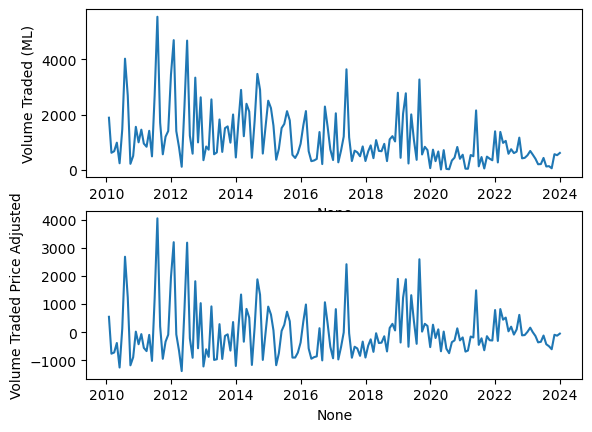

In [ ]:
fig, ax = plt.subplots(2)
sns.lineplot(new_data, x=new_data.index, y="Volume Traded (ML)", ax=ax[0])
sns.lineplot(new_data, x=new_data.index, y="Volume Traded Price Adjusted", ax=ax[1])

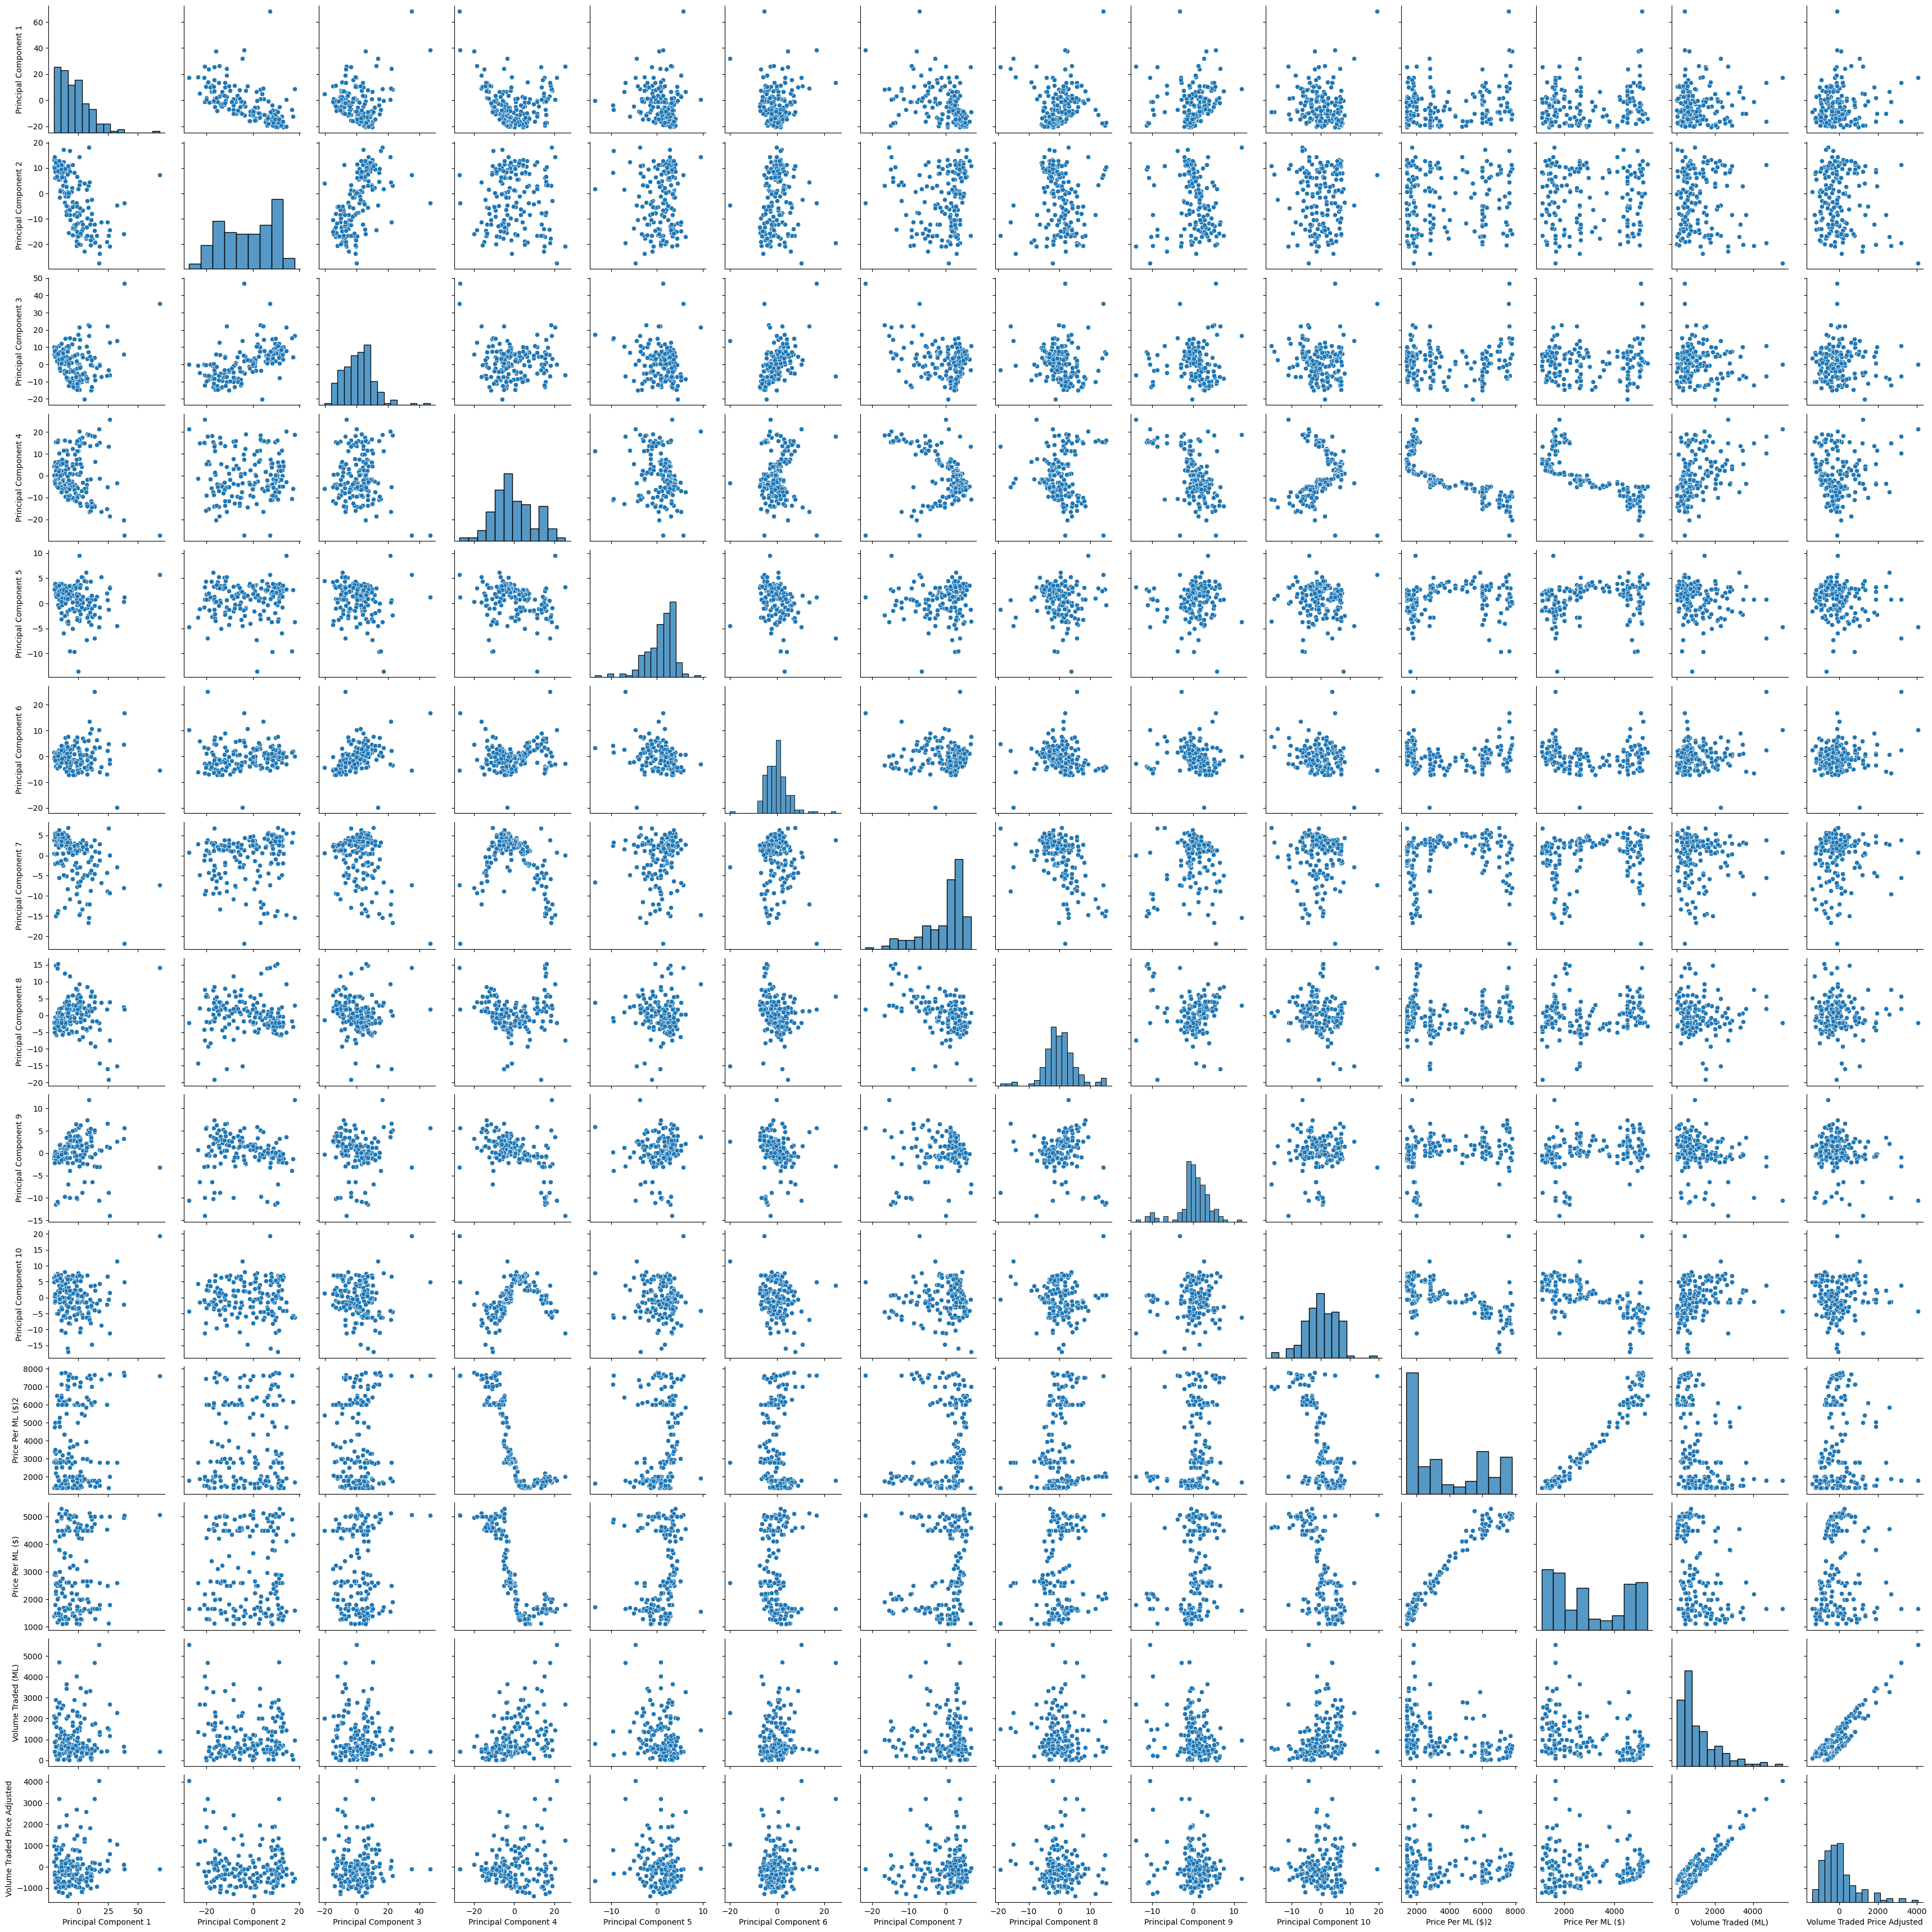

In [ ]:
sns.pairplot(new_data)

In [ ]:
sarimax_volume = "SARIMAX Volume"
make_dataset(new_data, "Volume Traded Price Adjusted", sarimax_volume, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[:10])

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\

In [ ]:
sar_vol = pd.read_csv(f"{sarimax_volume}.csv", index_col=0)
sar_vol = initialise(sar_vol)
sar_vol.value+=(res.slope*new_data.iloc[sar_vol.period, :]["Price Per ML ($)"].values + res.intercept)
sar_vol.to_csv("Readjusted SARIMAX Volume.csv")

In [ ]:
MAEs(sar_vol)

index        lower        upper        value  start  offset  period  \
0          0     0.000000     0.000000  1885.900000     10     -10       0   
1          1     0.000000     0.000000   613.800000     10      -9       1   
2          2     0.000000     0.000000   670.000000     10      -8       2   
3          3     0.000000     0.000000   980.900000     10      -7       3   
4          4     0.000000     0.000000   233.300000     10      -6       4   
...      ...          ...          ...          ...    ...     ...     ...   
26539    163     0.000000     0.000000   128.200000    167      -4     163   
26540    164     0.000000     0.000000    50.500000    167      -3     164   
26541    165     0.000000     0.000000   561.700000    167      -2     165   
26542    166     0.000000     0.000000   526.700000    167      -1     166   
26543    167 -1639.415864  1291.415956   485.953616    167       0     167   

         Observed  Rank  Observed Rank  error  rank_error  
0             NaN  12.0            NaN    NaN         NaN  
1             NaN   4.0            NaN    NaN         NaN  
2             NaN   5.0            NaN    NaN         NaN  
3             NaN   7.0            NaN    NaN         NaN  
4             NaN   2.0            NaN    NaN         NaN  
...           ...   ...            ...    ...         ...  
26539  128.200000  12.0           12.0    0.0         0.0  
26540   50.500000   7.0            7.0    0.0         0.0  
26541  561.700000  62.0           62.0    0.0         0.0  
26542  526.700000  54.0           54.0    0.0         0.0  
26543  485.953616  49.0           49.0    0.0         0.0  

[26544 rows x 12 columns]

In [ ]:
sar_vol

index        lower        upper        value  start  offset  period  \
0          0     0.000000     0.000000  1885.900000     10     -10       0   
1          1     0.000000     0.000000   613.800000     10      -9       1   
2          2     0.000000     0.000000   670.000000     10      -8       2   
3          3     0.000000     0.000000   980.900000     10      -7       3   
4          4     0.000000     0.000000   233.300000     10      -6       4   
...      ...          ...          ...          ...    ...     ...     ...   
26539    163     0.000000     0.000000   128.200000    167      -4     163   
26540    164     0.000000     0.000000    50.500000    167      -3     164   
26541    165     0.000000     0.000000   561.700000    167      -2     165   
26542    166     0.000000     0.000000   526.700000    167      -1     166   
26543    167 -1639.415864  1291.415956   485.953616    167       0     167   

         Observed  Rank  Observed Rank  
0             NaN  12.0            NaN  
1             NaN   4.0            NaN  
2             NaN   5.0            NaN  
3             NaN   7.0            NaN  
4             NaN   2.0            NaN  
...           ...   ...            ...  
26539  128.200000  12.0           12.0  
26540   50.500000   7.0            7.0  
26541  561.700000  62.0           62.0  
26542  526.700000  54.0           54.0  
26543  485.953616  49.0           49.0  

[26544 rows x 10 columns]

In [ ]:

sar_vol.value

0        1885.900000
1         613.800000
2         670.000000
3         980.900000
4         233.300000
            ...     
26539     128.200000
26540      50.500000
26541     561.700000
26542     526.700000
26543     485.953616
Name: value, Length: 26544, dtype: float64

In [ ]:
sar_vol.value += new_data.iloc[sar_vol.start]

lower        upper        value  start
0       0.000000     0.000000   547.460728     10
1       0.000000     0.000000  -767.044628     10
2       0.000000     0.000000  -724.979747     10
3       0.000000     0.000000  -385.809509     10
4       0.000000     0.000000 -1260.625578     10
..           ...          ...          ...    ...
163     0.000000     0.000000  -503.483332    167
164     0.000000     0.000000  -609.453570    167
165     0.000000     0.000000   -94.013034    167
166     0.000000     0.000000  -124.772498    167
167 -1639.415864  1291.415956  -173.999954    167

[26544 rows x 4 columns]

(890.0, 5510.0)

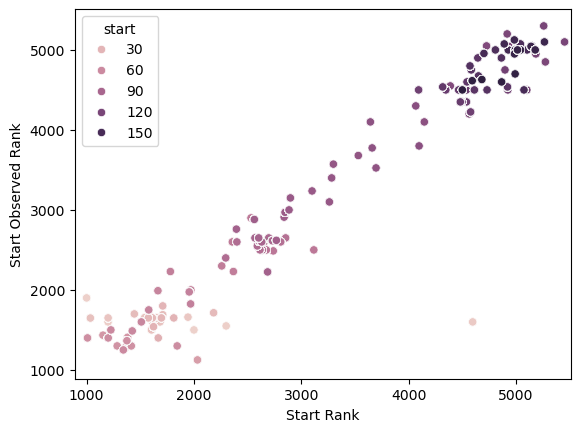

In [ ]:
sns.scatterplot(df[filter_], x='Start Rank', y='Start Observed Rank', hue='start')

plt.xlim(plt.gca().get_ylim())

In [ ]:
sv = pd.read_csv("Readjusted SARIMAX Volume.csv")

(26544, 7)


C:\Users\Meredith\AppData\Local\Temp\ipykernel_8216\2868371591.py:142: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_.set_yscale('log')


(26544, 4)


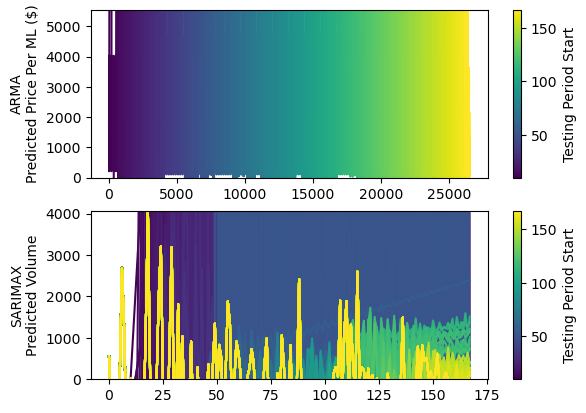

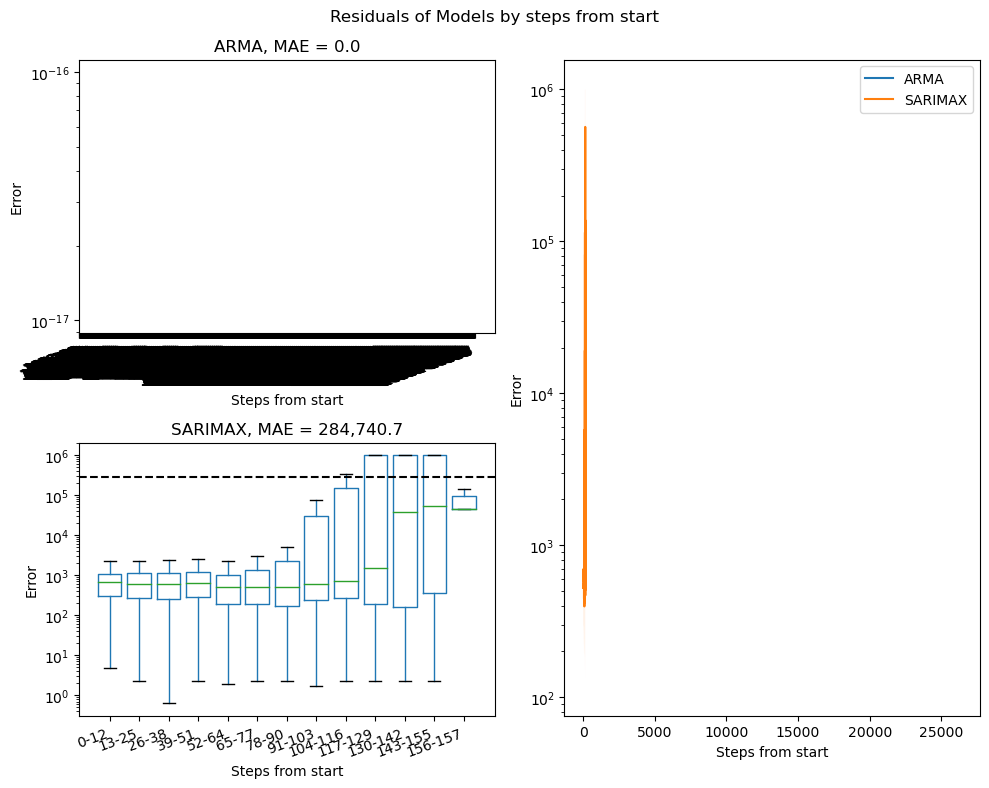

In [ ]:
fig, ax = plt.subplots(2)

#r_fig, resid_ax = plt.subplots(2, figsize=(10, 8))
r_fig, resid_ax = plt.subplot_mosaic([[0, 2], [1, 2]], figsize=(10, 8))

read_and_plot("Readjusted SARIMAX Volume.csv", ax[0], resid_ax[0], resid_ax[2], label="ARMA")
ax[0].set_ylabel("ARMA\nPredicted Price Per ML ($)")

read_and_plot(f'{sarimax_volume}.csv', ax[1], resid_ax[1], resid_ax[2], label="SARIMAX")
ax[1].set_ylabel("SARIMAX\nPredicted Volume")

r_fig.tight_layout()
r_fig.suptitle("Residuals of Models by steps from start")

resid_ax[2].legend()

In [ ]:


df["Start Observed Rank"] = df.start
df["Start Observed Rank"] = df["Start Observed Rank"].map(df[df.offset==0].set_index('start')['Observed Rank'])

df["Higher"] = df["Rank"] > df["Start Rank"]
df["Observed Higher"] = df["Observed Rank"] > df["Start Observed Rank"]

In [ ]:
df[df.period==df.start]

index        lower        upper        value  start     Observed  \
10        10   -75.687426  4075.687426  2000.000000     10  1500.000000   
179       11   299.427575  1700.572425  1000.000000     11  1900.000000   
348       12  1513.460212  3086.539788  2300.000000     12  1550.000000   
517       13   365.164615  2034.835385  1200.000000     13  1600.000000   
686       14  -124.348411  1067.422975   471.537282     14  1600.000000   
...      ...          ...          ...          ...    ...          ...   
25867    163  4649.788611  5333.370102  4991.579357    163  4700.000000   
26036    164  4523.450127  5208.039397  4865.744762    164  4600.000000   
26205    165  4249.827317  4933.911523  4591.869420    165  4615.000000   
26374    166  4340.910318  5022.584046  4681.747182    166  4630.000000   
26543    167  4159.767061  4840.173626  4499.970344    167  4499.970344   

        Rank  Observed Rank        error  rank_error  offset  period  \
10      83.0           29.5   500.000000        53.5       0      10   
179    157.0           58.0  -900.000000        99.0       0      11   
348     13.0           33.0   750.000000       -20.0       0      12   
517    155.0           36.5  -400.000000       118.5       0      13   
686     77.0           36.5 -1128.462718        40.5       0      14   
...      ...            ...          ...         ...     ...     ...   
25867  144.0          139.0   291.579357         5.0       0     163   
26036  142.0          134.5   265.744762         7.5       0     164   
26205  134.0          136.0   -23.130580        -2.0       0     165   
26374  138.0          137.0    51.747182         1.0       0     166   
26543  118.0          118.0     0.000000         0.0       0     167   

       scaled_rank_error  Start Rank  Higher  Start Observed Rank  \
10              0.340764        83.0   False                 29.5   
179             0.634615       157.0   False                 58.0   
348            -0.129032        13.0    True                 33.0   
517             0.769481       155.0   False                 36.5   
686             0.264706        77.0   False                 36.5   
...                  ...         ...     ...                  ...   
25867           1.250000       144.0    True                139.0   
26036           2.500000       142.0    True                134.5   
26205          -1.000000       134.0    True                136.0   
26374           1.000000       138.0    True                137.0   
26543                NaN       118.0    True                118.0   

       Observed Higher  
10               False  
179              False  
348              False  
517              False  
686              False  
...                ...  
25867            False  
26036            False  
26205            False  
26374            False  
26543            False  

[158 rows x 17 columns]

In [ ]:
df.groupby('start').mean()['Observed Higher']

start
10     0.815476
11     0.654762
12     0.803571
13     0.767857
14     0.767857
         ...   
163    0.172619
164    0.196429
165    0.190476
166    0.184524
167    0.297619
Name: Observed Higher, Length: 158, dtype: float64

In [ ]:
df[df.start==10].head(20)

index         lower         upper     value  start  Observed   Rank  \
0       0      0.000000      0.000000  2200.000     10  2200.000  167.5   
1       1      0.000000      0.000000  2050.000     10  2050.000  164.0   
2       2      0.000000      0.000000  2000.000     10  2000.000   83.0   
3       3      0.000000      0.000000  2100.000     10  2100.000  165.0   
4       4      0.000000      0.000000  1650.000     10  1650.000    1.0   
5       5      0.000000      0.000000  2200.000     10  2200.000  167.5   
6       6      0.000000      0.000000  2196.205     10  2196.205  166.0   
7       7      0.000000      0.000000  1800.000     10  1800.000    2.0   
8       8      0.000000      0.000000  2000.000     10  2000.000   83.0   
9       9      0.000000      0.000000  2000.000     10  2000.000   83.0   
10     10    -75.687426   4075.687426  2000.000     10  1500.000   83.0   
11     11  -2207.247631   6207.247631  2000.000     10  1900.000   83.0   
12     12  -4411.817367   8411.817367  2000.000     10  1550.000   83.0   
13     13  -6687.573032  10687.573032  2000.000     10  1600.000   83.0   
14     14  -9032.793902  13032.793902  2000.000     10  1600.000   83.0   
15     15 -11445.865133  15445.865133  2000.000     10  1600.000   83.0   
16     16 -13925.269473  17925.269473  2000.000     10  1600.000   83.0   
17     17 -16469.578666  20469.578666  2000.000     10  1660.000   83.0   
18     18 -19077.445599  23077.445599  2000.000     10  1654.165   83.0   
19     19 -21747.597298  25747.597298  2000.000     10  1650.000   83.0   

    Observed Rank    error  rank_error  offset  period  scaled_rank_error  \
0            68.5    0.000        99.0     -10       0           0.630573   
1            65.0    0.000        99.0      -9       1           0.630573   
2            62.5    0.000        20.5      -8       2           0.130573   
3            66.0    0.000        99.0      -7       3           0.630573   
4            44.0    0.000       -43.0      -6       4          -0.273885   
5            68.5    0.000        99.0      -5       5           0.630573   
6            67.0    0.000        99.0      -4       6           0.630573   
7            55.0    0.000       -53.0      -3       7          -0.337580   
8            62.5    0.000        20.5      -2       8           0.130573   
9            62.5    0.000        20.5      -1       9           0.130573   
10           29.5  500.000        53.5       0      10           0.340764   
11           58.0  100.000        25.0       1      11           0.159236   
12           33.0  450.000        50.0       2      12           0.318471   
13           36.5  400.000        46.5       3      13           0.296178   
14           36.5  400.000        46.5       4      14           0.296178   
15           36.5  400.000        46.5       5      15           0.296178   
16           36.5  400.000        46.5       6      16           0.296178   
17           49.0  340.000        34.0       7      17           0.216561   
18           48.0  345.835        35.0       8      18           0.222930   
19           44.0  350.000        39.0       9      19           0.248408   

    Start Rank  Higher  Start Observed Rank  Observed Higher  
0         83.0   False                 29.5             True  
1         83.0   False                 29.5             True  
2         83.0   False                 29.5             True  
3         83.0   False                 29.5             True  
4         83.0   False                 29.5             True  
5         83.0   False                 29.5             True  
6         83.0   False                 29.5             True  
7         83.0   False                 29.5             True  
8         83.0   False                 29.5             True  
9         83.0   False                 29.5             True  
10        83.0   False                 29.5            False  
11        83.0   False                 29.5           

<AxesSubplot: ylabel='Observed Rank'>

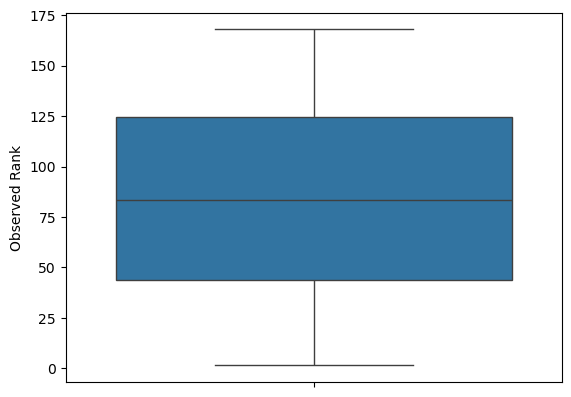

In [ ]:
sns.boxplot(df['Observed Rank'])

In [ ]:
def plot_reg(filtered_df, x='offset', y='rank_error', ax=None):
    sns.regplot(abs(filtered_df), x=x, y=y, logx=False, line_kws=dict(color="k"),scatter=False, ax=ax)
    sns.scatterplot(filtered_df, x=x, y=y, hue='start', palette='Spectral', ax=ax)

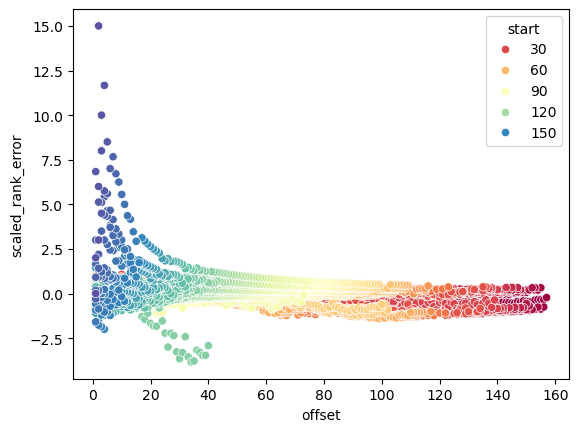

In [ ]:
plot_reg(filtered_df, y='scaled_rank_error')

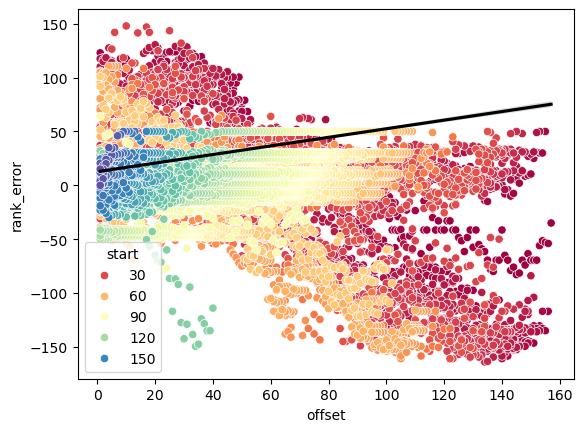

In [ ]:
plot_reg(filtered_df, y='rank_error')

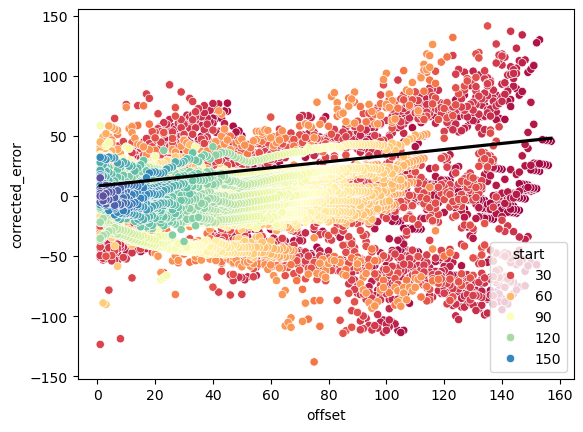

In [ ]:
plot_reg(filtered_df, y='corrected_error')

<AxesSubplot: xlabel='offset', ylabel='start_corrected_error'>

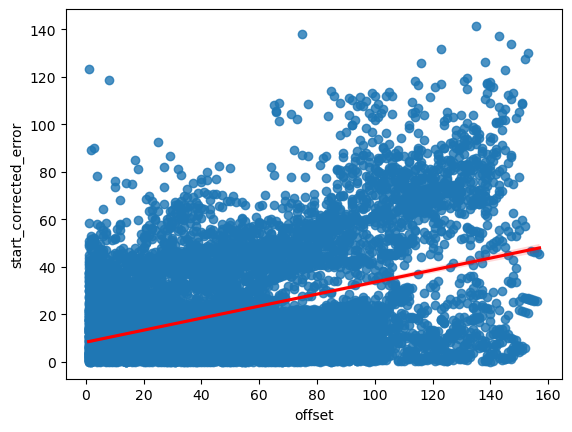

In [ ]:
sns.regplot(abs(filtered_df), x='offset', y='start_corrected_error', logx=False, line_kws=dict(color="r"))
#plt.yscale('log')

C:\Users\Meredith\AppData\Local\Temp\ipykernel_8216\811734599.py:6: RuntimeWarning: invalid value encountered in divide
  ax[0].boxplot(gaussian(x,std, mu)/scipy.stats.norm.pdf(x,loc=mu, scale=std), positions=[std])


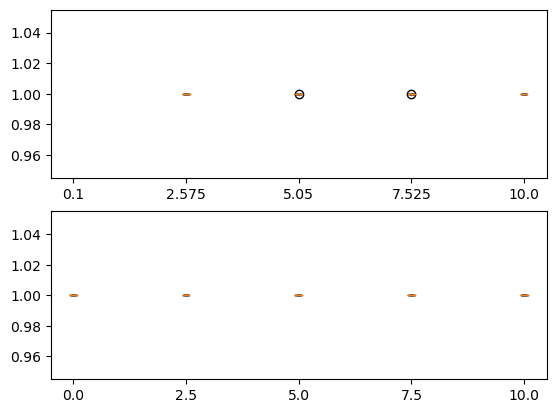

In [ ]:
fig, ax = plt.subplots(2)

x= np.arange(5)
for std in np.linspace(0.1, 10, num=5):

    ax[0].boxplot(gaussian(x,std, mu)/scipy.stats.norm.pdf(x,loc=mu, scale=std), positions=[std])

for mu in np.linspace(0, 10, num=5):

    ax[1].boxplot(gaussian(x,std, mu)/scipy.stats.norm.pdf(x,loc=mu, scale=std), positions=[mu])

In [ ]:
scipy.stats.gamma.shapes

'a'

In [ ]:
class customGaussian():
    def __init__(self, ):
        pass